In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from ResNet50 layers ...")
resnet50features = base_model.predict(X)

Extracting features from ResNet50 layers ...


In [8]:
print(resnet50features)

[[ 0.15815499  0.00414445  0.74599981 ...,  0.          0.          0.03397543]
 [ 0.16040559  0.07608034  0.62385374 ...,  0.          0.          0.03181141]
 [ 0.14395103  0.          0.5349924  ...,  0.          0.00288542
   0.04359856]
 ..., 
 [ 0.54970431  0.01525703  1.74698746 ...,  0.          0.0033371
   0.17374095]
 [ 0.54970431  0.01525703  1.74698746 ...,  0.          0.0033371
   0.17374095]
 [ 0.54970431  0.01525703  1.74698746 ...,  0.          0.0033371
   0.17374095]]


In [9]:
resnet50features.shape

(9339, 2048)

In [10]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=resnet50features.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 25)                51225     
Total params: 51,225
Trainable params: 51,225
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [13]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-resnet50-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [14]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    resnet50features_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    resnet50features_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(resnet50features_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(resnet50features_train, Y_train, validation_data=(resnet50features_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(resnet50features_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0000
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 0s - loss: 0.6463 - acc: 0.8388 - val_loss: 0.2558 - val_acc: 0.9397
Epoch 2/100
8394/8394 [==============================] - 0s - loss: 0.1711 - acc: 0.9500 - val_loss: 0.1705 - val_acc: 0.9503
Epoch 3/100
8394/8394 [==============================] - 0s - loss: 0.1225 - acc: 0.9596 - val_loss: 0.1578 - val_acc: 0.9460
Epoch 4/100
8394/8394 [==============================] - 0s - loss: 0.1001 - acc: 0.9646 - val_loss: 0.1148 - val_acc: 0.9672
Epoch 5/100
8394/8394 [==============================] - 0s - loss: 0.0851 - acc: 0.9689 - val_loss: 0.0975 - val_acc: 0.9661
Epoch 6/100
8394/8394 [==============================] - 0s - loss: 0.0699 - acc: 0.9744 - val_loss: 0.1202 - val_acc: 0.9704
Epoch 7/100
8394/8394 [==============================] - 0s - loss: 0.0710 - acc: 0.9752 - val_loss: 0.0847 - val_acc: 0.

8394/8394 [==============================] - 0s - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0435 - val_acc: 0.9873
Epoch 65/100
8394/8394 [==============================] - 0s - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0467 - val_acc: 0.9873
Epoch 66/100
8394/8394 [==============================] - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9873
Epoch 67/100
8394/8394 [==============================] - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0462 - val_acc: 0.9841
Epoch 68/100
8394/8394 [==============================] - 0s - loss: 0.0028 - acc: 0.9999 - val_loss: 0.0436 - val_acc: 0.9862
Epoch 69/100
8394/8394 [==============================] - 0s - loss: 0.0022 - acc: 0.9999 - val_loss: 0.0412 - val_acc: 0.9873
Epoch 70/100
8394/8394 [==============================] - 0s - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0461 - val_acc: 0.9862
Epoch 71/100
8394/8394 [==============================] - 0s - loss: 0.0023 - acc: 0.9999 - val_loss: 0.0429 - val_acc: 0.98

8394/8394 [==============================] - 84s - loss: 0.0058 - acc: 0.9995 - val_loss: 0.1058 - val_acc: 0.9757
Epoch 28/100
8394/8394 [==============================] - 84s - loss: 0.0033 - acc: 0.9999 - val_loss: 0.0878 - val_acc: 0.9852
Epoch 29/100
8394/8394 [==============================] - 84s - loss: 0.0041 - acc: 0.9995 - val_loss: 0.0956 - val_acc: 0.9841
Epoch 30/100
8394/8394 [==============================] - 84s - loss: 0.0032 - acc: 0.9998 - val_loss: 0.1172 - val_acc: 0.9767
Epoch 31/100
8394/8394 [==============================] - 84s - loss: 0.0048 - acc: 0.9998 - val_loss: 0.1169 - val_acc: 0.9746
Epoch 32/100
8394/8394 [==============================] - 84s - loss: 0.0026 - acc: 0.9999 - val_loss: 0.0924 - val_acc: 0.9862
Epoch 33/100
8394/8394 [==============================] - 84s - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0977 - val_acc: 0.9862
Epoch 34/100
8394/8394 [==============================] - 84s - loss: 0.0046 - acc: 0.9998 - val_loss: 0.1430 - val_a

8394/8394 [==============================] - 84s - loss: 9.3883e-04 - acc: 0.9999 - val_loss: 0.1009 - val_acc: 0.9862
Epoch 91/100
8394/8394 [==============================] - 84s - loss: 7.9131e-04 - acc: 1.0000 - val_loss: 0.0969 - val_acc: 0.9873
Epoch 92/100
8394/8394 [==============================] - 84s - loss: 8.2141e-04 - acc: 1.0000 - val_loss: 0.0986 - val_acc: 0.9873
Epoch 93/100
8394/8394 [==============================] - 84s - loss: 7.2499e-04 - acc: 1.0000 - val_loss: 0.0974 - val_acc: 0.9873
Epoch 94/100
8394/8394 [==============================] - 84s - loss: 5.1981e-04 - acc: 1.0000 - val_loss: 0.0986 - val_acc: 0.9873
Epoch 95/100
8394/8394 [==============================] - 84s - loss: 5.0113e-04 - acc: 1.0000 - val_loss: 0.0994 - val_acc: 0.9873
Epoch 96/100
8394/8394 [==============================] - 84s - loss: 5.8283e-04 - acc: 1.0000 - val_loss: 0.1000 - val_acc: 0.9873
Epoch 97/100
8394/8394 [==============================] - 84s - loss: 5.2975e-04 - acc: 1

8397/8397 [==============================] - 0s - loss: 0.0028 - acc: 0.9999 - val_loss: 0.0596 - val_acc: 0.9862
Epoch 54/100
8397/8397 [==============================] - 0s - loss: 0.0031 - acc: 0.9998 - val_loss: 0.0516 - val_acc: 0.9841
Epoch 55/100
8397/8397 [==============================] - 0s - loss: 0.0025 - acc: 0.9999 - val_loss: 0.0531 - val_acc: 0.9830
Epoch 56/100
8397/8397 [==============================] - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9820
Epoch 57/100
8397/8397 [==============================] - 0s - loss: 0.0036 - acc: 0.9992 - val_loss: 0.0500 - val_acc: 0.9841
Epoch 58/100
8397/8397 [==============================] - 0s - loss: 0.0039 - acc: 0.9992 - val_loss: 0.0512 - val_acc: 0.9841
Epoch 59/100
8397/8397 [==============================] - 0s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0521 - val_acc: 0.9830
Epoch 60/100
8397/8397 [==============================] - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 0.98

8397/8397 [==============================] - 84s - loss: 0.0197 - acc: 0.9973 - val_loss: 0.2830 - val_acc: 0.9692
Epoch 17/100
8397/8397 [==============================] - 84s - loss: 0.0227 - acc: 0.9979 - val_loss: 0.0613 - val_acc: 0.9820
Epoch 18/100
8397/8397 [==============================] - 84s - loss: 0.0220 - acc: 0.9973 - val_loss: 0.3274 - val_acc: 0.9628
Epoch 19/100
8397/8397 [==============================] - 84s - loss: 0.0166 - acc: 0.9979 - val_loss: 0.2573 - val_acc: 0.9724
Epoch 20/100
8397/8397 [==============================] - 84s - loss: 0.0134 - acc: 0.9982 - val_loss: 0.0627 - val_acc: 0.9873
Epoch 21/100
8397/8397 [==============================] - 84s - loss: 0.0185 - acc: 0.9981 - val_loss: 0.2865 - val_acc: 0.9724
Epoch 22/100
8397/8397 [==============================] - 84s - loss: 0.0076 - acc: 0.9993 - val_loss: 0.2318 - val_acc: 0.9724
Epoch 23/100
8397/8397 [==============================] - 84s - loss: 0.0059 - acc: 0.9994 - val_loss: 0.2525 - val_a

8397/8397 [==============================] - 84s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0871 - val_acc: 0.9841
Epoch 81/100
8397/8397 [==============================] - 84s - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0775 - val_acc: 0.9873
Epoch 82/100
8397/8397 [==============================] - 84s - loss: 0.0096 - acc: 0.9993 - val_loss: 0.0729 - val_acc: 0.9841
Epoch 83/100
8397/8397 [==============================] - 84s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0759 - val_acc: 0.9873
Epoch 84/100
8397/8397 [==============================] - 84s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0734 - val_acc: 0.9862
Epoch 85/100
8397/8397 [==============================] - 84s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0787 - val_acc: 0.9851
Epoch 86/100
8397/8397 [==============================] - 84s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0836 - val_acc: 0.9841
Epoch 87/100
8397/8397 [==============================] - 84s - loss: 9.8614e-04 - acc: 1.0000 - val_loss: 0.0799 - v

8401/8401 [==============================] - 0s - loss: 0.0041 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9840
Epoch 44/100
8401/8401 [==============================] - 0s - loss: 0.0043 - acc: 0.9996 - val_loss: 0.0384 - val_acc: 0.9808
Epoch 45/100
8401/8401 [==============================] - 0s - loss: 0.0046 - acc: 0.9995 - val_loss: 0.0416 - val_acc: 0.9819
Epoch 46/100
8401/8401 [==============================] - 0s - loss: 0.0081 - acc: 0.9971 - val_loss: 0.0339 - val_acc: 0.9872
Epoch 47/100
8401/8401 [==============================] - 0s - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0355 - val_acc: 0.9893
Epoch 48/100
8401/8401 [==============================] - 0s - loss: 0.0037 - acc: 0.9998 - val_loss: 0.0374 - val_acc: 0.9840
Epoch 49/100
8401/8401 [==============================] - 0s - loss: 0.0052 - acc: 0.9989 - val_loss: 0.0367 - val_acc: 0.9904
Epoch 50/100
8401/8401 [==============================] - 0s - loss: 0.0041 - acc: 0.9999 - val_loss: 0.0361 - val_acc: 0.98

8401/8401 [==============================] - 84s - loss: 0.1187 - acc: 0.9843 - val_loss: 0.0868 - val_acc: 0.9744
Epoch 7/100
8401/8401 [==============================] - 84s - loss: 0.1066 - acc: 0.9875 - val_loss: 0.3092 - val_acc: 0.9659
Epoch 8/100
8401/8401 [==============================] - 84s - loss: 0.0728 - acc: 0.9904 - val_loss: 0.1163 - val_acc: 0.9787
Epoch 9/100
8401/8401 [==============================] - 84s - loss: 0.0655 - acc: 0.9931 - val_loss: 0.3085 - val_acc: 0.9648
Epoch 10/100
8401/8401 [==============================] - 84s - loss: 0.0746 - acc: 0.9919 - val_loss: 0.1137 - val_acc: 0.9797
Epoch 11/100
8401/8401 [==============================] - 84s - loss: 0.0663 - acc: 0.9937 - val_loss: 0.2975 - val_acc: 0.9680
Epoch 12/100
8401/8401 [==============================] - 84s - loss: 0.0662 - acc: 0.9942 - val_loss: 0.2402 - val_acc: 0.9701
Epoch 13/100
8401/8401 [==============================] - 84s - loss: 0.0707 - acc: 0.9942 - val_loss: 0.3132 - val_acc:

8401/8401 [==============================] - 84s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1153 - val_acc: 0.9808
Epoch 71/100
8401/8401 [==============================] - 84s - loss: 9.6923e-04 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9808
Epoch 72/100
8401/8401 [==============================] - 84s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.1184 - val_acc: 0.9808
Epoch 73/100
8401/8401 [==============================] - 84s - loss: 0.0010 - acc: 0.9999 - val_loss: 0.1391 - val_acc: 0.9723
Epoch 74/100
8401/8401 [==============================] - 84s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.1235 - val_acc: 0.9797
Epoch 75/100
8401/8401 [==============================] - 84s - loss: 0.0024 - acc: 0.9999 - val_loss: 0.1656 - val_acc: 0.9691
Epoch 76/100
8401/8401 [==============================] - 84s - loss: 7.0731e-04 - acc: 1.0000 - val_loss: 0.1233 - val_acc: 0.9808
Epoch 77/100
8401/8401 [==============================] - 84s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.1211

8403/8403 [==============================] - 0s - loss: 0.1742 - acc: 0.9886 - val_loss: 0.2023 - val_acc: 0.9786
Epoch 33/100
8403/8403 [==============================] - 0s - loss: 0.1747 - acc: 0.9881 - val_loss: 0.2005 - val_acc: 0.9786
Epoch 34/100
8403/8403 [==============================] - 0s - loss: 0.1738 - acc: 0.9888 - val_loss: 0.2021 - val_acc: 0.9776
Epoch 35/100
8403/8403 [==============================] - 0s - loss: 0.1735 - acc: 0.9883 - val_loss: 0.2116 - val_acc: 0.9776
Epoch 36/100
8403/8403 [==============================] - 0s - loss: 0.1752 - acc: 0.9871 - val_loss: 0.1995 - val_acc: 0.9776
Epoch 37/100
8403/8403 [==============================] - 0s - loss: 0.1731 - acc: 0.9888 - val_loss: 0.2051 - val_acc: 0.9765
Epoch 38/100
8403/8403 [==============================] - 0s - loss: 0.1731 - acc: 0.9882 - val_loss: 0.1961 - val_acc: 0.9765
Epoch 39/100
8403/8403 [==============================] - 0s - loss: 0.1729 - acc: 0.9885 - val_loss: 0.2008 - val_acc: 0.97

8403/8403 [==============================] - 0s - loss: 0.1676 - acc: 0.9896 - val_loss: 0.2032 - val_acc: 0.9786
Epoch 97/100
8403/8403 [==============================] - 0s - loss: 0.1676 - acc: 0.9896 - val_loss: 0.2035 - val_acc: 0.9786
Epoch 98/100
8403/8403 [==============================] - 0s - loss: 0.1675 - acc: 0.9896 - val_loss: 0.2033 - val_acc: 0.9776
Epoch 99/100
8403/8403 [==============================] - 0s - loss: 0.1676 - acc: 0.9896 - val_loss: 0.2027 - val_acc: 0.9786
Epoch 100/100
8403/8403 [==============================] - 0s - loss: 0.1700 - acc: 0.9888 - val_loss: 0.2059 - val_acc: 0.9776
[3] Pre-trained acurracy (top_model): 0.9776
[3] Fine-tuning the model ...
Train on 8403 samples, validate on 936 samples
Epoch 1/100
8403/8403 [==============================] - 82s - loss: 1.8102 - acc: 0.7141 - val_loss: 0.9840 - val_acc: 0.8034
Epoch 2/100
8403/8403 [==============================] - 84s - loss: 0.4418 - acc: 0.9270 - val_loss: 0.5386 - val_acc: 0.9274
E

8403/8403 [==============================] - 84s - loss: 0.0052 - acc: 0.9994 - val_loss: 0.2860 - val_acc: 0.9701
Epoch 60/100
8403/8403 [==============================] - 84s - loss: 0.0046 - acc: 0.9992 - val_loss: 0.2864 - val_acc: 0.9690
Epoch 61/100
8403/8403 [==============================] - 84s - loss: 0.0065 - acc: 0.9992 - val_loss: 0.2786 - val_acc: 0.9722
Epoch 62/100
8403/8403 [==============================] - 84s - loss: 0.0036 - acc: 0.9995 - val_loss: 0.0980 - val_acc: 0.9797
Epoch 63/100
8403/8403 [==============================] - 84s - loss: 0.0054 - acc: 0.9994 - val_loss: 0.1117 - val_acc: 0.9754
Epoch 64/100
8403/8403 [==============================] - 84s - loss: 0.0035 - acc: 0.9995 - val_loss: 0.1259 - val_acc: 0.9701
Epoch 65/100
8403/8403 [==============================] - 84s - loss: 0.0038 - acc: 0.9996 - val_loss: 0.0948 - val_acc: 0.9829
Epoch 66/100
8403/8403 [==============================] - 84s - loss: 0.0062 - acc: 0.9994 - val_loss: 0.1275 - val_a

8404/8404 [==============================] - 0s - loss: 0.0132 - acc: 0.9970 - val_loss: 0.0380 - val_acc: 0.9850
Epoch 23/100
8404/8404 [==============================] - 0s - loss: 0.0124 - acc: 0.9968 - val_loss: 0.0345 - val_acc: 0.9840
Epoch 24/100
8404/8404 [==============================] - 0s - loss: 0.0119 - acc: 0.9977 - val_loss: 0.0359 - val_acc: 0.9850
Epoch 25/100
8404/8404 [==============================] - 0s - loss: 0.0116 - acc: 0.9979 - val_loss: 0.0392 - val_acc: 0.9850
Epoch 26/100
8404/8404 [==============================] - 0s - loss: 0.0105 - acc: 0.9979 - val_loss: 0.0325 - val_acc: 0.9861
Epoch 27/100
8404/8404 [==============================] - 0s - loss: 0.0098 - acc: 0.9982 - val_loss: 0.0342 - val_acc: 0.9850
Epoch 28/100
8404/8404 [==============================] - 0s - loss: 0.0097 - acc: 0.9980 - val_loss: 0.0364 - val_acc: 0.9818
Epoch 29/100
8404/8404 [==============================] - 0s - loss: 0.0112 - acc: 0.9968 - val_loss: 0.0443 - val_acc: 0.98

8404/8404 [==============================] - 0s - loss: 8.0243e-04 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9861
Epoch 87/100
8404/8404 [==============================] - 0s - loss: 8.8281e-04 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9872
Epoch 88/100
8404/8404 [==============================] - 0s - loss: 8.3720e-04 - acc: 1.0000 - val_loss: 0.0414 - val_acc: 0.9850
Epoch 89/100
8404/8404 [==============================] - 0s - loss: 8.3005e-04 - acc: 1.0000 - val_loss: 0.0361 - val_acc: 0.9861
Epoch 90/100
8404/8404 [==============================] - 0s - loss: 8.5679e-04 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9861
Epoch 91/100
8404/8404 [==============================] - 0s - loss: 9.3799e-04 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 0.9850
Epoch 92/100
8404/8404 [==============================] - 0s - loss: 7.8893e-04 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9861
Epoch 93/100
8404/8404 [==============================] - 0s - loss: 8.5549e-04 - acc: 1.0000 - 

8404/8404 [==============================] - 84s - loss: 0.0016 - acc: 0.9998 - val_loss: 0.1227 - val_acc: 0.9797
Epoch 49/100
8404/8404 [==============================] - 84s - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0972 - val_acc: 0.9818
Epoch 50/100
8404/8404 [==============================] - 84s - loss: 0.0018 - acc: 0.9999 - val_loss: 0.0965 - val_acc: 0.9818
Epoch 51/100
8404/8404 [==============================] - 84s - loss: 0.0016 - acc: 0.9998 - val_loss: 0.1001 - val_acc: 0.9786
Epoch 52/100
8404/8404 [==============================] - 84s - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0949 - val_acc: 0.9818
Epoch 53/100
8404/8404 [==============================] - 84s - loss: 0.0069 - acc: 0.9993 - val_loss: 0.2160 - val_acc: 0.9658
Epoch 54/100
8404/8404 [==============================] - 84s - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0964 - val_acc: 0.9786
Epoch 55/100
8404/8404 [==============================] - 84s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.1015 - val_a

8404/8404 [==============================] - 0s - loss: 0.0270 - acc: 0.9938 - val_loss: 0.0661 - val_acc: 0.9775
Epoch 11/100
8404/8404 [==============================] - 0s - loss: 0.0260 - acc: 0.9942 - val_loss: 0.0654 - val_acc: 0.9807
Epoch 12/100
8404/8404 [==============================] - 0s - loss: 0.0261 - acc: 0.9929 - val_loss: 0.0629 - val_acc: 0.9797
Epoch 13/100
8404/8404 [==============================] - 0s - loss: 0.0221 - acc: 0.9943 - val_loss: 0.0584 - val_acc: 0.9840
Epoch 14/100
8404/8404 [==============================] - 0s - loss: 0.0211 - acc: 0.9945 - val_loss: 0.0608 - val_acc: 0.9807
Epoch 15/100
8404/8404 [==============================] - 0s - loss: 0.0192 - acc: 0.9948 - val_loss: 0.0573 - val_acc: 0.9786
Epoch 16/100
8404/8404 [==============================] - 0s - loss: 0.0175 - acc: 0.9961 - val_loss: 0.0624 - val_acc: 0.9797
Epoch 17/100
8404/8404 [==============================] - 0s - loss: 0.0179 - acc: 0.9957 - val_loss: 0.0574 - val_acc: 0.98

8404/8404 [==============================] - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9840
Epoch 75/100
8404/8404 [==============================] - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9850
Epoch 76/100
8404/8404 [==============================] - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0549 - val_acc: 0.9850
Epoch 77/100
8404/8404 [==============================] - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9850
Epoch 78/100
8404/8404 [==============================] - 0s - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0533 - val_acc: 0.9829
Epoch 79/100
8404/8404 [==============================] - 0s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9861
Epoch 80/100
8404/8404 [==============================] - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 0.9829
Epoch 81/100
8404/8404 [==============================] - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0564 - val_acc: 0.98

8404/8404 [==============================] - 84s - loss: 0.0110 - acc: 0.9987 - val_loss: 0.2857 - val_acc: 0.9658
Epoch 38/100
8404/8404 [==============================] - 84s - loss: 0.0081 - acc: 0.9992 - val_loss: 0.0871 - val_acc: 0.9786
Epoch 39/100
8404/8404 [==============================] - 84s - loss: 0.0080 - acc: 0.9993 - val_loss: 0.1156 - val_acc: 0.9722
Epoch 40/100
8404/8404 [==============================] - 84s - loss: 0.0047 - acc: 0.9995 - val_loss: 0.0982 - val_acc: 0.9786
Epoch 41/100
8404/8404 [==============================] - 84s - loss: 0.0080 - acc: 0.9994 - val_loss: 0.0915 - val_acc: 0.9786
Epoch 42/100
8404/8404 [==============================] - 84s - loss: 0.0087 - acc: 0.9994 - val_loss: 0.0972 - val_acc: 0.9765
Epoch 43/100
8404/8404 [==============================] - 84s - loss: 0.0051 - acc: 0.9998 - val_loss: 0.0927 - val_acc: 0.9786
Epoch 44/100
8404/8404 [==============================] - 84s - loss: 0.0056 - acc: 0.9996 - val_loss: 0.0972 - val_a

[6] Pre-training the top model ...
[6] Initial acurracy (top_model): 0.0000
Train on 8408 samples, validate on 931 samples
Epoch 1/100
8408/8408 [==============================] - 0s - loss: 0.3980 - acc: 0.9096 - val_loss: 0.1266 - val_acc: 0.9549
Epoch 2/100
8408/8408 [==============================] - 0s - loss: 0.1067 - acc: 0.9653 - val_loss: 0.1164 - val_acc: 0.9635
Epoch 3/100
8408/8408 [==============================] - 0s - loss: 0.0749 - acc: 0.9731 - val_loss: 0.0834 - val_acc: 0.9678
Epoch 4/100
8408/8408 [==============================] - 0s - loss: 0.0600 - acc: 0.9788 - val_loss: 0.0745 - val_acc: 0.9796
Epoch 5/100
8408/8408 [==============================] - 0s - loss: 0.0487 - acc: 0.9845 - val_loss: 0.0608 - val_acc: 0.9731
Epoch 6/100
8408/8408 [==============================] - 0s - loss: 0.0445 - acc: 0.9863 - val_loss: 0.0554 - val_acc: 0.9871
Epoch 7/100
8408/8408 [==============================] - 0s - loss: 0.0382 - acc: 0.9882 - val_loss: 0.0618 - val_acc: 0.

8408/8408 [==============================] - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9807
Epoch 65/100
8408/8408 [==============================] - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9807
Epoch 66/100
8408/8408 [==============================] - 0s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 0.9817
Epoch 67/100
8408/8408 [==============================] - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9807
Epoch 68/100
8408/8408 [==============================] - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9807
Epoch 69/100
8408/8408 [==============================] - 0s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9817
Epoch 70/100
8408/8408 [==============================] - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9828
Epoch 71/100
8408/8408 [==============================] - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0547 - val_acc: 0.98

8408/8408 [==============================] - 84s - loss: 0.0084 - acc: 0.9992 - val_loss: 0.2812 - val_acc: 0.9699
Epoch 28/100
8408/8408 [==============================] - 84s - loss: 0.0093 - acc: 0.9989 - val_loss: 0.2015 - val_acc: 0.9699
Epoch 29/100
8408/8408 [==============================] - 84s - loss: 0.0065 - acc: 0.9992 - val_loss: 0.0872 - val_acc: 0.9828
Epoch 30/100
8408/8408 [==============================] - 84s - loss: 0.0082 - acc: 0.9994 - val_loss: 0.0970 - val_acc: 0.9785
Epoch 31/100
8408/8408 [==============================] - 84s - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0834 - val_acc: 0.9839
Epoch 32/100
8408/8408 [==============================] - 84s - loss: 0.0044 - acc: 0.9994 - val_loss: 0.0843 - val_acc: 0.9817
Epoch 33/100
8408/8408 [==============================] - 84s - loss: 0.0081 - acc: 0.9989 - val_loss: 0.2851 - val_acc: 0.9710
Epoch 34/100
8408/8408 [==============================] - 84s - loss: 0.0033 - acc: 0.9996 - val_loss: 0.2543 - val_a

8408/8408 [==============================] - 84s - loss: 6.7979e-04 - acc: 0.9999 - val_loss: 0.0925 - val_acc: 0.9839
Epoch 91/100
8408/8408 [==============================] - 84s - loss: 0.0025 - acc: 0.9998 - val_loss: 0.1000 - val_acc: 0.9850
Epoch 92/100
8408/8408 [==============================] - 84s - loss: 6.2937e-04 - acc: 1.0000 - val_loss: 0.0950 - val_acc: 0.9839
Epoch 93/100
8408/8408 [==============================] - 84s - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0896 - val_acc: 0.9850
Epoch 94/100
8408/8408 [==============================] - 84s - loss: 4.1715e-04 - acc: 1.0000 - val_loss: 0.0910 - val_acc: 0.9839
Epoch 95/100
8408/8408 [==============================] - 84s - loss: 0.0038 - acc: 0.9998 - val_loss: 0.0919 - val_acc: 0.9828
Epoch 96/100
8408/8408 [==============================] - 84s - loss: 0.0018 - acc: 0.9999 - val_loss: 0.0902 - val_acc: 0.9850
Epoch 97/100
8408/8408 [==============================] - 84s - loss: 6.4705e-04 - acc: 0.9999 - val_loss

8410/8410 [==============================] - 0s - loss: 0.2764 - acc: 0.9824 - val_loss: 0.3103 - val_acc: 0.9731
Epoch 54/100
8410/8410 [==============================] - 0s - loss: 0.2758 - acc: 0.9828 - val_loss: 0.3163 - val_acc: 0.9709
Epoch 55/100
8410/8410 [==============================] - 0s - loss: 0.2749 - acc: 0.9830 - val_loss: 0.3130 - val_acc: 0.9699
Epoch 56/100
8410/8410 [==============================] - 0s - loss: 0.2750 - acc: 0.9828 - val_loss: 0.3108 - val_acc: 0.9709
Epoch 57/100
8410/8410 [==============================] - 0s - loss: 0.2752 - acc: 0.9828 - val_loss: 0.3156 - val_acc: 0.9731
Epoch 58/100
8410/8410 [==============================] - 0s - loss: 0.2777 - acc: 0.9813 - val_loss: 0.3128 - val_acc: 0.9688
Epoch 59/100
8410/8410 [==============================] - 0s - loss: 0.2744 - acc: 0.9830 - val_loss: 0.3115 - val_acc: 0.9699
Epoch 60/100
8410/8410 [==============================] - 0s - loss: 0.2747 - acc: 0.9831 - val_loss: 0.3097 - val_acc: 0.96

8410/8410 [==============================] - 84s - loss: 0.0627 - acc: 0.9942 - val_loss: 0.0379 - val_acc: 0.9849
Epoch 17/100
8410/8410 [==============================] - 84s - loss: 0.0440 - acc: 0.9949 - val_loss: 0.2491 - val_acc: 0.9742
Epoch 18/100
8410/8410 [==============================] - 84s - loss: 0.0181 - acc: 0.9983 - val_loss: 0.2480 - val_acc: 0.9709
Epoch 19/100
8410/8410 [==============================] - 84s - loss: 0.0177 - acc: 0.9981 - val_loss: 0.2530 - val_acc: 0.9720
Epoch 20/100
8410/8410 [==============================] - 84s - loss: 0.0145 - acc: 0.9977 - val_loss: 0.0643 - val_acc: 0.9817
Epoch 21/100
8410/8410 [==============================] - 84s - loss: 0.0170 - acc: 0.9976 - val_loss: 0.2044 - val_acc: 0.9763
Epoch 22/100
8410/8410 [==============================] - 84s - loss: 0.0094 - acc: 0.9994 - val_loss: 0.1768 - val_acc: 0.9752
Epoch 23/100
8410/8410 [==============================] - 84s - loss: 0.0105 - acc: 0.9990 - val_loss: 0.0355 - val_a

8410/8410 [==============================] - 84s - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0769 - val_acc: 0.9774
Epoch 81/100
8410/8410 [==============================] - 84s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 0.9795
Epoch 82/100
8410/8410 [==============================] - 84s - loss: 0.0030 - acc: 0.9999 - val_loss: 0.0263 - val_acc: 0.9892
Epoch 83/100
8410/8410 [==============================] - 84s - loss: 0.0052 - acc: 0.9995 - val_loss: 0.0266 - val_acc: 0.9892
Epoch 84/100
8410/8410 [==============================] - 84s - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0340 - val_acc: 0.9882
Epoch 85/100
8410/8410 [==============================] - 84s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.2381 - val_acc: 0.9752
Epoch 86/100
8410/8410 [==============================] - 84s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0438 - val_acc: 0.9871
Epoch 87/100
8410/8410 [==============================] - 84s - loss: 0.0025 - acc: 0.9999 - val_loss: 0.0435 - val_a

8414/8414 [==============================] - 0s - loss: 0.0047 - acc: 0.9995 - val_loss: 0.0355 - val_acc: 0.9870
Epoch 44/100
8414/8414 [==============================] - 0s - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0429 - val_acc: 0.9838
Epoch 45/100
8414/8414 [==============================] - 0s - loss: 0.0045 - acc: 0.9999 - val_loss: 0.0290 - val_acc: 0.9881
Epoch 46/100
8414/8414 [==============================] - 0s - loss: 0.0041 - acc: 0.9999 - val_loss: 0.0292 - val_acc: 0.9881
Epoch 47/100
8414/8414 [==============================] - 0s - loss: 0.0039 - acc: 0.9998 - val_loss: 0.0299 - val_acc: 0.9870
Epoch 48/100
8414/8414 [==============================] - 0s - loss: 0.0041 - acc: 0.9995 - val_loss: 0.0316 - val_acc: 0.9859
Epoch 49/100
8414/8414 [==============================] - 0s - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0330 - val_acc: 0.9881
Epoch 50/100
8414/8414 [==============================] - 0s - loss: 0.0040 - acc: 0.9993 - val_loss: 0.0319 - val_acc: 0.98

8414/8414 [==============================] - 84s - loss: 0.1129 - acc: 0.9850 - val_loss: 0.0904 - val_acc: 0.9784
Epoch 7/100
8414/8414 [==============================] - 84s - loss: 0.0848 - acc: 0.9879 - val_loss: 0.0610 - val_acc: 0.9849
Epoch 8/100
8414/8414 [==============================] - 84s - loss: 0.0892 - acc: 0.9901 - val_loss: 0.1666 - val_acc: 0.9741
Epoch 9/100
8414/8414 [==============================] - 84s - loss: 0.0578 - acc: 0.9918 - val_loss: 0.0752 - val_acc: 0.9827
Epoch 10/100
8414/8414 [==============================] - 84s - loss: 0.0288 - acc: 0.9954 - val_loss: 0.1260 - val_acc: 0.9751
Epoch 11/100
8414/8414 [==============================] - 84s - loss: 0.0262 - acc: 0.9974 - val_loss: 0.2371 - val_acc: 0.9751
Epoch 12/100
8414/8414 [==============================] - 84s - loss: 0.0211 - acc: 0.9977 - val_loss: 0.1737 - val_acc: 0.9741
Epoch 13/100
8414/8414 [==============================] - 84s - loss: 0.0149 - acc: 0.9976 - val_loss: 0.2601 - val_acc:

8414/8414 [==============================] - 84s - loss: 9.0985e-04 - acc: 0.9999 - val_loss: 0.0451 - val_acc: 0.9881
Epoch 71/100
8414/8414 [==============================] - 84s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0436 - val_acc: 0.9881
Epoch 72/100
8414/8414 [==============================] - 84s - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0421 - val_acc: 0.9881
Epoch 73/100
8414/8414 [==============================] - 84s - loss: 8.8105e-04 - acc: 0.9999 - val_loss: 0.0428 - val_acc: 0.9881
Epoch 74/100
8414/8414 [==============================] - 84s - loss: 8.4150e-04 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9870
Epoch 75/100
8414/8414 [==============================] - 84s - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0463 - val_acc: 0.9892
Epoch 76/100
8414/8414 [==============================] - 84s - loss: 0.0010 - acc: 0.9999 - val_loss: 0.0454 - val_acc: 0.9881
Epoch 77/100
8414/8414 [==============================] - 84s - loss: 6.8951e-04 - acc: 1.0000 - val_loss

8416/8416 [==============================] - 0s - loss: 0.1442 - acc: 0.9910 - val_loss: 0.1860 - val_acc: 0.9762
Epoch 33/100
8416/8416 [==============================] - 0s - loss: 0.1442 - acc: 0.9906 - val_loss: 0.1832 - val_acc: 0.9762
Epoch 34/100
8416/8416 [==============================] - 0s - loss: 0.1438 - acc: 0.9911 - val_loss: 0.1812 - val_acc: 0.9794
Epoch 35/100
8416/8416 [==============================] - 0s - loss: 0.1470 - acc: 0.9891 - val_loss: 0.1820 - val_acc: 0.9805
Epoch 36/100
8416/8416 [==============================] - 0s - loss: 0.1440 - acc: 0.9905 - val_loss: 0.1819 - val_acc: 0.9783
Epoch 37/100
8416/8416 [==============================] - 0s - loss: 0.1433 - acc: 0.9911 - val_loss: 0.1833 - val_acc: 0.9783
Epoch 38/100
8416/8416 [==============================] - 0s - loss: 0.1427 - acc: 0.9911 - val_loss: 0.1893 - val_acc: 0.9762
Epoch 39/100
8416/8416 [==============================] - 0s - loss: 0.1477 - acc: 0.9884 - val_loss: 0.1908 - val_acc: 0.97

8416/8416 [==============================] - 0s - loss: 0.1384 - acc: 0.9914 - val_loss: 0.1954 - val_acc: 0.9783
Epoch 97/100
8416/8416 [==============================] - 0s - loss: 0.1385 - acc: 0.9914 - val_loss: 0.1980 - val_acc: 0.9772
Epoch 98/100
8416/8416 [==============================] - 0s - loss: 0.1384 - acc: 0.9914 - val_loss: 0.1960 - val_acc: 0.9783
Epoch 99/100
8416/8416 [==============================] - 0s - loss: 0.1386 - acc: 0.9913 - val_loss: 0.1971 - val_acc: 0.9772
Epoch 100/100
8416/8416 [==============================] - 0s - loss: 0.1394 - acc: 0.9910 - val_loss: 0.2018 - val_acc: 0.9762
[9] Pre-trained acurracy (top_model): 0.9762
[9] Fine-tuning the model ...
Train on 8416 samples, validate on 923 samples
Epoch 1/100
8416/8416 [==============================] - 83s - loss: 1.8329 - acc: 0.6867 - val_loss: 1.6934 - val_acc: 0.5320
Epoch 2/100
8416/8416 [==============================] - 84s - loss: 0.4394 - acc: 0.9248 - val_loss: 0.6424 - val_acc: 0.9036
E

8416/8416 [==============================] - 84s - loss: 9.4523e-04 - acc: 1.0000 - val_loss: 0.0961 - val_acc: 0.9729
Epoch 60/100
8416/8416 [==============================] - 84s - loss: 7.6114e-04 - acc: 1.0000 - val_loss: 0.0798 - val_acc: 0.9805
Epoch 61/100
8416/8416 [==============================] - 84s - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0827 - val_acc: 0.9816
Epoch 62/100
8416/8416 [==============================] - 84s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.1246 - val_acc: 0.9707
Epoch 63/100
8416/8416 [==============================] - 84s - loss: 9.8910e-04 - acc: 0.9999 - val_loss: 0.1460 - val_acc: 0.9697
Epoch 64/100
8416/8416 [==============================] - 84s - loss: 9.1970e-04 - acc: 1.0000 - val_loss: 0.0822 - val_acc: 0.9827
Epoch 65/100
8416/8416 [==============================] - 84s - loss: 8.9786e-04 - acc: 1.0000 - val_loss: 0.0804 - val_acc: 0.9805
Epoch 66/100
8416/8416 [==============================] - 84s - loss: 9.3387e-04 - acc: 0.9999 - 

In [15]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9824


In [16]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

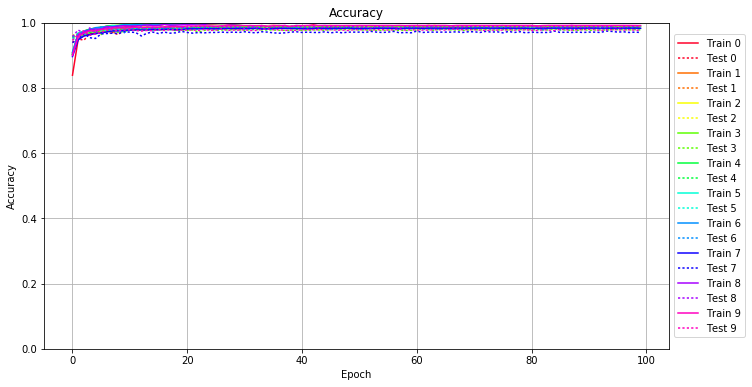

In [17]:
plot_acc(tophistory)

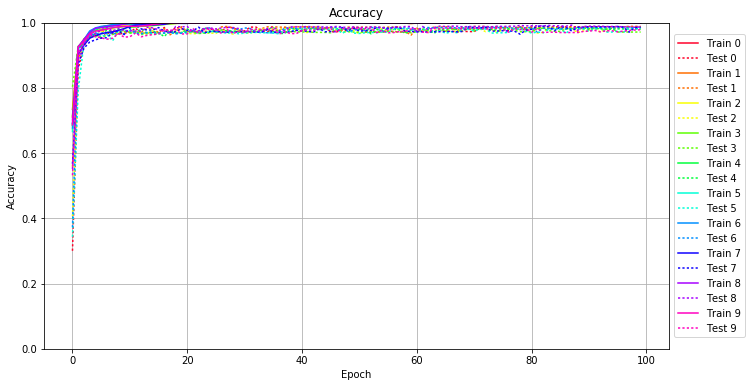

In [18]:
plot_acc(history)

In [19]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

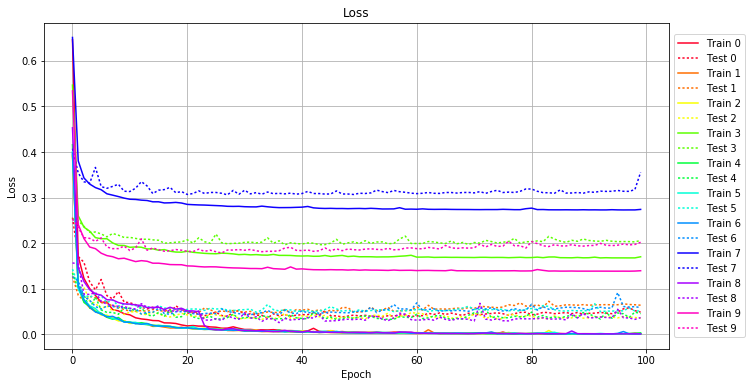

In [20]:
plot_loss(tophistory)

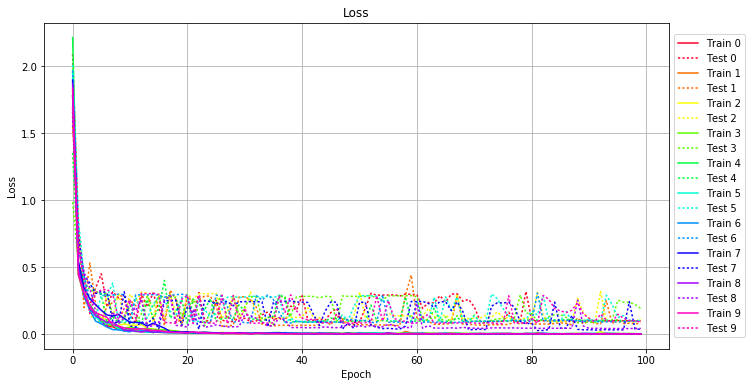

In [21]:
plot_loss(history)

Plotting the confusion matrix


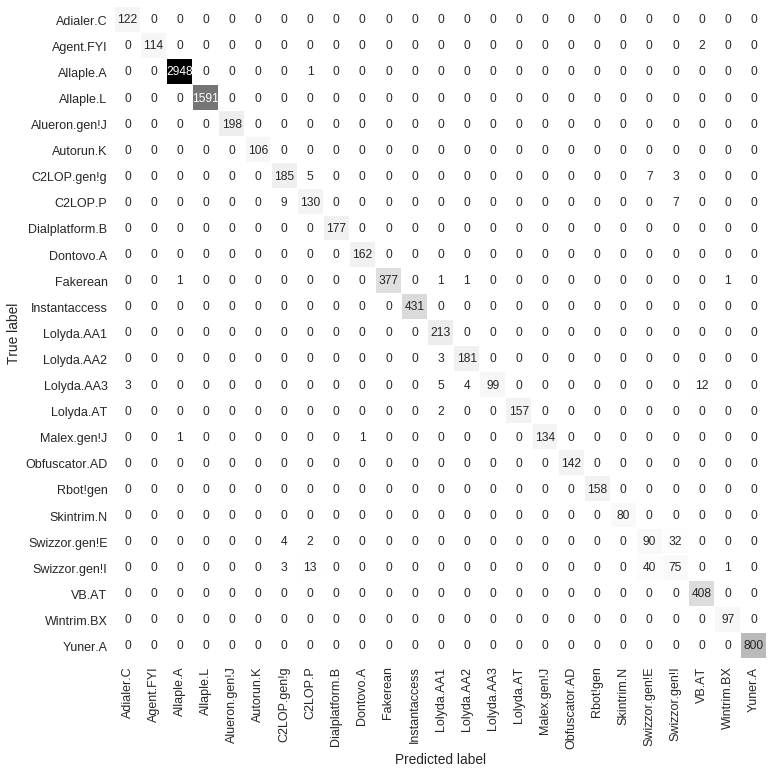

In [22]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


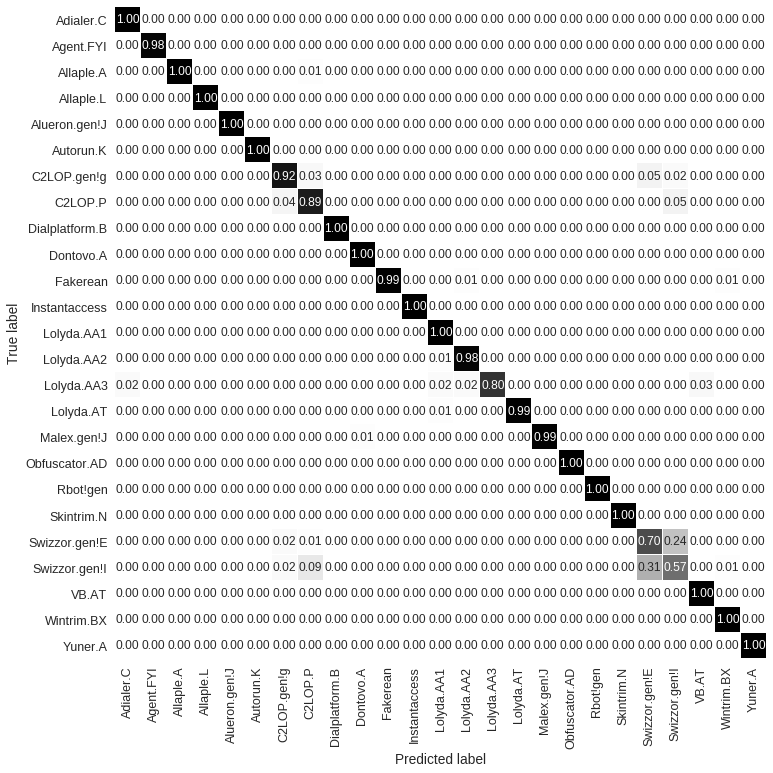

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
for h in tophistory:
    print(h.history)

{'acc': [0.83881343817012155, 0.94996426018584701, 0.95961401000714797, 0.96461758396015984, 0.96890636165851574, 0.97438646649530392, 0.97522039549220652, 0.98213009292351683, 0.98451274720038118, 0.98665713604955918, 0.98677626876340241, 0.98903979032642364, 0.99249463902787705, 0.99035025017869904, 0.99249463902787705, 0.9918989754586609, 0.99451989516321182, 0.99332856802477965, 0.99332856802477965, 0.99606862044317368, 0.99690254944007628, 0.99523469144627119, 0.99535382416011442, 0.99547295687395754, 0.99547295687395754, 0.99618775315701691, 0.99773647843697877, 0.99630688587086014, 0.99487729330474151, 0.99642601858470337, 0.99880867286156783, 0.997855611150822, 0.99892780557541105, 0.99833214200619491, 0.99797474386466523, 0.99702168215391951, 0.99809387657850845, 0.99892780557541105, 0.99845127472003814, 0.99821300929235168, 0.99928520371694063, 0.99857040743388137, 0.99559208958780077, 0.99904693828925428, 0.99928520371694063, 0.997855611150822, 0.99964260185847031, 0.9990469

In [25]:
for h in history:
    print(h.history)

{'acc': [0.71038837266133059, 0.92292113411503229, 0.94353109365251475, 0.96306885873700487, 0.98022396951622703, 0.98641887062187272, 0.99070764829182534, 0.99177984275901943, 0.9935668334240626, 0.9948772933331449, 0.99475816056249478, 0.9970216821823229, 0.99654515127014309, 0.9978556111792255, 0.997855611150822, 0.99880867286156783, 0.99857040740547787, 0.99857040740547787, 0.99892780560381444, 0.99821300929235168, 0.9991660710030974, 0.99904693828925428, 0.99916607097469401, 0.9986895401477246, 0.9995234691162237, 0.99964260185847031, 0.99952346914462709, 0.99988086728615677, 0.99952346914462709, 0.99976173457231354, 0.99976173457231354, 0.99988086728615677, 0.99928520371694063, 0.99976173457231354, 0.99952346914462709, 0.99988086728615677, 0.99928520373114238, 0.99988086728615677, 0.99964260185847031, 0.99952346914462709, 0.99988086728615677, 0.99940433648759075, 0.99976173458651529, 0.99833214200619491, 0.99988086725775338, 0.99952346915882884, 0.99904693828925428, 0.99988086728

In [26]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

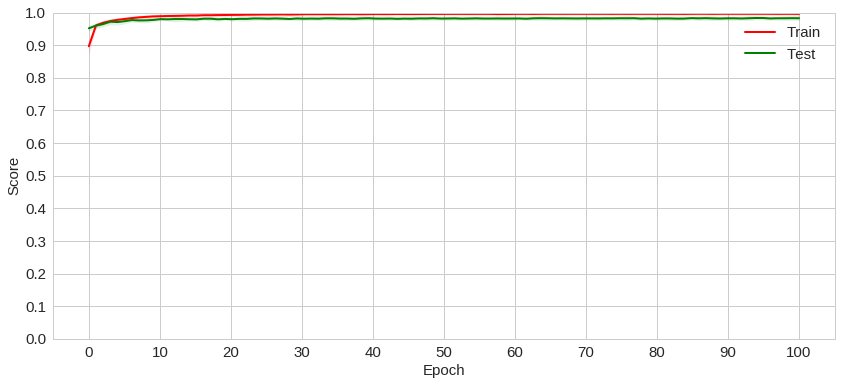

In [27]:
plot_mean_acc(tophistory)

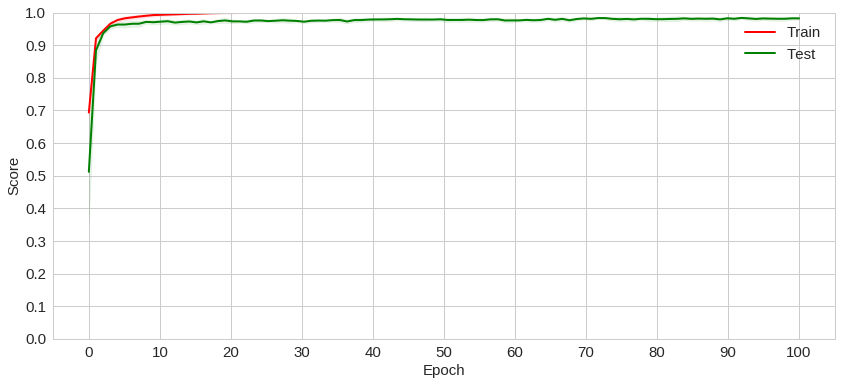

In [28]:
plot_mean_acc(history)

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

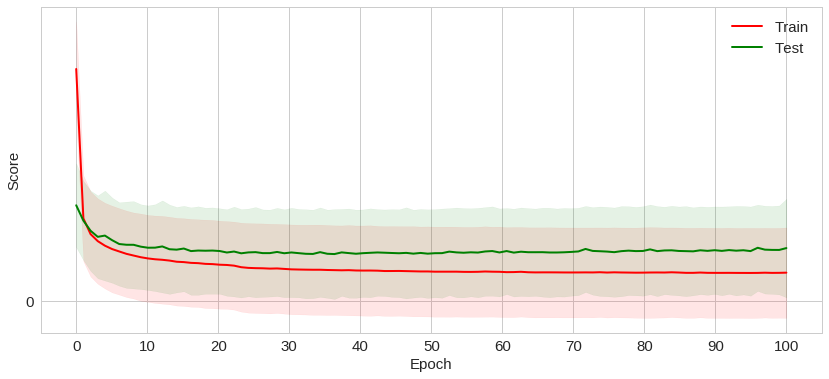

In [30]:
plot_mean_loss(tophistory)

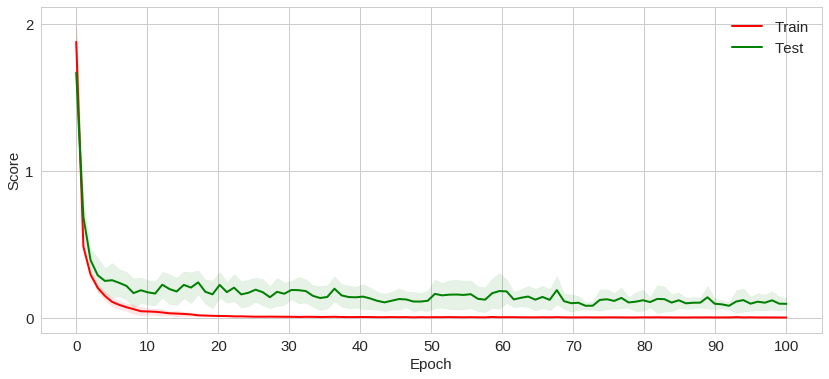

In [31]:
plot_mean_loss(history)

In [33]:
tophist = [{'acc': [0.83881343817012155, 0.94996426018584701, 0.95961401000714797, 0.96461758396015984, 0.96890636165851574, 0.97438646649530392, 0.97522039549220652, 0.98213009292351683, 0.98451274720038118, 0.98665713604955918, 0.98677626876340241, 0.98903979032642364, 0.99249463902787705, 0.99035025017869904, 0.99249463902787705, 0.9918989754586609, 0.99451989516321182, 0.99332856802477965, 0.99332856802477965, 0.99606862044317368, 0.99690254944007628, 0.99523469144627119, 0.99535382416011442, 0.99547295687395754, 0.99547295687395754, 0.99618775315701691, 0.99773647843697877, 0.99630688587086014, 0.99487729330474151, 0.99642601858470337, 0.99880867286156783, 0.997855611150822, 0.99892780557541105, 0.99833214200619491, 0.99797474386466523, 0.99702168215391951, 0.99809387657850845, 0.99892780557541105, 0.99845127472003814, 0.99821300929235168, 0.99928520371694063, 0.99857040743388137, 0.99559208958780077, 0.99904693828925428, 0.99928520371694063, 0.997855611150822, 0.99964260185847031, 0.99904693828925428, 0.99988086728615677, 0.99964260185847031, 0.99976173457231354, 0.99976173457231354, 1.0, 0.99964260185847031, 0.99988086728615677, 1.0, 0.9991660710030974, 0.99928520371694063, 0.99952346914462709, 0.99976173457231354, 1.0, 1.0, 0.99976173457231354, 0.99976173457231354, 0.99976173457231354, 1.0, 1.0, 0.99988086728615677, 0.99988086728615677, 0.99964260185847031, 0.99988086728615677, 0.99976173457231354, 1.0, 0.99988086728615677, 1.0, 0.99880867286156783, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988086728615677, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988086728615677, 1.0, 0.99940433643078386, 1.0], 'loss': [0.64628778857995361, 0.17114173036183181, 0.12245968218084202, 0.10006810466618887, 0.085061450174430286, 0.069926398920109642, 0.071032065978952327, 0.05411118934184405, 0.051233511852144427, 0.044975138861177391, 0.042533579371001481, 0.036029839681402429, 0.033526809612492776, 0.032178917770026121, 0.030025699504974884, 0.029625236657211788, 0.024910644998461937, 0.024678368181521009, 0.023582597004586096, 0.020387828144585913, 0.018221647325860572, 0.019034449471256633, 0.017773368241643092, 0.01778849731790812, 0.016055486829139688, 0.015383646973027753, 0.013095056216396908, 0.013418941722957789, 0.016221023831116638, 0.013015137324635582, 0.010420672869217027, 0.010491204041949823, 0.0093777276836189208, 0.0096458942520498518, 0.0093857700638343214, 0.0099675588497916932, 0.0088109006396920198, 0.0077302375357924929, 0.0079386345013640579, 0.0074281996807932481, 0.0068684604723687282, 0.0072862665190687416, 0.012952059460382253, 0.0061206134137814462, 0.0055289363851586584, 0.0074468713503043358, 0.0050645118960052238, 0.0058299584117927072, 0.0047206757040897948, 0.0045254093929699181, 0.0043726653594693202, 0.0039133537362764812, 0.0040722930063116876, 0.0041205151354022414, 0.0033931244806407637, 0.0037090889928688927, 0.0045495637510440511, 0.0042183584450758349, 0.0040803870756997021, 0.0037282131956137979, 0.0026358426201264005, 0.0027380329656064304, 0.0034087755975343247, 0.002812647070957706, 0.0025019330429378122, 0.0024418741943066724, 0.0023275022397451555, 0.0028344695578372092, 0.0021567471481394578, 0.0028070988825157459, 0.0023216636793901855, 0.0024650090478800656, 0.0019980190173829152, 0.0024453546636184682, 0.002129913297428745, 0.0043337109669332654, 0.0018910157829436821, 0.0015346459029778844, 0.0015062763550748462, 0.0013817208464065502, 0.00150665804793667, 0.0012728110297886821, 0.0014375936782362506, 0.0012079137592178762, 0.0016887547388561572, 0.0016399951331903912, 0.0011161662039807939, 0.00099314639219494024, 0.00096560504595396082, 0.0011141309749001882, 0.0011090978528527685, 0.0010791844328319974, 0.00088774141836565272, 0.0008838397165406908, 0.00078474934532013951, 0.00088429517927579582, 0.00096982943463076873, 0.0009279765630652516, 0.0021184535408089095, 0.0007922776518430912], 'val_acc': [0.93968253968253967, 0.95026455026455026, 0.946031746031746, 0.96719576719576716, 0.96613756613756618, 0.97037037037037033, 0.97671957671957677, 0.97037037037037033, 0.96296296296296291, 0.97989417989417993, 0.97989417989417993, 0.98095238095238091, 0.98624338624338626, 0.98412698412698407, 0.98095238095238091, 0.982010582010582, 0.982010582010582, 0.98518518518518516, 0.98095238095238091, 0.98095238095238091, 0.98306878306878309, 0.98412698412698407, 0.98730158730158735, 0.98624338624338626, 0.98624338624338626, 0.98412698412698407, 0.98518518518518516, 0.98730158730158735, 0.982010582010582, 0.98095238095238091, 0.98412698412698407, 0.98518518518518516, 0.98306878306878309, 0.98624338624338626, 0.98835978835978833, 0.98412698412698407, 0.98518518518518516, 0.98624338624338626, 0.98624338624338626, 0.98624338624338626, 0.98412698412698407, 0.98412698412698407, 0.98518518518518516, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.98624338624338626, 0.98835978835978833, 0.98835978835978833, 0.98518518518518516, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98835978835978833, 0.98624338624338626, 0.98730158730158735, 0.98730158730158735, 0.98941798941798942, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98412698412698407, 0.98624338624338626, 0.98730158730158735, 0.98624338624338626, 0.98518518518518516, 0.98624338624338626, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98518518518518516, 0.98730158730158735, 0.98730158730158735, 0.98518518518518516, 0.98624338624338626, 0.98835978835978833, 0.98730158730158735, 0.98730158730158735, 0.98624338624338626, 0.98835978835978833, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.98730158730158735, 0.98624338624338626, 0.98941798941798942, 0.98730158730158735, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.98624338624338626, 0.98624338624338626, 0.98730158730158735], 'val_loss': [0.25584392936693295, 0.17048305809970887, 0.15783003313989236, 0.11476178349010528, 0.097527672374059279, 0.12017152961442079, 0.084703060712606193, 0.077524376577801174, 0.093795873934314364, 0.070774973495296697, 0.069053133845171602, 0.064877515826275739, 0.05944800018948853, 0.055384073512894767, 0.059212925358029897, 0.058233595607930393, 0.056063681298857013, 0.045596289784504626, 0.062326897119009309, 0.05435797930670478, 0.046633244577854401, 0.046359394840580763, 0.044232168512803219, 0.040416718471460243, 0.044626264025767644, 0.048188465298523032, 0.040995016319076059, 0.038952499885782206, 0.048331164139958603, 0.052476270949694689, 0.042983748745074664, 0.044776824354218744, 0.041834333872609826, 0.041331458729371509, 0.03552146728135764, 0.044808445384518968, 0.04043175664572686, 0.042985960591594298, 0.039634041618752891, 0.041760378379729533, 0.042862790662341964, 0.042971622187609748, 0.046514207350149279, 0.041902855700916716, 0.051573245743260027, 0.040491789374894727, 0.04017750884347137, 0.037966119858963546, 0.039820751767955402, 0.041919668312997573, 0.04005414212797645, 0.041469023410580737, 0.039894595250324717, 0.038989974288072771, 0.037916663601235662, 0.040587694768451407, 0.039896471404640504, 0.042270661852687165, 0.042557095403773171, 0.038648396684534396, 0.040307694655921919, 0.040802994241079353, 0.045869847556216418, 0.043454342519016885, 0.046738028692798542, 0.043329075697862429, 0.046237645212932929, 0.043617696853455588, 0.041228078629035582, 0.046147945459018014, 0.042918884542477491, 0.043213174391905015, 0.044427297353681679, 0.045554982548642403, 0.047031655408400139, 0.045026111895007222, 0.041494275858655338, 0.045101914383044769, 0.047808859133803429, 0.048127905212012587, 0.042540768202962154, 0.044024716120948722, 0.048025034677847682, 0.047361054607955297, 0.045090231531538023, 0.046297824041820597, 0.047515135442883653, 0.045154420392430401, 0.047537060723590444, 0.043819142094993144, 0.045913080449884992, 0.046268101655128201, 0.047790542257253377, 0.046283017906542649, 0.04514289480989285, 0.048692117546025662, 0.055732508151194203, 0.057960488061142207, 0.051659169668837129, 0.048575823614373806]},
{'acc': [0.90782422293676313, 0.96677384780278675, 0.97403834702870074, 0.9790401333809694, 0.98297010847141419, 0.98523282124568301, 0.98916279623675119, 0.99023460759795168, 0.99130641895915206, 0.992497320471597, 0.99333095153030848, 0.99368822208341845, 0.9940454924377754, 0.99428367274026441, 0.99618911516017628, 0.99547457425270935, 0.99654638561390974, 0.9984518280338216, 0.99761819697511012, 0.99523639395022034, 0.99702274621888765, 0.99773728712635468, 0.99797546742884369, 0.99821364773133259, 0.99797546742884369, 0.99845182813319822, 0.99642729546266529, 0.99916636894128852, 0.99880909848755506, 0.99797546742884369, 0.99928545909253308, 0.99952363939502198, 0.99892818863879962, 0.99952363939502198, 0.99928545909253308, 0.99928545909253308, 0.99940454924377753, 0.99880909848755506, 0.99892818863879962, 0.99964272954626654, 0.99952363939502198, 0.99988090984875555, 0.99880909848755506, 0.99988090984875555, 0.99940454924377753, 0.99976181969751099, 0.99964272954626654, 0.99988090984875555, 0.99976181969751099, 0.99976181969751099, 0.99988090984875555, 1.0, 0.99988090984875555, 0.99976181969751099, 0.99988090984875555, 1.0, 0.99916636894128852, 0.99916636894128852, 0.99988090984875555, 1.0, 1.0, 1.0, 0.99702274621888765, 0.99964272954626654, 1.0, 1.0, 0.99988090984875555, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988090984875555, 1.0, 0.99880909848755506, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976181969751099, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.39317552761002938, 0.10680669196512574, 0.073089027701894474, 0.057928121223827483, 0.049669227618411339, 0.044472946978043389, 0.037271452552809864, 0.035314067100847182, 0.030827205912976999, 0.028918404848060502, 0.025024635334295879, 0.024735460332692968, 0.022229845189507502, 0.021627985325285794, 0.017139703326385987, 0.017597544572318439, 0.015667324604704352, 0.013738131094703976, 0.013818702423483457, 0.015382196521469688, 0.013391292400046344, 0.011988016399586517, 0.011443993417845391, 0.01037756661900347, 0.011044881332874639, 0.009149687133780034, 0.012761980090217107, 0.0080853836935661696, 0.0078624774052729225, 0.0084813803515503602, 0.0071229284602163361, 0.0067154838652220793, 0.0067434635748157296, 0.0057436147372970795, 0.0058522945183653256, 0.0057266129706952419, 0.0055205157458426395, 0.0060686677619122787, 0.0059315689583189762, 0.0047277051253836327, 0.0046795117216843771, 0.0044357219646953706, 0.0059775238823621662, 0.0036558102333546219, 0.0042962339143622014, 0.0036623514233400712, 0.003945798148523417, 0.0030997494963684608, 0.0035680084676220089, 0.0030589770673815995, 0.0030344904690815765, 0.0027434560160285817, 0.0027716075229166038, 0.0030638836836452054, 0.0024516552666754969, 0.0023432714183948692, 0.0036052238569216073, 0.0039247372796022782, 0.0020102484729527521, 0.0018626766069883712, 0.0016417884630213981, 0.0019246719185171915, 0.0097936686093080382, 0.0028969389375340625, 0.0014272416425307436, 0.0016795026645972525, 0.0016613658263014241, 0.0013619456007794731, 0.0014955470180463639, 0.0012131407180208712, 0.0013180830531549217, 0.0012818302807230913, 0.0014230238012221258, 0.0016044024726322922, 0.0012340659741251611, 0.0041794091186309725, 0.0010801932248078112, 0.0012692141240394229, 0.00086445929482310618, 0.0010695421783103384, 0.0010300554359339339, 0.00085220416829292101, 0.00086444471531651416, 0.00089517123323702306, 0.0015436657722436031, 0.00067016125955716023, 0.00071057592251275842, 0.00072819121084071749, 0.0007611169860095424, 0.00061222050146781109, 0.00081877832787196356, 0.00061907374348549977, 0.00056302440676235109, 0.00056505319766176568, 0.00063341211036952317, 0.00059215272646946919, 0.00083292171622643008, 0.00078705749566331635, 0.00057374651595258922, 0.00058761049050804653], 'val_acc': [0.9575371549893843, 0.96178343949044587, 0.96496815286624205, 0.97558386411889597, 0.98195329087048833, 0.9713375796178344, 0.9713375796178344, 0.96602972399150744, 0.97983014861995754, 0.97983014861995754, 0.98089171974522293, 0.97983014861995754, 0.98407643312101911, 0.97983014861995754, 0.98407643312101911, 0.97664543524416136, 0.98407643312101911, 0.9851380042462845, 0.98089171974522293, 0.98089171974522293, 0.97876857749469215, 0.98089171974522293, 0.98301486199575372, 0.98301486199575372, 0.98407643312101911, 0.98195329087048833, 0.98301486199575372, 0.98195329087048833, 0.98301486199575372, 0.98195329087048833, 0.98195329087048833, 0.98407643312101911, 0.9851380042462845, 0.98407643312101911, 0.9851380042462845, 0.9851380042462845, 0.98407643312101911, 0.98301486199575372, 0.98407643312101911, 0.98407643312101911, 0.98301486199575372, 0.98407643312101911, 0.98407643312101911, 0.98195329087048833, 0.9851380042462845, 0.98089171974522293, 0.98407643312101911, 0.98407643312101911, 0.98301486199575372, 0.98407643312101911, 0.98407643312101911, 0.9851380042462845, 0.9861995753715499, 0.98407643312101911, 0.98301486199575372, 0.98195329087048833, 0.98407643312101911, 0.98407643312101911, 0.98301486199575372, 0.98301486199575372, 0.98195329087048833, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911, 0.9861995753715499, 0.98407643312101911, 0.98301486199575372, 0.98407643312101911, 0.98301486199575372, 0.9851380042462845, 0.98301486199575372, 0.98195329087048833, 0.9861995753715499, 0.98407643312101911, 0.98301486199575372, 0.98195329087048833, 0.98301486199575372, 0.98195329087048833, 0.98301486199575372, 0.9851380042462845, 0.98195329087048833, 0.98407643312101911, 0.98301486199575372, 0.98301486199575372, 0.98407643312101911, 0.98301486199575372, 0.9861995753715499, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911, 0.98301486199575372, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911, 0.98407643312101911], 'val_loss': [0.12674585346235337, 0.085820511564802207, 0.07319916303777739, 0.08310324261597736, 0.079985048441955878, 0.069267317200882361, 0.068453688130984888, 0.061443194146851385, 0.060362742610687033, 0.053813657384255066, 0.051036631821945407, 0.050567069346967079, 0.051827921719940856, 0.050174207074148484, 0.054478579433387714, 0.052256469597996485, 0.050102453641277085, 0.054892475587254561, 0.05361916793405519, 0.054204151915008651, 0.049602328290008088, 0.048623058680966974, 0.04756158279431015, 0.057616674835593962, 0.053647697288018992, 0.048097545093700546, 0.051095260269376358, 0.04940910019462972, 0.05198419484608429, 0.050198275375431069, 0.048629358328776059, 0.05006059211868627, 0.044005788645075317, 0.046559540274841694, 0.048884068244243649, 0.047880048449339067, 0.047561396030642904, 0.054209295618486239, 0.047149298615969178, 0.054017887440991577, 0.052674227473133238, 0.054767341271743292, 0.050302452753068612, 0.053818339510682885, 0.048467445979191427, 0.052949685812668255, 0.050458735625164175, 0.058408186989408799, 0.058447144093879771, 0.048359644431371196, 0.048509751238801857, 0.050542402770043987, 0.059554476813636147, 0.05161738666319466, 0.05313025813524052, 0.058804591729183585, 0.05003821818559552, 0.05122765532793376, 0.052074817197672693, 0.0524588332297624, 0.059732535889774743, 0.053010572731709199, 0.063431989846360434, 0.054856356030079559, 0.055351264206224195, 0.055139620901906522, 0.055661150408208813, 0.057455053654809976, 0.055680381642395818, 0.058408328738695885, 0.056429791232413311, 0.061679145019011936, 0.06022594718943898, 0.059397554734158614, 0.058236018050635455, 0.059679267584064652, 0.064660754444867241, 0.063067828079997557, 0.068730866884990957, 0.061724702441296068, 0.061744422155478811, 0.064521554795492334, 0.05955637798178709, 0.072298140246865386, 0.061382476288493512, 0.062378427994993421, 0.064491907528469131, 0.064362711122756239, 0.063653598033126133, 0.064890811023040035, 0.063559557835627167, 0.064534588702418613, 0.06453228347477509, 0.064947104124647811, 0.064470260361765605, 0.064712150678828337, 0.066760052154524852, 0.065240995256139897, 0.06466287768847763, 0.063685387287831449]},
{'acc': [0.90441614093560285, 0.96309963099630991, 0.97357457445542195, 0.97821687894298293, 0.98262111653374595, 0.98714438757290801, 0.98583501976822807, 0.98988215688608494, 0.99202475896436193, 0.99261992619926198, 0.99511962874335003, 0.994405427925247, 0.99428639447684797, 0.99571479598534507, 0.99547672896083794, 0.99607189620283298, 0.99690513034162598, 0.99595286275443395, 0.99678609689322695, 0.99738126426293106, 0.99761933103202005, 0.99738126413522199, 0.99761933103202005, 0.99630996309963105, 0.99773836448041897, 0.99750029758362102, 0.99869063206761099, 0.99869063206761099, 0.99845256517081304, 0.99880966551601003, 0.99833353172241401, 0.99880966551601003, 0.997857397928818, 0.99845256517081304, 0.99880966551601003, 0.99880966551601003, 0.99892869896440895, 0.99916676586120701, 0.99916676586120701, 0.99880966551601003, 0.99773836448041897, 0.99976193310320205, 0.99976193310320205, 0.99964289965480302, 0.99952386620640399, 0.99714319723842404, 0.99928579930960604, 0.99976193311029693, 0.99892869896440895, 0.99988096655160097, 1.0, 0.99928579930960604, 0.99964289965480302, 1.0, 0.99988096655160097, 1.0, 0.99952386620640399, 1.0, 0.99976193310320205, 0.99964289965480302, 0.99952386620640399, 0.99964289965480302, 0.99952386620640399, 0.99988096655160097, 0.99988096655160097, 1.0, 0.99988096655160097, 1.0, 1.0, 0.99988096655160097, 0.99988096655160097, 0.99988096655160097, 1.0, 0.99857159861921196, 0.99976193310320205, 1.0, 0.99892869896440895, 0.99988096655160097, 1.0, 1.0, 0.99988096655160097, 1.0, 1.0, 0.99750029758362102, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988096655160097, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.39015042737220357, 0.10473327994179887, 0.072941169714309709, 0.061042774226545311, 0.051811883783212033, 0.04225315702858496, 0.041789876676474193, 0.035085689352949222, 0.029209895552786854, 0.029496484588636109, 0.023606283179799258, 0.024386676155054451, 0.022932028869953401, 0.02097521577225088, 0.020351415222177899, 0.017726244945749228, 0.01745096043128298, 0.016475838224526945, 0.01442697293521634, 0.013766705031133013, 0.013301184635437335, 0.011946613459257325, 0.011148994321175609, 0.013870674535753967, 0.010601167839426011, 0.011779618426117992, 0.0093084431156150692, 0.0089639584313150871, 0.0089492633761942292, 0.0080874335843655765, 0.008596617508583846, 0.0080944815827235402, 0.008922005444942465, 0.0071228729794217622, 0.0071062899942176926, 0.0068380858594725286, 0.0065343849515701359, 0.0063405296181292788, 0.0052094134125637275, 0.0058843773265439964, 0.0075361643419521764, 0.0049691961433377292, 0.0041049071708457972, 0.004270123873197417, 0.0046193707463186408, 0.0080667722154550148, 0.0047616448752312024, 0.0037267479884590424, 0.0051888114380408664, 0.0040564225163849431, 0.0029407698455335496, 0.003557345979895681, 0.003821604955382878, 0.0026860695562808679, 0.0027409248885927346, 0.0025419442865568889, 0.0033418394761314278, 0.0023657525148486156, 0.0027437591118767545, 0.0025951220022500938, 0.0039479644449345467, 0.0029771898537436052, 0.0026763020793883732, 0.0021500233002627817, 0.0019525644985408854, 0.0020993593739982281, 0.0020205959354100155, 0.0015296299281661338, 0.0018530700924451716, 0.0019459484292854354, 0.0019559381905007345, 0.0016388010389452345, 0.0014095739116581608, 0.0042264988574850894, 0.002076897311891493, 0.0015031731579509956, 0.003918447592188035, 0.0015008001472825803, 0.0012941223743761113, 0.0011948229183365623, 0.001482201363360032, 0.0010748264705040993, 0.0012345461425252613, 0.0081977132524252514, 0.0010541280396495799, 0.0010182017489129291, 0.00088398537529527023, 0.00091427420995421793, 0.0009389008128093887, 0.00099241282242454386, 0.00082195432884504458, 0.00075192155356713702, 0.00086080916841313644, 0.00078108451178293193, 0.00074909133713396486, 0.00073890201747071015, 0.00065498366436096884, 0.00083195644506075259, 0.00073153849339636608, 0.00065483620122454831], 'val_acc': [0.96268656716417911, 0.95842217484008529, 0.96481876332622596, 0.97974413646055436, 0.98400852878464817, 0.97014925373134331, 0.97761194029850751, 0.98400852878464817, 0.98400852878464817, 0.98187633262260132, 0.9850746268656716, 0.98294243070362475, 0.98827292110874199, 0.99040511727078895, 0.97974413646055436, 0.98294243070362475, 0.9850746268656716, 0.98827292110874199, 0.97867803837953093, 0.97867803837953093, 0.98081023454157779, 0.98400852878464817, 0.9850746268656716, 0.98720682302771856, 0.9850746268656716, 0.98827292110874199, 0.98827292110874199, 0.98827292110874199, 0.97867803837953093, 0.99040511727078895, 0.99040511727078895, 0.98400852878464817, 0.98294243070362475, 0.99147121535181237, 0.98933901918976541, 0.98933901918976541, 0.98933901918976541, 0.98187633262260132, 0.98933901918976541, 0.99040511727078895, 0.98720682302771856, 0.9850746268656716, 0.98400852878464817, 0.98081023454157779, 0.98187633262260132, 0.98720682302771856, 0.98933901918976541, 0.98400852878464817, 0.99040511727078895, 0.98187633262260132, 0.99040511727078895, 0.98933901918976541, 0.98187633262260132, 0.98294243070362475, 0.99040511727078895, 0.98187633262260132, 0.98400852878464817, 0.99040511727078895, 0.98294243070362475, 0.9850746268656716, 0.9850746268656716, 0.98294243070362475, 0.9850746268656716, 0.99147121535181237, 0.99040511727078895, 0.98187633262260132, 0.99040511727078895, 0.99040511727078895, 0.99040511727078895, 0.98933901918976541, 0.98294243070362475, 0.98614072494669514, 0.98933901918976541, 0.98720682302771856, 0.98933901918976541, 0.98933901918976541, 0.99040511727078895, 0.98400852878464817, 0.98614072494669514, 0.98187633262260132, 0.9850746268656716, 0.98933901918976541, 0.99040511727078895, 0.98720682302771856, 0.98720682302771856, 0.98827292110874199, 0.99040511727078895, 0.99040511727078895, 0.98400852878464817, 0.98933901918976541, 0.98827292110874199, 0.98614072494669514, 0.98933901918976541, 0.99040511727078895, 0.99040511727078895, 0.98933901918976541, 0.98720682302771856, 0.99040511727078895, 0.99040511727078895, 0.99040511727078895], 'val_loss': [0.1352899750190249, 0.10251934976100541, 0.10308583552188584, 0.072975455857773638, 0.067405804662085539, 0.055852382331649693, 0.062650157885351929, 0.050676189613208841, 0.057540756342475859, 0.043126887835458969, 0.048649332038303621, 0.049750766944267284, 0.04419579521876011, 0.042898192034680836, 0.048266205078820935, 0.044836915871088727, 0.040182482097238334, 0.037810769418615907, 0.041455061153582197, 0.04568262794278443, 0.04244540867580375, 0.03876454276201536, 0.040417358098523828, 0.036329858770558256, 0.044777670314213806, 0.042196276078153572, 0.040424763068764295, 0.03911649761001653, 0.042092315837500623, 0.033844681987380075, 0.03478132794151452, 0.035897035889182569, 0.036438096159282743, 0.032562484855263203, 0.036201163991364332, 0.033036359953684119, 0.037753096627650348, 0.045547270173229765, 0.034773081361970451, 0.033888982967220385, 0.040309351279466318, 0.038914549796442897, 0.041802424625970169, 0.038362540231559918, 0.041610187968797188, 0.033936392025662655, 0.035463867059696327, 0.037367009772245947, 0.036711301967769221, 0.036052526882055326, 0.036912269655398892, 0.033428034363455997, 0.040663785129504554, 0.042118323348171664, 0.039502179082541382, 0.04632316896217073, 0.034458389353367744, 0.039128307805536611, 0.040962228634319496, 0.047305834722203281, 0.046194307733702457, 0.044887840410020932, 0.039043375626493092, 0.037739841062591713, 0.036534372452337587, 0.040638609334960135, 0.035384405480998346, 0.036377265825800635, 0.038753916814589805, 0.034192028482631864, 0.045815847116304799, 0.042376937359749678, 0.034858702007637195, 0.038427737343975449, 0.033775231213994457, 0.033895550118605379, 0.043359775951188402, 0.04264719895327522, 0.03862681002941136, 0.040240248650421209, 0.040651620719579361, 0.03433554694857642, 0.03584809866951507, 0.033176379432920171, 0.040275075502022313, 0.03628608889213869, 0.035949119835360865, 0.035850460897652814, 0.042297647399401367, 0.0351784894093361, 0.036139650030678365, 0.038196199832361631, 0.038140411027425429, 0.037682654208567798, 0.037839297096272047, 0.035899121472484967, 0.038607029339484553, 0.037455371542474011, 0.036774055037177046, 0.035318272755723891]},
{'acc': [0.90301082947985356, 0.96179935742201983, 0.96417945971676777, 0.96929667975722955, 0.97477091519900427, 0.97524693561823161, 0.97750803284541232, 0.97917410448649289, 0.98119719147923357, 0.98119719147923357, 0.98417231945938743, 0.98179221706533382, 0.98143520176332644, 0.98500535523027488, 0.98369629894085442, 0.98512436036168149, 0.98464833997792034, 0.98607640128525531, 0.98750446269189573, 0.98679043203822836, 0.98441032964417474, 0.98619540640247527, 0.98643341663691542, 0.98809948832764871, 0.98857550874687616, 0.98762346780911581, 0.9869094371057956, 0.98679043198857552, 0.98798048316077591, 0.98809948827799599, 0.98809948832764871, 0.98857550874687616, 0.98809948827799599, 0.98881351903096903, 0.98833749851243602, 0.98714744734023563, 0.9888135189813162, 0.98821849339521595, 0.98845650362965609, 0.98905152921575623, 0.98952754968463641, 0.98905152921575623, 0.98952754968463641, 0.98928953945019638, 0.98798048316077591, 0.98940854456741645, 0.98869451386409613, 0.98833749851243602, 0.98940854456741645, 0.98905152926540907, 0.98928953945019638, 0.98952754968463641, 0.98952754968463641, 0.98964655485150932, 0.98940854456741645, 0.98952754969882295, 0.98952754968463641, 0.98821849339521595, 0.98833749851243602, 0.98798048316077591, 0.98952754968463641, 0.98952754968463641, 0.98940854461706917, 0.98964655480185648, 0.98964655480185648, 0.98964655480185648, 0.98964655480185648, 0.98964655480185648, 0.98964655480185648, 0.98952754968463641, 0.98964655480185648, 0.98952754973428925, 0.98952754968463641, 0.98964655480185648, 0.98940854456741645, 0.98964655480185648, 0.98964655485150932, 0.98964655480185648, 0.98928953945019638, 0.98964655485150932, 0.98940854456741645, 0.98928953945019638, 0.98964655480185648, 0.9888135189813162, 0.98952754968463641, 0.98964655485150932, 0.98964655480185648, 0.98964655480185648, 0.98940854456741645, 0.98964655480185648, 0.98964655480185648, 0.9891705343329763, 0.98964655480185648, 0.98952754973428925, 0.98964655480185648, 0.98964655485150932, 0.98964655480185648, 0.98964655480185648, 0.98964655480185648, 0.9888135189813162], 'loss': [0.54686025379811476, 0.25996270498359941, 0.23501839477218192, 0.22614164859768901, 0.21205915054025984, 0.20957956044984233, 0.20965111793226024, 0.2004720450088685, 0.19501986551698902, 0.19480658217126998, 0.19082872817204366, 0.1916052160045241, 0.19094177427801734, 0.18718023801327291, 0.1874163407516734, 0.18442946826185938, 0.18575835683530786, 0.18214215377891418, 0.18037325787926223, 0.18006125098713011, 0.18210557476146028, 0.17979701368578641, 0.17868659605131246, 0.17752420220235465, 0.17692760973856925, 0.17663379694457854, 0.17792749353506046, 0.17738932388263093, 0.17632844363399428, 0.17473388442244966, 0.17530177763359442, 0.17424822214850763, 0.17473361759941869, 0.17380970043592278, 0.17354948116428942, 0.17518963845506888, 0.17306919542100141, 0.17306129248906116, 0.17289286376645749, 0.17197245604972181, 0.17163353949593715, 0.17199703665853866, 0.17110032297065253, 0.17123127670890587, 0.17284324859326472, 0.17077611787953553, 0.17197378673121347, 0.17293839174474401, 0.17050541362096336, 0.17145094858518167, 0.17002977745529746, 0.17009878497657535, 0.17002569989817853, 0.16956079970013629, 0.16971903388180312, 0.16975730786408808, 0.17024927771663576, 0.17121528627269575, 0.17189091964725389, 0.1732836304858458, 0.16920355740738383, 0.16930709702131677, 0.16956335754494742, 0.16863482168711161, 0.16883012255977564, 0.16893815817886659, 0.16869971293772448, 0.16876135257458277, 0.16857722891055127, 0.16855618260394861, 0.16835196603740821, 0.1688293371092498, 0.16884520870504746, 0.16846009790191924, 0.16860332795766036, 0.16851167038460349, 0.16804891295005561, 0.16842882423709896, 0.16886693860886895, 0.16820163402623703, 0.16831017553724401, 0.16920682724634981, 0.16806196752529981, 0.16951830822548405, 0.16960076900153939, 0.16802994110411207, 0.16792458295086496, 0.16775135939548907, 0.16851278940580047, 0.16771347274145035, 0.16791690027658893, 0.16915817579373837, 0.16753677868573252, 0.16795131039167899, 0.1675641004679907, 0.16758683850937708, 0.1675683213590293, 0.16753536473417888, 0.16756977579389756, 0.16996167073816656], 'val_acc': [0.95405982905982911, 0.95940170940170943, 0.96260683760683763, 0.9754273504273504, 0.97435897435897434, 0.96367521367521369, 0.97649572649572647, 0.97435897435897434, 0.97008547008547008, 0.97329059829059827, 0.97649572649572647, 0.97649572649572647, 0.97649572649572647, 0.97649572649572647, 0.97756410256410253, 0.97756410256410253, 0.9786324786324786, 0.9786324786324786, 0.9754273504273504, 0.97756410256410253, 0.97649572649572647, 0.97756410256410253, 0.97115384615384615, 0.97649572649572647, 0.9786324786324786, 0.97649572649572647, 0.97756410256410253, 0.97756410256410253, 0.9786324786324786, 0.97756410256410253, 0.97649572649572647, 0.9786324786324786, 0.9786324786324786, 0.97756410256410253, 0.97756410256410253, 0.97756410256410253, 0.97649572649572647, 0.97649572649572647, 0.97649572649572647, 0.9786324786324786, 0.97649572649572647, 0.97649572649572647, 0.97756410256410253, 0.97756410256410253, 0.97649572649572647, 0.9786324786324786, 0.9786324786324786, 0.9786324786324786, 0.9786324786324786, 0.9786324786324786, 0.97756410256410253, 0.97756410256410253, 0.97649572649572647, 0.97649572649572647, 0.97649572649572647, 0.97756410256410253, 0.97649572649572647, 0.97649572649572647, 0.97649572649572647, 0.97649572649572647, 0.97756410256410253, 0.97970085470085466, 0.9786324786324786, 0.97649572649572647, 0.97970085470085466, 0.97970085470085466, 0.97756410256410253, 0.97756410256410253, 0.97649572649572647, 0.97756410256410253, 0.9786324786324786, 0.97756410256410253, 0.9786324786324786, 0.97756410256410253, 0.97756410256410253, 0.9786324786324786, 0.97756410256410253, 0.97756410256410253, 0.9786324786324786, 0.9786324786324786, 0.97756410256410253, 0.9786324786324786, 0.97756410256410253, 0.97756410256410253, 0.98076923076923073, 0.97756410256410253, 0.97756410256410253, 0.97649572649572647, 0.97649572649572647, 0.9786324786324786, 0.97649572649572647, 0.97756410256410253, 0.97756410256410253, 0.97756410256410253, 0.9786324786324786, 0.9786324786324786, 0.9786324786324786, 0.97756410256410253, 0.9786324786324786, 0.97756410256410253], 'val_loss': [0.25361967409371883, 0.24919538864364418, 0.23679198245080108, 0.22365606772418842, 0.22435393639338705, 0.22008474786073351, 0.21380814943765092, 0.22109925384040222, 0.21740403489416671, 0.21244449599379372, 0.212567333281279, 0.21031437445089668, 0.20799925291421226, 0.20880671251370198, 0.20714457194334787, 0.20624509179451239, 0.19988440979534808, 0.20068910348469901, 0.20188243732276237, 0.20260894649540687, 0.20735023362620766, 0.19997051162257171, 0.21166453786337605, 0.2031198917165733, 0.19970463394808272, 0.2198526601249384, 0.20077054536330283, 0.19863426854011093, 0.19947508742369147, 0.19979846493080339, 0.20161154281281324, 0.2023229700801486, 0.20047469706705903, 0.20214651450681456, 0.21162012304539063, 0.19948530373974199, 0.20508412912395449, 0.196124169145065, 0.20079175476979816, 0.19899480757860738, 0.19813494617113211, 0.20034923870097815, 0.19991418570712902, 0.19651694756929572, 0.19667501915160429, 0.19998954260437232, 0.20827856438532202, 0.19744773347014821, 0.20056837396415123, 0.2027173473175842, 0.19898044193168737, 0.20523963498287315, 0.19941273228460366, 0.2024056741441814, 0.20263532703411796, 0.19865766338762503, 0.19952125678524976, 0.20895296395741378, 0.21527508380036786, 0.19917278504496616, 0.19921356824619205, 0.1990977068062032, 0.20344068333445017, 0.20248851405690363, 0.20043049804915691, 0.19919403945647754, 0.20468514201334034, 0.19859729691729899, 0.20144233151326743, 0.19701506518465309, 0.20132371703762031, 0.19988406715265616, 0.20605501660238354, 0.20344122319172447, 0.20020548140109895, 0.20198084817300882, 0.2035017056355134, 0.21042067202400869, 0.19956375603807952, 0.20313382911569308, 0.2031754650748071, 0.20478145493490224, 0.2032135362698651, 0.21478090888049492, 0.20872929159527576, 0.20440521844811027, 0.20170203010090137, 0.20620929265459204, 0.20396081814185454, 0.20902159898252229, 0.20582763556097769, 0.2044985054025634, 0.20394607015463345, 0.20612318913308084, 0.20411576475162602, 0.2032355138067149, 0.20349528313012435, 0.20329441944891691, 0.20272145823009541, 0.20590381484098777]},
{'acc': [0.90278438841485231, 0.96620656830080909, 0.97429795335554503, 0.98048548310328421, 0.98155640171346981, 0.98441218467396474, 0.98952879581151831, 0.99143265111851497, 0.99036173250832937, 0.99357448831051653, 0.99250356972870057, 0.99571632555925749, 0.99357448831051653, 0.99345549738219896, 0.99619228938600668, 0.99428843407901002, 0.99535935268919562, 0.99559733460257016, 0.99690623512613041, 0.99773917182294147, 0.99571632555925749, 0.99702522608281774, 0.99678724416944309, 0.99773917179457183, 0.9978581627796288, 0.9978581627796288, 0.99821513564969067, 0.99797715367957673, 0.99678724416944309, 0.99726320799619228, 0.99809614469300334, 0.99857210851975253, 0.99928605425987627, 0.99857210851975253, 0.99833412660637788, 0.99916706330318894, 0.99750118990956682, 0.99976201808662546, 0.99857210849138289, 0.99904807234650161, 0.99952403617325081, 0.99916706330318894, 0.99976201808662546, 0.9989290813898144, 0.99940504521656359, 0.99988100904331267, 0.99988100904331267, 0.99964302712993813, 0.99928605425987627, 0.99952403617325081, 0.99988100904331267, 0.99976201808662546, 0.99964302712993813, 0.9989290813898144, 0.99940504521656359, 1.0, 0.99988100904331267, 0.99988100904331267, 0.99916706330318894, 0.99964302712993813, 1.0, 1.0, 0.99988100904331267, 0.99988100904331267, 1.0, 1.0, 0.99988100904331267, 1.0, 1.0, 1.0, 0.99940504521656359, 0.99964302712993813, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976201808662546, 0.99976201808662546, 0.99964302712993813, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976201808662546, 0.99988100904331267, 0.99940504521656359], 'loss': [0.41587246531023975, 0.10400696363794781, 0.069770079267444871, 0.060472245753229882, 0.049858735342807485, 0.046471847125507719, 0.037314268996427521, 0.032809111135863281, 0.036808892387696412, 0.02744338146877652, 0.026917820561434304, 0.023155878297098049, 0.025264470169993596, 0.023162427622964981, 0.01874915407398722, 0.019534526000075089, 0.01811655251391725, 0.017205995598853146, 0.015144504004755172, 0.013385698810992839, 0.014793166359695919, 0.013191206970281796, 0.01239844956796533, 0.011910291573920175, 0.01160194564487489, 0.010537894868194616, 0.0097538028303569262, 0.0097244483725066298, 0.01120312570743635, 0.010497337877763696, 0.0086603299255834376, 0.0079570253131851752, 0.0069966175530435182, 0.0075873633978958428, 0.0079223837489364179, 0.006239553579576544, 0.0091081346499989405, 0.0055294582796576071, 0.0061963327175386601, 0.0054432315041172781, 0.0048859605393565299, 0.0050484309684855778, 0.0043100692842223077, 0.0062103720128302174, 0.0043784280472766628, 0.0043050600432997825, 0.0038009614456287174, 0.0036848095074554872, 0.0038403680125629969, 0.0037333468975787845, 0.0032448716041543783, 0.0034311211605259095, 0.0033139455571715203, 0.0040737240836675901, 0.0036105297762733918, 0.00290360593843495, 0.0025604091652586783, 0.0026282007112941293, 0.0036878859445183178, 0.0029850103676427502, 0.0021264393719324115, 0.0021053956642754462, 0.0020097521698232679, 0.0024383086089750949, 0.0017561488800641345, 0.0017006072329436169, 0.0018975846510266806, 0.0017772291998965387, 0.0015045954181596827, 0.0016350553889700372, 0.0028829859471012189, 0.0028621197544140913, 0.0013322699921836643, 0.0012636334031741838, 0.0013501188527700269, 0.0014358081157191363, 0.001563808872989037, 0.0011767179244268414, 0.0010587715053488047, 0.0010339013142882699, 0.0016589162436332545, 0.0016838631868373896, 0.0018135991456867803, 0.00089124707460682372, 0.00098381338860178123, 0.00080243445375196415, 0.000882809208616812, 0.00083719987708085375, 0.00083004952654280634, 0.00085678672482162493, 0.00093799235617016857, 0.00078892997075363184, 0.00085549134896668194, 0.00071318963769025307, 0.00066604534088326322, 0.00062650441979348432, 0.00077147321737918719, 0.0016559003881467037, 0.0019631751093540451, 0.0030076482014167391], 'val_acc': [0.95721925133689845, 0.96684491978609621, 0.97112299465240637, 0.97005347593582891, 0.97112299465240637, 0.98181818181818181, 0.98288770053475938, 0.98288770053475938, 0.97967914438502679, 0.97967914438502679, 0.98181818181818181, 0.98288770053475938, 0.98181818181818181, 0.98181818181818181, 0.98288770053475938, 0.98288770053475938, 0.98395721925133695, 0.98181818181818181, 0.98395721925133695, 0.9850267379679144, 0.98074866310160425, 0.9850267379679144, 0.98395721925133695, 0.9850267379679144, 0.9850267379679144, 0.98609625668449197, 0.9850267379679144, 0.98181818181818181, 0.98395721925133695, 0.98395721925133695, 0.9850267379679144, 0.9850267379679144, 0.98609625668449197, 0.98288770053475938, 0.9850267379679144, 0.9850267379679144, 0.98395721925133695, 0.98609625668449197, 0.9850267379679144, 0.98609625668449197, 0.9850267379679144, 0.98395721925133695, 0.98395721925133695, 0.9850267379679144, 0.9850267379679144, 0.98395721925133695, 0.9850267379679144, 0.98609625668449197, 0.98609625668449197, 0.98395721925133695, 0.98288770053475938, 0.98395721925133695, 0.98395721925133695, 0.9850267379679144, 0.9850267379679144, 0.98716577540106953, 0.98395721925133695, 0.98609625668449197, 0.98609625668449197, 0.98609625668449197, 0.98395721925133695, 0.9850267379679144, 0.98716577540106953, 0.98609625668449197, 0.9850267379679144, 0.98716577540106953, 0.98716577540106953, 0.98609625668449197, 0.98609625668449197, 0.98609625668449197, 0.98609625668449197, 0.9850267379679144, 0.98395721925133695, 0.9850267379679144, 0.98609625668449197, 0.98716577540106953, 0.9850267379679144, 0.98609625668449197, 0.98609625668449197, 0.9850267379679144, 0.9850267379679144, 0.98609625668449197, 0.9850267379679144, 0.9850267379679144, 0.9850267379679144, 0.98609625668449197, 0.98716577540106953, 0.9850267379679144, 0.98609625668449197, 0.98609625668449197, 0.9850267379679144, 0.98609625668449197, 0.98609625668449197, 0.98716577540106953, 0.98609625668449197, 0.98609625668449197, 0.98609625668449197, 0.98716577540106953, 0.98395721925133695, 0.9850267379679144], 'val_loss': [0.1343349121578217, 0.099263632064934243, 0.086104814452243675, 0.056997736928894878, 0.081572545470201721, 0.053403789622778877, 0.047890203035770254, 0.047880945007072732, 0.04367787290244976, 0.058186520121115096, 0.056595421321490869, 0.050604281560044713, 0.058821426363871061, 0.042248434461354414, 0.040000424391146809, 0.047645297865657243, 0.039696347941818803, 0.053016955987674828, 0.037263943985064718, 0.038483639904621607, 0.050363679117159568, 0.037965242918281954, 0.034499598476278752, 0.035919061392784758, 0.039216406655841494, 0.032511466111051525, 0.034214881514223978, 0.036409310723610103, 0.044332724836789433, 0.033478848363726055, 0.036984593657288643, 0.036628205830201425, 0.034510363963865899, 0.040108518001877445, 0.038993419420825723, 0.033715708677801381, 0.03411579198144217, 0.034089386214397568, 0.043272787824093814, 0.036062653110372551, 0.034512247186014679, 0.033775833296903313, 0.047751427438722696, 0.042855624427251958, 0.033714134705733548, 0.03768835149021859, 0.032284706893917374, 0.034023184277351327, 0.037879932651490492, 0.034203220058399389, 0.038710993940675544, 0.039794104782500887, 0.039094829616351003, 0.034763495190838538, 0.033363397189081066, 0.032824502102059519, 0.032741871082602458, 0.038490513202990781, 0.037114009748955061, 0.036430591227421982, 0.043790173296627391, 0.034365298160673047, 0.036019111815578542, 0.04004052959489611, 0.040987523136670416, 0.035436264988107181, 0.033029906817632203, 0.034821329630735795, 0.033012853954628579, 0.041516629949070134, 0.047132019666060905, 0.046353401102105098, 0.054520261089238437, 0.036017730782483333, 0.039352331292347976, 0.036081641132944577, 0.036120099387206957, 0.039322296292555299, 0.038140320100707628, 0.038654684641894657, 0.048516661144934976, 0.037543666806214557, 0.041106967377966021, 0.036087215446430024, 0.037687236224750946, 0.035646925787976819, 0.039288663696314029, 0.041387432654009119, 0.036069461029367818, 0.047638024555736805, 0.044234068192747659, 0.039169218958198915, 0.033325172953988069, 0.048146774742964291, 0.035020853612194695, 0.046676420663366872, 0.044849150610560384, 0.036909993905866675, 0.048544667190163211, 0.045220739907361904]},
{'acc': [0.90611613514535716, 0.96811042357943611, 0.97417896239885771, 0.97643979057591623, 0.98155640171346981, 0.9852451213707758, 0.98691099476439792, 0.99024274155164205, 0.99167063303188963, 0.99381247025226083, 0.99416944312232269, 0.99286054259876244, 0.99428843407901002, 0.99452641599238456, 0.99476439790575921, 0.99607329842931935, 0.99571632555925749, 0.99690623512613041, 0.99762018086625415, 0.99797715373631601, 0.99702522608281774, 0.99524036173250829, 0.99797715373631601, 0.99857210851975253, 0.99773917182294147, 0.99845311756306521, 0.99678724416944309, 0.99881009043312707, 0.99738219895287961, 0.99762018086625415, 0.99857210849138289, 0.99833412660637788, 0.99845311756306521, 0.99857210851975253, 0.99916706330318894, 0.99857210851975253, 0.99928605425987627, 0.99881009043312707, 0.9989290813898144, 0.99762018086625415, 0.9989290813898144, 0.99952403617325081, 0.99952403614488117, 0.99857210851975253, 0.99762018086625415, 0.99952403617325081, 0.99809614469300334, 0.99964302712993813, 0.99952403617325081, 0.99928605425987627, 0.99928605425987627, 0.99976201808662546, 1.0, 0.99928605425987627, 0.99952403617325081, 0.9989290813898144, 1.0, 0.99928605425987627, 0.99928605425987627, 0.99988100904331267, 0.99988100904331267, 0.99940504521656359, 0.99952403617325081, 0.99988100904331267, 1.0, 0.99976201808662546, 0.99988100904331267, 0.99928605425987627, 0.99988100904331267, 1.0, 1.0, 1.0, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 0.99928605425987627, 1.0, 1.0, 1.0, 1.0, 0.99916706330318894, 0.9989290813898144, 0.99940504521656359, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976201808662546, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.40051424115016765, 0.099074222094271649, 0.076353874019852913, 0.062460376503835228, 0.056256577010837867, 0.043517695068745657, 0.039489621881870773, 0.034184873017213388, 0.032510628746020148, 0.027006842249180804, 0.025980430083798828, 0.026081465317228048, 0.022091504615261222, 0.021119373131752623, 0.019188729715026005, 0.017466612389822736, 0.017864614997284291, 0.016198453994982941, 0.014785838666580784, 0.013555010385179218, 0.01364662031732191, 0.01683072142767543, 0.011241497284422908, 0.010605425444448891, 0.010670310335818046, 0.0097708018511703954, 0.010827180920838104, 0.0089380155393507139, 0.010612379905664899, 0.0098724646430847357, 0.0085868555201356715, 0.0085801976703653478, 0.0074862291241177261, 0.0073765645293795501, 0.0072137075088482029, 0.007202992335547902, 0.0059353284642405307, 0.0057816184509274279, 0.0058969316870215276, 0.0073778509674460825, 0.0058255376888965227, 0.0047620617070220682, 0.0049218799165764316, 0.0055256165421768665, 0.006694966689907351, 0.004347454818778595, 0.0064365674760627047, 0.0039301323783518553, 0.0039548808462768863, 0.0040814003478053043, 0.0036812328005644862, 0.0034087990899448386, 0.0031530923847127254, 0.0039232088349757804, 0.0036827083841065519, 0.0038069344416809493, 0.0027811620128185871, 0.0032627250302604258, 0.0029837086881869521, 0.0022154892613044782, 0.0021662473101388292, 0.0031071368577664693, 0.0024939381402855369, 0.0022417946904199531, 0.0020453217184469847, 0.0025240541478997536, 0.0019901457849623144, 0.0031500689231215508, 0.0024226421981599793, 0.0020972099220709318, 0.0018888933212905927, 0.0014398737159989391, 0.0016462966882718648, 0.0015073147669313976, 0.0014404676600585672, 0.0014222282911043548, 0.001786381248103234, 0.0029385948224078069, 0.0011681729075959887, 0.0011283198757401213, 0.0011475567181146074, 0.0010581781653391084, 0.0031696387172159041, 0.0034226618756716099, 0.0042696952218797563, 0.00090757216075187876, 0.00099298375213226404, 0.00087042223824460062, 0.00090544967191703418, 0.0010970850411418486, 0.0010457829132458005, 0.00099583043030767693, 0.0016905559078691729, 0.00089611828177213189, 0.00072082268027444656, 0.0007489649860963211, 0.00068064613834978511, 0.00074419700063526565, 0.00082242275619077477, 0.00064678689349720016], 'val_acc': [0.95187165775401072, 0.94973262032085559, 0.96363636363636362, 0.97647058823529409, 0.97433155080213907, 0.97540106951871652, 0.97647058823529409, 0.97540106951871652, 0.98074866310160425, 0.97754010695187166, 0.98074866310160425, 0.97967914438502679, 0.98395721925133695, 0.98074866310160425, 0.97860962566844922, 0.97967914438502679, 0.98288770053475938, 0.97860962566844922, 0.98074866310160425, 0.98288770053475938, 0.98288770053475938, 0.98074866310160425, 0.98074866310160425, 0.98288770053475938, 0.98288770053475938, 0.98074866310160425, 0.98074866310160425, 0.98288770053475938, 0.98181818181818181, 0.98716577540106953, 0.97967914438502679, 0.98074866310160425, 0.98395721925133695, 0.98288770053475938, 0.97860962566844922, 0.98074866310160425, 0.98395721925133695, 0.98288770053475938, 0.98288770053475938, 0.98395721925133695, 0.9850267379679144, 0.98288770053475938, 0.98609625668449197, 0.98288770053475938, 0.98288770053475938, 0.97967914438502679, 0.98288770053475938, 0.9850267379679144, 0.98288770053475938, 0.98609625668449197, 0.98181818181818181, 0.98395721925133695, 0.98395721925133695, 0.98395721925133695, 0.98395721925133695, 0.9850267379679144, 0.9850267379679144, 0.98395721925133695, 0.9850267379679144, 0.98395721925133695, 0.98395721925133695, 0.97967914438502679, 0.98609625668449197, 0.98716577540106953, 0.98395721925133695, 0.9850267379679144, 0.98395721925133695, 0.98074866310160425, 0.97967914438502679, 0.97967914438502679, 0.98395721925133695, 0.9850267379679144, 0.98395721925133695, 0.98395721925133695, 0.9850267379679144, 0.9850267379679144, 0.9850267379679144, 0.98288770053475938, 0.98609625668449197, 0.98288770053475938, 0.98288770053475938, 0.98288770053475938, 0.97860962566844922, 0.98288770053475938, 0.9850267379679144, 0.98609625668449197, 0.98609625668449197, 0.9850267379679144, 0.98609625668449197, 0.98395721925133695, 0.98395721925133695, 0.98288770053475938, 0.98716577540106953, 0.98716577540106953, 0.98609625668449197, 0.98395721925133695, 0.98609625668449197, 0.98181818181818181, 0.9882352941176471, 0.98716577540106953], 'val_loss': [0.1428192092668524, 0.10771381800326912, 0.087330001867550577, 0.08045111845999478, 0.088709832417136203, 0.08442488056333626, 0.069361183301789711, 0.075203926752714867, 0.061723282512894925, 0.06609651288914091, 0.065372806635590641, 0.062945399850726447, 0.05836574753875879, 0.06078214982429888, 0.057333985123195673, 0.06241447429924725, 0.05741601833988997, 0.057013673187148839, 0.054212192887251071, 0.054531686250269815, 0.054277538032803864, 0.055557231139516168, 0.055032051247943012, 0.052204356347285409, 0.057074461586619003, 0.055189964224031586, 0.056186797764565657, 0.052962545595345967, 0.051756107415580614, 0.05337237143505584, 0.053974921442194776, 0.05502155564157641, 0.048357582927238255, 0.052769337619224033, 0.065213200862751022, 0.054011753536163165, 0.051126565462112784, 0.0539425416781074, 0.053262627728402935, 0.049862042737048973, 0.051014279292891408, 0.051283873841515122, 0.04974772180548874, 0.050920219269747984, 0.054197945316878701, 0.060364711702705416, 0.055632522158364561, 0.050439856070801016, 0.052439854923887225, 0.04936157046427532, 0.053604259176078917, 0.050404582429057196, 0.052016402496788204, 0.053230907169904029, 0.053802715219404142, 0.052915607396429802, 0.049720171913734942, 0.051478237371358218, 0.051357365918223111, 0.052603821396294805, 0.054233636012201866, 0.05447187395364838, 0.049776656721780242, 0.052287022202517859, 0.052268874878312811, 0.051522361824941389, 0.052849224340316921, 0.054728813111899734, 0.05770157583084027, 0.061167218798096355, 0.05447598349767268, 0.054240442544461871, 0.053214828730668226, 0.054004828799473943, 0.054515917434227616, 0.054898774838896797, 0.05118753483091272, 0.053303575585907537, 0.050710256987924932, 0.055177274090004461, 0.056431771119214366, 0.053504657182871444, 0.062943500741749883, 0.06082463095056137, 0.053788941177831499, 0.051240199470499105, 0.05068988657727206, 0.052183989735267992, 0.051333661741581917, 0.0518168162618741, 0.051468057085536291, 0.067074265844070502, 0.049421225471023185, 0.050813693987196831, 0.050643402731947132, 0.051598895156167661, 0.051207585209416193, 0.057833636947356944, 0.050983192599634741, 0.051023363020440859]},
{'acc': [0.90960989545119819, 0.96527117031398668, 0.97312083741123623, 0.97882968601332065, 0.98453853472882968, 0.9863225499524263, 0.98822549952426264, 0.98798763082778307, 0.99036631790600316, 0.99310180780209323, 0.9926260705225588, 0.99476688879087471, 0.99583729792503262, 0.9940532825880114, 0.99571836346336817, 0.99583729781160801, 0.99583729781160801, 0.99548049476688871, 0.99738344433872506, 0.99702664129400576, 0.99571836346336817, 0.99750237868696479, 0.99762131303520452, 0.99762131303520452, 0.99774024749686896, 0.99750237868696479, 0.99845385347288296, 0.9989295908658421, 0.99845385347288296, 0.99785918173168409, 0.9996431969552807, 0.99881065651760226, 0.99881065651760226, 0.99940532825880113, 0.99940532825880113, 0.99940532825880113, 0.9989295908658421, 0.9992863939105614, 0.99881065651760226, 0.99952426260704086, 0.9996431969552807, 0.99845385347288296, 0.99976213130352043, 0.9996431969552807, 0.9996431969552807, 0.99904852521408183, 0.99881065651760226, 0.99940532825880113, 0.99976213130352043, 0.99988106565176027, 1.0, 1.0, 0.9992863939105614, 0.9996431969552807, 0.99988106565176027, 0.99952426260704086, 0.99988106565176027, 0.99881065651760226, 0.99916745956232156, 1.0, 0.9996431969552807, 0.99976213130352043, 0.99988106565176027, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996431969552807, 0.9996431969552807, 0.99881065651760226, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9992863939105614, 0.99988106565176027, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976213130352043, 0.99785918173168409, 1.0, 1.0, 1.0], 'loss': [0.39796409878585592, 0.10665058862988604, 0.074911611798005831, 0.059960762841882211, 0.048715940459527707, 0.044531708664759695, 0.038179496942986543, 0.039292819565826663, 0.033317974601100447, 0.026736267523567142, 0.025984446596988717, 0.023287099921680654, 0.022005077990234521, 0.023446948468670972, 0.019349078244603215, 0.017861228762327434, 0.017523429203214928, 0.017211043161581972, 0.014116420889083653, 0.014169198445812733, 0.013975476940471739, 0.012327732751367492, 0.012034671408585941, 0.011660613238343616, 0.01063168209691228, 0.010891590904547247, 0.00934557329250108, 0.009502517916333041, 0.0085416984503231871, 0.00874776975672646, 0.0068683627971601307, 0.0073772733570293628, 0.0073089041152559608, 0.0063804361367107258, 0.0065405009851412588, 0.0062085081070845857, 0.006251124825087561, 0.0057505035470970878, 0.006566856949892317, 0.0052582678576926041, 0.004854760895798658, 0.0066031224903090992, 0.0045316331544899861, 0.0039814066493637388, 0.0041739957429934738, 0.0050131394454192985, 0.0051636449309450522, 0.0041036121202739119, 0.0032637661307887106, 0.003132623564172802, 0.002843890825289166, 0.0027855716459187266, 0.0035541043909254185, 0.0029766708439646675, 0.0028190040447174099, 0.0031967301521588515, 0.0024695176160909149, 0.0043199424144577548, 0.0037648113826369524, 0.002184252291217758, 0.0025679885137176671, 0.0029490308305642945, 0.0018459249000516069, 0.0017726029169763023, 0.0016606909155998056, 0.0016540015885273224, 0.0015583436086189137, 0.0014581821338724625, 0.0016301967014816035, 0.0014521646291548323, 0.0015387463303181837, 0.0027734264225205431, 0.0027953476562143898, 0.0049357462339754531, 0.0011752804232403268, 0.0012604854401035081, 0.0011386130370843676, 0.0010738329650075121, 0.0011444477363887829, 0.0012148479727191229, 0.0014706811376669104, 0.0023416160640268445, 0.0011738305003692411, 0.00091842630271493371, 0.00087118758059587047, 0.00088618088652458234, 0.00097957461926493294, 0.001594223929455036, 0.0010805456180178199, 0.00079111556237768186, 0.00075339611344865253, 0.00065608251994450466, 0.00071311726796825803, 0.00070811151153309191, 0.00066134091523294505, 0.0018915092554099577, 0.0058579883946097084, 0.00090520618991065879, 0.00054542112886838323, 0.00052092606292596241], 'val_acc': [0.95488721804511278, 0.96348012889366275, 0.96777658431793767, 0.97959183673469385, 0.97314715359828141, 0.98711063372717511, 0.98066595059076267, 0.97636949516648763, 0.97959183673469385, 0.96885069817400649, 0.98281417830290008, 0.98066595059076267, 0.98711063372717511, 0.98066595059076267, 0.98496240601503759, 0.98066595059076267, 0.98388829215896889, 0.98388829215896889, 0.98066595059076267, 0.98496240601503759, 0.98281417830290008, 0.98388829215896889, 0.98281417830290008, 0.9860365198711063, 0.98496240601503759, 0.98281417830290008, 0.98281417830290008, 0.98281417830290008, 0.98281417830290008, 0.9860365198711063, 0.98281417830290008, 0.98711063372717511, 0.9860365198711063, 0.98066595059076267, 0.98174006444683137, 0.98281417830290008, 0.98281417830290008, 0.98281417830290008, 0.98281417830290008, 0.98281417830290008, 0.98174006444683137, 0.98388829215896889, 0.98281417830290008, 0.98281417830290008, 0.98066595059076267, 0.98066595059076267, 0.98066595059076267, 0.98281417830290008, 0.98388829215896889, 0.98066595059076267, 0.98066595059076267, 0.98066595059076267, 0.98174006444683137, 0.98281417830290008, 0.98281417830290008, 0.98281417830290008, 0.98174006444683137, 0.98066595059076267, 0.98281417830290008, 0.98174006444683137, 0.98281417830290008, 0.98174006444683137, 0.98174006444683137, 0.98066595059076267, 0.98066595059076267, 0.98174006444683137, 0.98066595059076267, 0.98066595059076267, 0.98174006444683137, 0.98281417830290008, 0.98174006444683137, 0.98388829215896889, 0.98388829215896889, 0.98066595059076267, 0.98281417830290008, 0.98174006444683137, 0.98388829215896889, 0.98066595059076267, 0.98174006444683137, 0.98388829215896889, 0.98281417830290008, 0.98174006444683137, 0.97851772287862515, 0.98281417830290008, 0.98388829215896889, 0.97851772287862515, 0.98281417830290008, 0.97959183673469385, 0.98066595059076267, 0.98281417830290008, 0.98281417830290008, 0.98281417830290008, 0.98066595059076267, 0.98281417830290008, 0.98281417830290008, 0.98066595059076267, 0.98174006444683137, 0.98281417830290008, 0.98174006444683137, 0.98174006444683137], 'val_loss': [0.12657711728827109, 0.11641080488493841, 0.083403663918832124, 0.074452374288542192, 0.060814790715784571, 0.055365127374275028, 0.061805364251672969, 0.061074490708956208, 0.057381984067502584, 0.058917294407441458, 0.051890471980183775, 0.056244038189456232, 0.044247422774975557, 0.048259893660838729, 0.04801404508176859, 0.056901002977499546, 0.045430680935218064, 0.043774659927458243, 0.049198615077630917, 0.049490613874126024, 0.0499609276366237, 0.04523558037857716, 0.043795999899810673, 0.045478771794057189, 0.046255391607537194, 0.044930095452626231, 0.05540636489512929, 0.05008147737445464, 0.047539181953043977, 0.045118995416118184, 0.043759897196086209, 0.042799126203912165, 0.045085207041989206, 0.047388400102587401, 0.052155837790778446, 0.046388034545491369, 0.043122753503501803, 0.052837548852236953, 0.046906299832318012, 0.045153667101504986, 0.051300782953397989, 0.046960968939423919, 0.048359983502454539, 0.045912795824488421, 0.047273635957665164, 0.048602118122057038, 0.047832636040596392, 0.047444406791480619, 0.046926026625801816, 0.04888814733757324, 0.050539011381313684, 0.049307883165709956, 0.059502225171521539, 0.047507347829199006, 0.05282802417540846, 0.054394383873817009, 0.065320781938048689, 0.054742362922673725, 0.056160474115079587, 0.052953349227476097, 0.0689390610490421, 0.052300139489710837, 0.054253495173329599, 0.055882869737011967, 0.049946776730836584, 0.052427933909667074, 0.051285760188428987, 0.052300648628346103, 0.051857292480133051, 0.050279483403377817, 0.054745253227733895, 0.057512996728712955, 0.055409891440996513, 0.058090301245461225, 0.053121461259821631, 0.051094237041131849, 0.052209959239516698, 0.056138052965858103, 0.052993638243796749, 0.052764376004774009, 0.065654776556091352, 0.052852449210504256, 0.060671421720663012, 0.054697472502520265, 0.055432652655144139, 0.057495274678595783, 0.059170569282923975, 0.058826664345191765, 0.058446309081257704, 0.056132651808783005, 0.053230235480300807, 0.057610876211432252, 0.059254611796052618, 0.057171595667872728, 0.057636195297226314, 0.091450881333518863, 0.060816172580304265, 0.059730074102745168, 0.060538054377876856, 0.058285708356321839]},
{'acc': [0.89595719391610762, 0.94768133184714209, 0.95909631394035888, 0.96349583838697561, 0.96623067786378891, 0.9687277051129608, 0.97146254468899707, 0.97467300852187044, 0.97455410225921524, 0.97645659928656359, 0.97705112960760998, 0.97776456609208862, 0.97776456609208862, 0.97740784789946078, 0.97895362663495833, 0.97800237822050717, 0.97966706303438877, 0.97942925099101841, 0.97824019034892573, 0.97871581450653988, 0.98061831163311119, 0.98097502982573903, 0.98097502982573903, 0.98156956004756246, 0.98109393579072535, 0.98097502972651607, 0.98156956004756246, 0.98216409056705467, 0.98180737227520398, 0.9819262782401903, 0.9819262782401903, 0.98192627843863611, 0.98228299643281802, 0.98073721759809751, 0.98121284185493463, 0.98204518430439958, 0.98263971472466882, 0.98228299663126395, 0.98216409036860874, 0.98168846611177174, 0.9819262782401903, 0.98049940546967895, 0.98228299653204099, 0.98299643291729666, 0.98275862068965514, 0.98287752675386442, 0.98287752695231034, 0.98252080866045954, 0.98311533888228297, 0.98263971472466882, 0.98228299643281802, 0.98263971472466882, 0.9824019024970273, 0.98275862068965514, 0.9829964328180737, 0.9827586207888781, 0.98275862068965514, 0.98133174801836687, 0.9829964328180737, 0.98311533888228297, 0.98311533888228297, 0.98252080866045954, 0.98311533888228297, 0.98311533898150594, 0.9829964328180737, 0.98311533888228297, 0.9829964328180737, 0.98311533888228297, 0.98311533898150594, 0.98311533898150594, 0.98311533888228297, 0.98311533888228297, 0.98311533888228297, 0.98311533888228297, 0.98311533888228297, 0.98275862068965514, 0.9831153390807289, 0.98299643291729666, 0.98311533898150594, 0.98252080856123658, 0.98168846611177174, 0.9829964328180737, 0.98311533888228297, 0.98311533888228297, 0.98311533888228297, 0.98311533888228297, 0.98311533898150594, 0.98311533898150594, 0.98311533888228297, 0.98311533888228297, 0.98311533898150594, 0.98311533888228297, 0.98311533888228297, 0.98311533888228297, 0.9829964328180737, 0.98311533888228297, 0.9831153390807289, 0.98311533888228297, 0.98311533888228297, 0.98263971462544586], 'loss': [0.65145086106378036, 0.38065266111659662, 0.34298860069971165, 0.32959481935757662, 0.32187249554890374, 0.3171902438805092, 0.30825721353699986, 0.30527720936838709, 0.30218328106284637, 0.29880908635333092, 0.29629608551560771, 0.29582624403531715, 0.29432316621617105, 0.29353704170437972, 0.29065741458675171, 0.29067392880440324, 0.28819281061608498, 0.28848086179241839, 0.28937233582794597, 0.28798892959181605, 0.2849805833716455, 0.28433688219889164, 0.28381308591553628, 0.28351291451963356, 0.28293492394000042, 0.2823832866456692, 0.28184901987790495, 0.28081321072333915, 0.28057545880642004, 0.28078222837289141, 0.27992871804484004, 0.27959016676411902, 0.27948168262775086, 0.28117882811816525, 0.27973901060532763, 0.27860067306168368, 0.27790827266296081, 0.27798005191079928, 0.27808428608740965, 0.27853043855729376, 0.27894394364128805, 0.28044702625950008, 0.27738468490505547, 0.27646929861138286, 0.27604415737353843, 0.27629887579932505, 0.27589645467069573, 0.27596535617075907, 0.27562757811407884, 0.27592566963218762, 0.27611000756913073, 0.27567878182640787, 0.27636832411176171, 0.27575144310250399, 0.27492461605978258, 0.27497893995289802, 0.27515244408245959, 0.27770955865586999, 0.27438099875179089, 0.27466791748198238, 0.27432611999854967, 0.27517835859189366, 0.27425848744530285, 0.27406506058903951, 0.27415697163766289, 0.27421686973795961, 0.27396698609268583, 0.27384109656162026, 0.27378711459701982, 0.27374235746377634, 0.27357444212341175, 0.27350846036631316, 0.27363851349474144, 0.27361987021294348, 0.27364919947413369, 0.274156912134564, 0.27380969879216338, 0.27341319023217348, 0.27339313612801247, 0.27552895022768809, 0.27679609275988043, 0.27357448188754963, 0.27369975794394508, 0.27313299921735268, 0.27308564709036309, 0.273053812901632, 0.27314825417677674, 0.27302751093288924, 0.27295756259189841, 0.2732328028143316, 0.27296157425379391, 0.27303501312293837, 0.27284347623465949, 0.27286846333138498, 0.27334009665031289, 0.27293127962976682, 0.27280601820668737, 0.27287015396061792, 0.27287042850362581, 0.27397319568697209], 'val_acc': [0.93864370290635091, 0.9515608180839612, 0.96663078579117334, 0.95371367061356294, 0.9515608180839612, 0.96555435952637247, 0.96663078579117334, 0.96770721205597421, 0.96663078579117334, 0.97201291711517757, 0.9709364908503767, 0.96986006458557594, 0.95909580193756727, 0.96770721205597421, 0.9709364908503767, 0.96663078579117334, 0.9709364908503767, 0.96770721205597421, 0.96878363832077508, 0.97308934337997843, 0.96986006458557594, 0.96770721205597421, 0.96986006458557594, 0.96878363832077508, 0.96986006458557594, 0.96986006458557594, 0.9709364908503767, 0.96986006458557594, 0.9709364908503767, 0.96986006458557594, 0.97201291711517757, 0.96986006458557594, 0.96878363832077508, 0.97201291711517757, 0.9709364908503767, 0.96878363832077508, 0.96770721205597421, 0.96878363832077508, 0.9709364908503767, 0.97201291711517757, 0.96986006458557594, 0.9709364908503767, 0.96986006458557594, 0.96986006458557594, 0.97201291711517757, 0.96878363832077508, 0.9709364908503767, 0.96878363832077508, 0.9709364908503767, 0.9709364908503767, 0.9709364908503767, 0.96986006458557594, 0.97308934337997843, 0.9709364908503767, 0.96986006458557594, 0.9709364908503767, 0.97308934337997843, 0.96878363832077508, 0.96986006458557594, 0.96878363832077508, 0.9741657696447793, 0.96986006458557594, 0.9709364908503767, 0.9709364908503767, 0.9709364908503767, 0.9709364908503767, 0.9709364908503767, 0.97201291711517757, 0.96986006458557594, 0.97201291711517757, 0.97201291711517757, 0.96986006458557594, 0.97308934337997843, 0.9709364908503767, 0.97201291711517757, 0.96878363832077508, 0.97308934337997843, 0.96986006458557594, 0.97201291711517757, 0.96878363832077508, 0.9709364908503767, 0.96986006458557594, 0.96986006458557594, 0.96986006458557594, 0.9741657696447793, 0.96986006458557594, 0.9709364908503767, 0.96986006458557594, 0.9709364908503767, 0.96986006458557594, 0.9709364908503767, 0.9709364908503767, 0.96986006458557594, 0.9741657696447793, 0.97308934337997843, 0.9709364908503767, 0.97201291711517757, 0.96986006458557594, 0.9709364908503767, 0.96986006458557594], 'val_loss': [0.40729272408025946, 0.35389507204129794, 0.33463870597937101, 0.33163758213767147, 0.3661064090191179, 0.32406248122632136, 0.32030904159226542, 0.32455726081467323, 0.32917765523251891, 0.31387437382648803, 0.31328022883366896, 0.32051638468791227, 0.33495571956928694, 0.32549938594945482, 0.30870508542033742, 0.31617350667711064, 0.31746073244705963, 0.32239224854656229, 0.31068798926893515, 0.31310773578114542, 0.30684847310806984, 0.3087735328316063, 0.31472485546580042, 0.30900408032092602, 0.31119819809417004, 0.31117106000998079, 0.30933503084941349, 0.30599533774553167, 0.31563578620495375, 0.30720720875134094, 0.31619570044443751, 0.30812459542396986, 0.31081343361964014, 0.30736650418203454, 0.31211434854623088, 0.3084854611027204, 0.30927809070712065, 0.30808056417621565, 0.30969086166173498, 0.30745852128735396, 0.30884549764918057, 0.31348086379326084, 0.30884831756054132, 0.30879529659494465, 0.30763164060230419, 0.30795405619592026, 0.31453878963279686, 0.30782513787222582, 0.3077835815935997, 0.30677240106589948, 0.30948786658481259, 0.30891736815693571, 0.31025913674606159, 0.31630623169602107, 0.31304252435927793, 0.31080851464864268, 0.31563049342770999, 0.31282821895383112, 0.31154093088483037, 0.30965819603295353, 0.30863721022192281, 0.30943322970995035, 0.31113978677229509, 0.30935774162319962, 0.30906413888219902, 0.31117217928053426, 0.31105915916282184, 0.30986920148504532, 0.31108165167890067, 0.31127770438000102, 0.31023123734211788, 0.3129977776969371, 0.30925657774820292, 0.31324960662241758, 0.31593360416968047, 0.31107463622982956, 0.31193220755655521, 0.31111516944032402, 0.31372713597301349, 0.31887341102027744, 0.31874593183061956, 0.3137626039458612, 0.31079708333279688, 0.31048512196977229, 0.3095000730965608, 0.31693927062079746, 0.30988315009654377, 0.31005209720046856, 0.31103980847132751, 0.30963819770605183, 0.31249069021661985, 0.31146065438493892, 0.31405609250772609, 0.31351275103883192, 0.31379413662029992, 0.31562759697203374, 0.31377292641217319, 0.31360902286809184, 0.31745452982620498, 0.35563318378932951]},
{'acc': [0.90147373436578015, 0.96256239600665561, 0.97100071332390647, 0.9772997385310197, 0.98050867612950732, 0.97991442833372955, 0.9875207986688852, 0.98645115284050389, 0.9897789398621345, 0.99072973615402904, 0.98989778951196505, 0.99013548847159494, 0.99096743522700259, 0.99310672688376511, 0.99120513441332003, 0.99156168290943669, 0.99500831958089786, 0.99227478012835746, 0.99275017861433601, 0.99298787734727834, 0.99524601854052774, 0.99512716900404086, 0.99643451390539572, 0.99453292132160687, 0.99797955787972426, 0.99845495602567147, 0.99845495602567147, 0.99679106251485616, 0.99631566436890895, 0.99833610648918469, 0.99833610660252847, 0.99893035417161868, 0.99857380556215836, 0.99786070834323748, 0.99893035417161868, 0.99940575231756601, 0.99952460185405279, 0.99750415973377704, 0.99940575231756601, 0.99881150463513191, 0.99964345139053956, 0.99845495602567147, 0.99952460185405279, 0.99928690278107912, 0.99988115046351322, 0.99988115046351322, 0.99976230092702634, 0.99952460185405279, 0.99940575231756601, 0.99928690278107912, 0.99964345139053956, 0.99940575231756601, 1.0, 0.99940575231756601, 0.99976230092702634, 1.0, 1.0, 0.99833610648918469, 0.99893035417161868, 0.99881150463513191, 0.99976230092702634, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988115046351322, 1.0, 0.99988115046351322, 1.0, 0.99988115046351322, 1.0, 0.99988115046351322, 1.0, 1.0, 1.0, 0.99988115046351322, 1.0, 1.0, 1.0, 0.99988115046351322, 0.99726646066080338, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.45313643435486028, 0.14589827880351877, 0.11569689252305999, 0.09770330404612608, 0.088715292910073643, 0.085718731563923511, 0.075667070686447027, 0.075229811866216259, 0.069596759974956512, 0.06648949528841773, 0.066074421106423059, 0.06424648486257542, 0.063129920903827963, 0.058504977715114231, 0.058898828363181971, 0.059190425737569469, 0.054118822307272989, 0.059152052984383668, 0.055077532597199622, 0.056969019038890942, 0.051222916712861805, 0.051157481480936184, 0.049330299079953024, 0.018918732323978005, 0.011151879562001027, 0.009696362117964652, 0.0094754815084799066, 0.011603262884680041, 0.012186046110854413, 0.0088612466738635688, 0.0086699112034875417, 0.008127734336460999, 0.00745610966136188, 0.0081355444197473235, 0.0065185445912781369, 0.0058857697824386797, 0.006195539000094564, 0.0085825381414178468, 0.0057600340430164548, 0.0060128146768792211, 0.005046440202226791, 0.0062497923693468913, 0.004701844527910122, 0.0051623854044497647, 0.0045447497936782532, 0.0041455225797650333, 0.0038736437039818619, 0.0041379946162129434, 0.0037919915739924163, 0.004023494402582894, 0.0037231793162699179, 0.0039649332365690104, 0.0028592646751789247, 0.0040772038584072313, 0.0032489461618862357, 0.0027419601003470049, 0.0025866369488447621, 0.0046907827305262819, 0.0044627544901853205, 0.0044248540876227378, 0.0025192127350650486, 0.0021154578169092476, 0.0020979470528260631, 0.0019598333098360481, 0.0018399096408866422, 0.0018842439203174877, 0.0017005836373956138, 0.0018907559436546926, 0.0016040249339980804, 0.0014758412146914041, 0.0015971850765865037, 0.0019344970210512251, 0.0024479916480439376, 0.0020925126821244333, 0.0017296755385056266, 0.0013101829728380042, 0.0014753038084565253, 0.0012794280775482003, 0.0017226681978146407, 0.0011355740856752148, 0.00098745303922451264, 0.0012071768418664504, 0.0013920873981502703, 0.0012296618906360909, 0.0010571269025859656, 0.00091977397882914657, 0.0011828805855193113, 0.0071011014559947301, 0.0011906623281914823, 0.00097780107777633348, 0.00090041454012022783, 0.00069687278543809593, 0.00071584102863580276, 0.00086602969338138598, 0.00065265025644838505, 0.00081113258318549685, 0.00070354240133031049, 0.00079480738279913117, 0.00081528482881786568, 0.0007023587972426232], 'val_acc': [0.95783783783783782, 0.97729729729729731, 0.96756756756756757, 0.98378378378378384, 0.96864864864864864, 0.98270270270270266, 0.98594594594594598, 0.98486486486486491, 0.98486486486486491, 0.98594594594594598, 0.98378378378378384, 0.98594594594594598, 0.98270270270270266, 0.98594594594594598, 0.98270270270270266, 0.98594594594594598, 0.98594594594594598, 0.98594594594594598, 0.98810810810810812, 0.98594594594594598, 0.98594594594594598, 0.98810810810810812, 0.98810810810810812, 0.98702702702702705, 0.98810810810810812, 0.98702702702702705, 0.98810810810810812, 0.98702702702702705, 0.98702702702702705, 0.98594594594594598, 0.98270270270270266, 0.98702702702702705, 0.98378378378378384, 0.98810810810810812, 0.98810810810810812, 0.98594594594594598, 0.98594594594594598, 0.98702702702702705, 0.98918918918918919, 0.98810810810810812, 0.98702702702702705, 0.98594594594594598, 0.98702702702702705, 0.98378378378378384, 0.98810810810810812, 0.98810810810810812, 0.98702702702702705, 0.98594594594594598, 0.98810810810810812, 0.98810810810810812, 0.98594594594594598, 0.98810810810810812, 0.98378378378378384, 0.98810810810810812, 0.98702702702702705, 0.98594594594594598, 0.98594594594594598, 0.98378378378378384, 0.98810810810810812, 0.98702702702702705, 0.98702702702702705, 0.98594594594594598, 0.98810810810810812, 0.98702702702702705, 0.98702702702702705, 0.98594594594594598, 0.98702702702702705, 0.98702702702702705, 0.98702702702702705, 0.98810810810810812, 0.98918918918918919, 0.98810810810810812, 0.98702702702702705, 0.98810810810810812, 0.98702702702702705, 0.99135135135135133, 0.98702702702702705, 0.98702702702702705, 0.98702702702702705, 0.98810810810810812, 0.98810810810810812, 0.98810810810810812, 0.98594594594594598, 0.98594594594594598, 0.98810810810810812, 0.98810810810810812, 0.98810810810810812, 0.98702702702702705, 0.98702702702702705, 0.98594594594594598, 0.98810810810810812, 0.98702702702702705, 0.98810810810810812, 0.98702702702702705, 0.98810810810810812, 0.98378378378378384, 0.98702702702702705, 0.98918918918918919, 0.98918918918918919, 0.98918918918918919], 'val_loss': [0.15661523631899743, 0.15375057864028055, 0.087952374743448719, 0.087290987728818048, 0.091692016336160739, 0.07246484611888189, 0.065667381730635424, 0.063597914559414256, 0.061003985450275848, 0.060655955550437041, 0.057023885516902885, 0.055235491311429318, 0.066942048979973467, 0.059326397983004917, 0.056492791751752029, 0.062106304680676877, 0.050888068432340748, 0.051881243749647525, 0.050217875300629718, 0.053139784576220289, 0.051057130907334991, 0.047148948243844351, 0.051070117507431956, 0.031215879205060568, 0.030796599536630755, 0.033945698963125819, 0.030100395657575212, 0.040552752166986464, 0.035370513680516871, 0.032905190884563569, 0.047357275147947506, 0.034808909973582706, 0.038312600047101041, 0.028313981693338704, 0.034288979697519463, 0.033724078889181081, 0.025452057152130718, 0.034992836904082752, 0.031229922171002504, 0.032569321142006162, 0.032838618943367051, 0.036404488856174255, 0.035491595225207305, 0.042885501372904797, 0.028971976925040017, 0.029169324386638364, 0.029871280092141919, 0.03157569800912579, 0.032989131426501617, 0.03185968816399927, 0.033610765150798534, 0.030653294681672109, 0.040037592194622031, 0.038979285401921415, 0.032963505945407562, 0.029858043988021343, 0.035794770964232552, 0.046143756252210087, 0.044051266740063662, 0.03195355115178343, 0.030896211442871122, 0.031556047280507815, 0.032760208677563414, 0.030836818075858408, 0.037387023764423322, 0.032690383174167191, 0.030111786840087106, 0.033960983926096831, 0.03388591899379232, 0.032652349213446563, 0.028969396556620612, 0.067810149068717615, 0.03311816978466546, 0.031102732325812826, 0.034140307348271885, 0.029577839259605703, 0.029273679083562456, 0.033213195060615777, 0.034321805408871038, 0.033672797395131938, 0.033836956121030617, 0.034104801487913859, 0.036047673001326934, 0.033214159914759629, 0.033396140576868849, 0.033522511381180828, 0.031402604117583659, 0.045179864235290773, 0.035668033414655617, 0.045860635548074118, 0.035810347742120253, 0.036194717180592674, 0.037843377413621447, 0.036790926983041969, 0.035723204747789436, 0.054738864066610993, 0.036055785781795135, 0.035752466336562067, 0.032605142636945146, 0.03644260243648377]},
{'acc': [0.89947718631178708, 0.95686787072243351, 0.96756178707224338, 0.97457224334600756, 0.97528517110266155, 0.97849334600760451, 0.98146387832699622, 0.9832461977186312, 0.98431558935361219, 0.98336501901140683, 0.98467205323193918, 0.98633555133079853, 0.98514733840304181, 0.98574144486692017, 0.98681083650190116, 0.98621673003802279, 0.98716730038022815, 0.98740494296577952, 0.98740494296577952, 0.98740494296577952, 0.99001901140684412, 0.98978136882129275, 0.99001901140684412, 0.99013783269961975, 0.98966254752851712, 0.9891872623574145, 0.99013783269961975, 0.99061311787072248, 0.99049429657794674, 0.99096958174904948, 0.99096958174904948, 0.99096958174904948, 0.99061311787072248, 0.99108840304182511, 0.98906844106463876, 0.99049429657794674, 0.99108840304182511, 0.99108840304182511, 0.98835551330798477, 0.99120722433460073, 0.99085076045627374, 0.9914448669201521, 0.99132604562737647, 0.99120722433460073, 0.9914448669201521, 0.99108840304182511, 0.99132604562737647, 0.99108840304182511, 0.99132604562737647, 0.99108840304182511, 0.9914448669201521, 0.99132604562737647, 0.9914448669201521, 0.99120722433460073, 0.9914448669201521, 0.9914448669201521, 0.99108840304182511, 0.9914448669201521, 0.99096958174904948, 0.99132604562737647, 0.9914448669201521, 0.99132604562737647, 0.99132604562737647, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.99049429657794674, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.99132604562737647, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.99001901140684412, 0.99108840304182511, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.9914448669201521, 0.99132604562737647, 0.99096958174904948], 'loss': [0.53397661708153699, 0.24105945451914584, 0.20988879823781012, 0.19137837614566655, 0.18782485428730117, 0.17786698960858494, 0.1725781325555403, 0.17019135467424817, 0.16565797902190413, 0.16681513032334158, 0.16308157791351693, 0.15943738732118684, 0.16148249130030323, 0.16017026010858243, 0.15590307416975102, 0.15589484198996267, 0.15455937153613725, 0.15288310486490453, 0.15265485139372459, 0.15254737335671548, 0.14997498952950078, 0.14958326126884372, 0.14845268313769436, 0.1476627921078269, 0.14798279008881221, 0.14782198327956472, 0.14685710975386826, 0.14609554711642531, 0.14555647630711926, 0.14531446603027673, 0.14482651032178093, 0.14424816762520348, 0.14422214306112355, 0.14382781557377583, 0.14700492076706778, 0.14395526680650947, 0.14331023038290583, 0.14265568627924535, 0.1477204599805502, 0.14287286299898752, 0.1434340585322392, 0.14234743991153165, 0.14161902278291677, 0.14148411841641673, 0.14137447221973068, 0.1417050684464497, 0.14138261958774792, 0.14143977465961011, 0.14079220926153613, 0.14133297551437476, 0.14054461915582461, 0.14113387636603086, 0.14066327345790341, 0.14064307205384322, 0.14038405563833259, 0.1400597230463772, 0.14087117036077293, 0.14012379756333668, 0.14027668786256844, 0.14036690531237211, 0.13970389187569685, 0.14002299665669493, 0.14007501197051958, 0.13972273739576013, 0.13956092412802859, 0.13935856306054514, 0.14082591447221407, 0.13929913030160918, 0.13935390936342218, 0.13916542932138362, 0.13930139966980118, 0.13904698649892749, 0.1391925096448266, 0.13904529415749806, 0.13921444264864469, 0.13916516748023819, 0.1391819916107159, 0.13939937313566225, 0.13883584682790281, 0.13886830489833515, 0.13905119409452912, 0.14197829932200934, 0.14017227194127294, 0.1386315920895356, 0.13883677574105652, 0.13852973505844648, 0.13854996057267865, 0.13869418615109755, 0.13847015063873069, 0.13849155871456834, 0.13846194616827881, 0.13849154913920753, 0.13849151611403707, 0.13845525144898937, 0.13840789697807346, 0.13839050385490823, 0.13846118311346994, 0.13836748211641631, 0.13863157715662161, 0.13935212505617778], 'val_acc': [0.94582881906825567, 0.96424702058504874, 0.97508125677139756, 0.96099674972914406, 0.96533044420368364, 0.96966413867822321, 0.97724810400866735, 0.97833152762730224, 0.97508125677139756, 0.97724810400866735, 0.97833152762730224, 0.97616468039003246, 0.97399783315276278, 0.97616468039003246, 0.97508125677139756, 0.97833152762730224, 0.97616468039003246, 0.97833152762730224, 0.97724810400866735, 0.97724810400866735, 0.97724810400866735, 0.97724810400866735, 0.97616468039003246, 0.97941495124593714, 0.97616468039003246, 0.97724810400866735, 0.98049837486457203, 0.97616468039003246, 0.97724810400866735, 0.97724810400866735, 0.97833152762730224, 0.97616468039003246, 0.97616468039003246, 0.97941495124593714, 0.98049837486457203, 0.97833152762730224, 0.97833152762730224, 0.97616468039003246, 0.97724810400866735, 0.97616468039003246, 0.97833152762730224, 0.97833152762730224, 0.97833152762730224, 0.97833152762730224, 0.97833152762730224, 0.97833152762730224, 0.97724810400866735, 0.97724810400866735, 0.97616468039003246, 0.97833152762730224, 0.97833152762730224, 0.97833152762730224, 0.97724810400866735, 0.97833152762730224, 0.97833152762730224, 0.97724810400866735, 0.97833152762730224, 0.97941495124593714, 0.97724810400866735, 0.97833152762730224, 0.97724810400866735, 0.97724810400866735, 0.97724810400866735, 0.97833152762730224, 0.97833152762730224, 0.97724810400866735, 0.97941495124593714, 0.97941495124593714, 0.97833152762730224, 0.97833152762730224, 0.97833152762730224, 0.97724810400866735, 0.97616468039003246, 0.97724810400866735, 0.97724810400866735, 0.97724810400866735, 0.97833152762730224, 0.97724810400866735, 0.97724810400866735, 0.97833152762730224, 0.97616468039003246, 0.97616468039003246, 0.97833152762730224, 0.97724810400866735, 0.97616468039003246, 0.97941495124593714, 0.97833152762730224, 0.97724810400866735, 0.97833152762730224, 0.97833152762730224, 0.97941495124593714, 0.97833152762730224, 0.97616468039003246, 0.97833152762730224, 0.97833152762730224, 0.97833152762730224, 0.97724810400866735, 0.97833152762730224, 0.97724810400866735, 0.97616468039003246], 'val_loss': [0.25312319541004924, 0.23419605538688948, 0.21202864244434971, 0.21044517123419892, 0.20373223201126539, 0.21141126584201114, 0.1914155999741407, 0.18784103331177265, 0.18798061908764577, 0.19344265482318815, 0.18370591382115659, 0.18956400413380961, 0.20935235419315673, 0.18436699292803121, 0.18929049999524766, 0.18549877548699276, 0.18214186391352252, 0.18320258928287295, 0.18587847811170932, 0.18443856239248216, 0.18197469351831361, 0.18127691640315793, 0.18669303900911347, 0.18187387223241452, 0.18453500895303868, 0.18113951206172968, 0.17831782465154872, 0.18484366502141619, 0.18469593785667868, 0.18581588628534368, 0.1843385777455368, 0.1860387934584227, 0.18319673702486045, 0.18117612949282411, 0.18202392735371198, 0.18192267328029538, 0.18331171187394593, 0.18927868773413062, 0.19078306490134142, 0.18414103784555527, 0.18352713303656629, 0.18481874076953766, 0.18200118481249672, 0.1832207496725613, 0.18937549269243567, 0.18318865193680428, 0.18744241988111313, 0.18336690797844854, 0.18711438068921021, 0.1855698388877649, 0.18488804515545032, 0.18680433166502922, 0.18753699111592156, 0.18626955163117473, 0.18562788006177708, 0.18854160433193545, 0.1853174722060649, 0.18592789408600488, 0.18911098824459041, 0.18951526791151066, 0.18787594126988472, 0.18748506335035836, 0.19049984308018703, 0.18896998529925207, 0.18700525157168993, 0.1949068551304588, 0.18963134767102832, 0.18832001052846975, 0.18961760098267097, 0.18899638855258227, 0.18955244635329099, 0.1977249235585776, 0.19153634437788009, 0.19707363203699793, 0.19269663343266716, 0.19334959081286104, 0.20419515726517698, 0.19423801999554335, 0.19445234869656391, 0.18908663635009998, 0.20338490846871168, 0.19883885098242268, 0.19418711178899534, 0.19247189276995388, 0.19654311453116999, 0.19392366580273993, 0.19375684955859157, 0.1966672432240493, 0.19405513741545974, 0.19344497521458101, 0.19466269974695918, 0.19486475831517777, 0.19944686192678546, 0.19529445963009398, 0.19455763845283972, 0.19540349504452126, 0.19801269297601179, 0.19604091946235172, 0.19709073288616183, 0.20179057331644262]}]

In [34]:
hist = [{'acc': [0.71038837266133059, 0.92292113411503229, 0.94353109365251475, 0.96306885873700487, 0.98022396951622703, 0.98641887062187272, 0.99070764829182534, 0.99177984275901943, 0.9935668334240626, 0.9948772933331449, 0.99475816056249478, 0.9970216821823229, 0.99654515127014309, 0.9978556111792255, 0.997855611150822, 0.99880867286156783, 0.99857040740547787, 0.99857040740547787, 0.99892780560381444, 0.99821300929235168, 0.9991660710030974, 0.99904693828925428, 0.99916607097469401, 0.9986895401477246, 0.9995234691162237, 0.99964260185847031, 0.99952346914462709, 0.99988086728615677, 0.99952346914462709, 0.99976173457231354, 0.99976173457231354, 0.99988086728615677, 0.99928520371694063, 0.99976173457231354, 0.99952346914462709, 0.99988086728615677, 0.99928520373114238, 0.99988086728615677, 0.99964260185847031, 0.99952346914462709, 0.99988086728615677, 0.99940433648759075, 0.99976173458651529, 0.99833214200619491, 0.99988086725775338, 0.99952346915882884, 0.99904693828925428, 0.99988086728615677, 1.0, 0.99988086728615677, 0.99964260187267207, 0.99964260183006692, 0.99940433643078386, 1.0, 0.99988086728615677, 1.0, 0.99988086725775338, 0.99964260187267207, 0.99940433643078386, 1.0, 0.99988086728615677, 0.99940433643078386, 1.0, 1.0, 0.99988086728615677, 1.0, 0.99976173454391015, 0.99952346914462709, 0.99964260185847031, 0.99988086728615677, 1.0, 0.99952346914462709, 0.99988086728615677, 0.99988086725775338, 0.99988086728615677, 0.99988086728615677, 0.99976173457231354, 0.99976173457231354, 0.99964260191527721, 0.99976173454391015, 0.99988086728615677, 1.0, 1.0, 1.0, 0.99976173458651529, 0.99976173454391015, 0.99988086725775338, 0.99988086728615677, 0.99988086725775338, 0.99988086728615677, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976173458651529, 0.99988086728615677, 0.99988086725775338], 'loss': [1.7778925703683579, 0.48691287741139583, 0.27338376517718482, 0.21358356361932235, 0.1511565344459192, 0.093981300404107598, 0.054856704153459585, 0.054231107426678138, 0.034672440317931388, 0.02999447820113902, 0.031058437419287047, 0.022077615927813422, 0.018259190224432394, 0.018668903957023659, 0.015028329289631244, 0.012169264720729314, 0.012490484406401606, 0.010712618659760148, 0.0098644259084199812, 0.011264474143870823, 0.0070112393718511964, 0.0066651058154061265, 0.010444272698092054, 0.0099734390850809325, 0.0062348959762900391, 0.0069227650458042415, 0.005792817826169124, 0.0033071411149795987, 0.0041062191035823193, 0.0032047325099934017, 0.0048193267355980353, 0.0025970709986349204, 0.0047907076420096919, 0.0046227574375077947, 0.0030358719268016214, 0.0026140046861375093, 0.005494948702227268, 0.0024791338929472891, 0.0030475963258346701, 0.0050384471223876622, 0.0031278960235693824, 0.0037966395505500501, 0.003402735508178632, 0.0058764384092870907, 0.0031607297279317025, 0.003807930076918202, 0.0072847172309024747, 0.0027968408847225475, 0.0026860594784289295, 0.0023538179620492413, 0.0044205129617673816, 0.0035449724834370621, 0.0044646780222941931, 0.0024374707186785886, 0.0020270082161624021, 0.0015451472040912864, 0.0016826419810497544, 0.0019246076121291669, 0.0041804891671587737, 0.0011775284911727461, 0.0013669439912559534, 0.0029958429555937893, 0.0010154533866725904, 0.0011890079631508533, 0.0013694906598976655, 0.0010271759147114283, 0.0015505604453257061, 0.0034890018266172801, 0.0023267751682826206, 0.0012148238698760398, 0.00092154992777057133, 0.0036547118861140356, 0.0015581616507619016, 0.0013978701038918511, 0.0018502035378399693, 0.00093975284506631399, 0.0016728563197374287, 0.0012977175641013187, 0.0013822867175129687, 0.0034711756685241427, 0.0011689712631069915, 0.00089829616053999604, 0.00084657762086470269, 0.00077392826007587241, 0.0011680082174265224, 0.0010966464298186357, 0.0010949817820569095, 0.00094524314200999568, 0.0012846899869085541, 0.00093883446165113533, 0.00079131210099684713, 0.00082140747913862192, 0.00072499315188596306, 0.00051980904274477428, 0.00050112991814570595, 0.00058282728572454847, 0.00052974778497673716, 0.0010092543670768928, 0.00088176224167150932, 0.0013079673796259745], 'val_acc': [0.30052910052910053, 0.85820105820105819, 0.92910052910052909, 0.95661375661375658, 0.96507936507936509, 0.95238095238095233, 0.96825396825396826, 0.96613756613756618, 0.96507936507936509, 0.96719576719576716, 0.97037037037037033, 0.98306878306878309, 0.96719576719576716, 0.96825396825396826, 0.97037037037037033, 0.96931216931216935, 0.98518518518518516, 0.97037037037037033, 0.98518518518518516, 0.982010582010582, 0.97037037037037033, 0.97248677248677251, 0.97354497354497349, 0.982010582010582, 0.982010582010582, 0.97248677248677251, 0.97566137566137567, 0.98518518518518516, 0.98412698412698407, 0.97671957671957677, 0.97460317460317458, 0.98624338624338626, 0.98624338624338626, 0.97248677248677251, 0.97142857142857142, 0.97566137566137567, 0.97671957671957677, 0.98518518518518516, 0.97142857142857142, 0.97671957671957677, 0.97354497354497349, 0.98412698412698407, 0.98412698412698407, 0.97777777777777775, 0.98412698412698407, 0.97248677248677251, 0.97142857142857142, 0.97671957671957677, 0.97566137566137567, 0.98518518518518516, 0.98412698412698407, 0.97142857142857142, 0.97037037037037033, 0.97142857142857142, 0.97142857142857142, 0.97460317460317458, 0.97248677248677251, 0.97142857142857142, 0.97142857142857142, 0.97142857142857142, 0.97248677248677251, 0.97354497354497349, 0.97354497354497349, 0.97566137566137567, 0.97566137566137567, 0.97354497354497349, 0.97354497354497349, 0.97142857142857142, 0.97354497354497349, 0.97248677248677251, 0.97248677248677251, 0.98412698412698407, 0.98624338624338626, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.97460317460317458, 0.98412698412698407, 0.98730158730158735, 0.97354497354497349, 0.98518518518518516, 0.98624338624338626, 0.98624338624338626, 0.98624338624338626, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98624338624338626, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98730158730158735, 0.98835978835978833, 0.98835978835978833, 0.98835978835978833], 'val_loss': [2.0878624446808347, 0.81028264719973164, 0.31498577752043266, 0.21301945740355194, 0.34130361102754792, 0.44942541827839844, 0.20135638345044557, 0.31559455536255321, 0.26949089916948293, 0.2517193236873484, 0.14809954620654431, 0.080967340415684569, 0.30077778090616109, 0.20236763123036505, 0.30530739576466015, 0.19002274700135993, 0.097270482802966005, 0.30682826680524888, 0.086217674491548213, 0.10687698977823649, 0.27236345944728729, 0.10983649748186652, 0.3090583710085883, 0.10694988508179516, 0.089510527843308096, 0.25236523827502017, 0.10582364973806233, 0.08775534976225885, 0.095562442871364492, 0.11721902929578598, 0.11690681027865996, 0.092442743961826293, 0.097667813330374081, 0.14301266214337105, 0.16456580081453973, 0.10935261481129663, 0.11831609198796181, 0.094950029892793553, 0.20872850246501701, 0.17715110117865812, 0.28533542459466588, 0.10108002553246125, 0.10280701630151352, 0.11094921668073675, 0.10085815870283037, 0.15989218334652833, 0.19162559664361878, 0.094576401220485676, 0.11038194523377073, 0.085606500113815029, 0.089778100744968559, 0.19110900650372833, 0.30395307118529896, 0.28907191762672624, 0.29118350704590606, 0.28999377817473304, 0.29333982387536311, 0.28357126625243295, 0.29901194980269041, 0.29556464998198928, 0.29431274511621919, 0.1912409731572107, 0.23474219468495935, 0.23084525315825019, 0.28582028027249179, 0.23821819114391354, 0.29773011837758534, 0.30052086477021045, 0.24433224637057396, 0.25834474224334658, 0.2022177575873417, 0.097552873838810977, 0.086755315299268707, 0.090384975766940115, 0.0920601624796962, 0.095138106725626712, 0.16290750283609304, 0.09059706347582519, 0.09286894775795955, 0.31790031951481557, 0.10251779982993375, 0.097498270270911971, 0.098350623689658564, 0.097024512342542668, 0.095027449704485623, 0.093246624047176291, 0.094995654250572548, 0.094507574317385518, 0.095735512379921534, 0.1009222762055557, 0.096943048099006612, 0.0986496862482346, 0.097376688880471407, 0.098605778389340065, 0.099396328581990573, 0.1000339314536194, 0.099108342513585676, 0.098291593884424378, 0.09787681768945164, 0.09705062786872598]},
{'acc': [0.73430987261612812, 0.92342503279947985, 0.94986304642544539, 0.96975110168327561, 0.97915922353221385, 0.9863046327346533, 0.98952006671887804, 0.99261641062284145, 0.99356913183279738, 0.99714183637013221, 0.99511730391254904, 0.99559366450333031, 0.99714183646950871, 0.99666547587162913, 0.99654638571328624, 0.99726092652137666, 0.99785637730599241, 0.99726092662075327, 0.99785637737697575, 0.99821364783070921, 0.99809455758008814, 0.99928545919190959, 0.99940454924377753, 0.99928545909253308, 0.99928545919900791, 0.99916636894128852, 0.99964272954626654, 0.99940454924377753, 0.99964272964564305, 0.99964272965274137, 0.99952363939502198, 0.99940454924377753, 0.99940454924377753, 0.99940454924377753, 0.99928545909253308, 0.99952363939502198, 0.99988090984875555, 0.99988090984875555, 0.99988090984875555, 0.99988090984875555, 0.9995236394943986, 0.99904727879004407, 0.99964272964564305, 0.99988090984875555, 0.99904727881843736, 0.99869000833631061, 0.99988090984875555, 0.99988090984875555, 0.99976181969751099, 0.99964272954626654, 0.99976181979688761, 0.99976181969751099, 1.0, 0.99916636904066514, 0.99976181969751099, 0.99976181969751099, 0.99988090984875555, 0.99988090984875555, 0.9984518280426945, 0.99714183646950871, 0.99869000835050725, 0.99880909848755506, 0.99952363939502198, 0.99964272954626654, 0.99964272954626654, 0.99964272964564305, 0.99904727881843736, 0.99928545909253308, 0.99988090984875555, 0.99976181969751099, 0.99976181969751099, 0.99988090984875555, 0.99976181979688761, 0.99964272954626654, 0.99976181969751099, 0.99964272954626654, 1.0, 0.99976181969751099, 0.99964272965274137, 0.99988090984875555, 0.99940454927217082, 0.99928545909253308, 0.99988090984875555, 0.99976181979688761, 0.99964272954626654, 0.99976181969751099, 1.0, 0.99952363950859524, 0.99940454924377753, 0.99988090984875555, 0.99976181969751099, 1.0, 1.0, 0.99964272964564305, 0.99964272954626654, 0.99976181969751099, 0.99988090984875555, 0.99988090984875555, 1.0, 1.0], 'loss': [1.6826765291092012, 0.45141260309050135, 0.27735682205031198, 0.18461042545701231, 0.1481688677886632, 0.097252770003725036, 0.068712391987632848, 0.060640762968334226, 0.050180425528936888, 0.023652447047078272, 0.039501057221475802, 0.034453422196694776, 0.020719472879211831, 0.025070874401326829, 0.031440946168028998, 0.019666266582246988, 0.02272665263867327, 0.021985273366813732, 0.016578094183074814, 0.01342749555447818, 0.018493908122394841, 0.0076267301499030838, 0.0058914808345927761, 0.0057167293760862093, 0.0070361770372059183, 0.0051583868899054688, 0.003966154964266189, 0.0075747312854548901, 0.0060661655816436882, 0.0039706579494386881, 0.0038707017847762174, 0.004438419999461366, 0.0056114920229873187, 0.0039279891921783381, 0.0058020915493601569, 0.0044951318672512581, 0.0026640121722335481, 0.002260995818603936, 0.0020838642314988561, 0.0037512291711707959, 0.0033882664156328129, 0.0070365438305386762, 0.002103041881909227, 0.0019542401538055129, 0.0076819060170020149, 0.0058830318222374937, 0.0022297759258775138, 0.0022966335331840331, 0.0051826539996075779, 0.0026464371793251586, 0.0018863722009765536, 0.0017963986474156869, 0.0012859398619137279, 0.0043629646814567239, 0.0021767829595806007, 0.0039138129840058057, 0.0014393498701381375, 0.0029240513770106055, 0.018873291243798475, 0.0092634214238051047, 0.0059280861754711714, 0.0074683333782247802, 0.0047939769220564504, 0.0051355728807700408, 0.0028185311387002119, 0.0034920063317979968, 0.0081916467463106317, 0.0036219796652724747, 0.0024158292995361866, 0.002145909670107284, 0.0021556639881043791, 0.0018830178557830018, 0.0021041488794884297, 0.0019855217775135853, 0.0014790303016260463, 0.003499789751383587, 0.0010946967056300813, 0.0013730787835197586, 0.0019759672064597238, 0.0012730377719893308, 0.0019850869780570282, 0.0095989487915401541, 0.0011154345926698141, 0.0015491358374067009, 0.001366221669323124, 0.0014000126388659521, 0.00098613790134153222, 0.0019286628820869849, 0.0029799674950357949, 0.0018443525156793799, 0.0017714062808229019, 0.00090674672732070913, 0.00093651695436325225, 0.003576299774208615, 0.0028768697357591652, 0.0032621677491334318, 0.002670301330360459, 0.001516013274932724, 0.00084622542971537281, 0.00057679704410762986], 'val_acc': [0.55838641188959659, 0.88110403397027603, 0.95010615711252655, 0.95116772823779194, 0.96496815286624205, 0.97664543524416136, 0.96921443736730362, 0.9713375796178344, 0.97027600849256901, 0.97239915074309979, 0.9713375796178344, 0.9713375796178344, 0.97027600849256901, 0.98301486199575372, 0.98301486199575372, 0.96921443736730362, 0.98195329087048833, 0.96284501061571126, 0.97239915074309979, 0.98726114649681529, 0.97239915074309979, 0.97239915074309979, 0.97346072186836519, 0.97346072186836519, 0.97239915074309979, 0.97346072186836519, 0.98726114649681529, 0.98832271762208068, 0.98407643312101911, 0.9713375796178344, 0.9713375796178344, 0.97239915074309979, 0.97239915074309979, 0.98195329087048833, 0.98726114649681529, 0.98726114649681529, 0.9861995753715499, 0.9861995753715499, 0.9851380042462845, 0.98726114649681529, 0.98726114649681529, 0.98726114649681529, 0.9861995753715499, 0.9861995753715499, 0.98089171974522293, 0.9861995753715499, 0.97770700636942676, 0.97452229299363058, 0.9861995753715499, 0.9851380042462845, 0.9861995753715499, 0.9861995753715499, 0.9861995753715499, 0.9861995753715499, 0.9851380042462845, 0.9861995753715499, 0.9861995753715499, 0.98726114649681529, 0.97239915074309979, 0.96178343949044587, 0.98301486199575372, 0.97239915074309979, 0.98195329087048833, 0.9861995753715499, 0.9861995753715499, 0.98726114649681529, 0.9861995753715499, 0.97452229299363058, 0.98726114649681529, 0.9861995753715499, 0.98832271762208068, 0.98832271762208068, 0.98832271762208068, 0.9861995753715499, 0.98726114649681529, 0.98407643312101911, 0.98726114649681529, 0.98195329087048833, 0.98726114649681529, 0.98407643312101911, 0.98726114649681529, 0.98407643312101911, 0.98726114649681529, 0.9861995753715499, 0.9851380042462845, 0.98407643312101911, 0.9861995753715499, 0.9861995753715499, 0.97346072186836519, 0.98726114649681529, 0.97770700636942676, 0.98726114649681529, 0.9861995753715499, 0.97027600849256901, 0.98726114649681529, 0.9851380042462845, 0.9861995753715499, 0.98726114649681529, 0.98726114649681529, 0.98726114649681529], 'val_loss': [1.5486822199163417, 0.7662088582470159, 0.19724883762190232, 0.53025574483162274, 0.22436268636319123, 0.089101988155660616, 0.21050953904139072, 0.2337702300821331, 0.28437952538933076, 0.28344981040490874, 0.2530874434815214, 0.21061351027117495, 0.28388568056042152, 0.067316930429024258, 0.065094435289635919, 0.28300341954299024, 0.061281858010975666, 0.32742368904935054, 0.25733604944479571, 0.062708361707185148, 0.28648950628771863, 0.23176798167309864, 0.25253854998867264, 0.28351743547387048, 0.28247430112372679, 0.2081087402734883, 0.058766912365484272, 0.058871488097798984, 0.066278635578623207, 0.27615482705377564, 0.27914821325544165, 0.25442574957870012, 0.2001827142833375, 0.073499360612808498, 0.065278150454723738, 0.061737916658297677, 0.064721635284385057, 0.065092719318262299, 0.065210530561608235, 0.062946503404117532, 0.065340602404949863, 0.064583449877374341, 0.064939040493724468, 0.066889552931473473, 0.099944970190363608, 0.066587792119205805, 0.14694537513779785, 0.11354778482806675, 0.06865786262711103, 0.071354787853997237, 0.06896395853813192, 0.069113137894482923, 0.068241612387953676, 0.067614976151788048, 0.067905718978979041, 0.065732236646300596, 0.065817426679332866, 0.062242468101438582, 0.28817942269536145, 0.4398352898058685, 0.10935459687357107, 0.12366427135286875, 0.093677717499605212, 0.071484068380589821, 0.072002871427233175, 0.076091120634329101, 0.076365609393255846, 0.28827999847386798, 0.072883731376675032, 0.072880884494908593, 0.068228273180244145, 0.066748628560521772, 0.065565296463052619, 0.070377807773609816, 0.069075933305405027, 0.070153266824428101, 0.070861084582584194, 0.092167506011824038, 0.073876469440133624, 0.087132690599995871, 0.077495840265154811, 0.072936974907781033, 0.075942967424660252, 0.073372995996731777, 0.078680149859387621, 0.083641673086781249, 0.079918383172814758, 0.067877914987127183, 0.12097054495470903, 0.073482716307686352, 0.10281095230589103, 0.079079304539451986, 0.074338508772818418, 0.24955958720602983, 0.07720304374763122, 0.10927570815091772, 0.078263689101590914, 0.079358804963961513, 0.077491177626985236, 0.077686756394472076]},
{'acc': [0.67241995002723653, 0.92500892765052889, 0.94512558031644078, 0.96881323651946194, 0.98035948101416504, 0.98428758483971179, 0.98750148793938985, 0.99035829067968095, 0.99309605999285799, 0.99190572552660539, 0.99369122736256199, 0.99416736104263892, 0.99416736104263892, 0.99583382932731979, 0.99630996309963105, 0.99607189620283298, 0.99702416380421488, 0.99702416379002501, 0.99845256517081304, 0.99904773241280798, 0.99869063206761099, 0.99904773241280798, 0.99952386620640399, 0.99892869896440895, 0.99928579930960604, 0.99952386620640399, 0.99869063219532006, 0.99952386620640399, 0.99904773241280798, 0.99964289978251208, 0.99964289965480302, 0.99928579930960604, 0.99952386621349898, 0.99940483275800496, 0.99928579930960604, 0.99964289965480302, 0.99940483275800496, 0.99952386633411305, 0.99976193310320205, 0.99940483288571402, 0.99940483277928982, 0.99976193310320205, 0.99940483275800496, 0.99976193310320205, 0.99940483275800496, 0.99952386620640399, 0.99976193310320205, 0.99976193310320205, 0.99976193310320205, 0.99964289966899289, 0.99988096655160097, 0.99964289965480302, 0.99964289965480302, 0.99988096655160097, 0.99988096655160097, 0.99976193310320205, 0.99988096655160097, 0.99976193310320205, 0.99988096655160097, 0.99976193311029693, 0.99976193310320205, 0.999761933230911, 0.99940483275800496, 1.0, 0.99988096655160097, 0.99964289965480302, 0.99976193310320205, 0.99892869898569381, 0.99940483275800496, 1.0, 1.0, 0.99988096655160097, 0.99988096655160097, 0.99988096655160097, 0.99988096667931003, 1.0, 0.99988096655160097, 0.99988096655160097, 1.0, 0.99988096667931003, 0.999761933230911, 0.99988096655160097, 0.99976193310320205, 1.0, 1.0, 1.0, 0.99964289965480302, 0.999761933230911, 0.99964289965480302, 1.0, 1.0, 0.99988096655160097, 0.99845256517081304, 1.0, 0.99964289965480302, 1.0, 1.0, 0.99988096655160097, 0.99988096667931003, 0.99988096655160097], 'loss': [1.9802809851380447, 0.45897548796945831, 0.2964850184378518, 0.18424033760800984, 0.15046419461603966, 0.11874823634247882, 0.10655836874694288, 0.072776051388281665, 0.065492920440061511, 0.074619288273034184, 0.066256766474796128, 0.066196244928811571, 0.070669761080321011, 0.043850479694742941, 0.035672995375477974, 0.033845758250271647, 0.031365246229860817, 0.025219612702001858, 0.015859650132336554, 0.012669369102889244, 0.013270402988451085, 0.011740737435360379, 0.0085849745216599934, 0.010252839664433853, 0.0069482557959131804, 0.0054199383676685319, 0.013295118968036753, 0.0054287444057386268, 0.00723284682678674, 0.0037939376754819489, 0.0061166851868110885, 0.0063339086172313165, 0.0043364359138391793, 0.0080637112044937825, 0.0041887499346095619, 0.0024502250670178027, 0.003809080086138515, 0.0024865860386741948, 0.0039542131604835854, 0.0057985907925587514, 0.0046580804836941951, 0.0026767333217187802, 0.0064857091272461061, 0.0018079795991278427, 0.0047220544495924473, 0.002165052324834776, 0.0035158941480003536, 0.0034774829787738181, 0.0033561057741035394, 0.0024082963144808648, 0.001548977990008056, 0.0053726219270979645, 0.0017117444121126613, 0.0031270252457785402, 0.0031618649198921658, 0.0014463036657129658, 0.0032029573783125924, 0.0048973965175605491, 0.0011709255666656376, 0.0012340293150697134, 0.0018085652733736699, 0.0021508598265378566, 0.0052470815847293576, 0.0011025744263010019, 0.0011613538458869314, 0.0021444349683295287, 0.001262837006994711, 0.0079235084917318264, 0.0057265635794557434, 0.0013343789258603981, 0.00096923289777317047, 0.0013196451986255563, 0.001023416180451189, 0.0011652173522543644, 0.0023774273645393519, 0.00070730545356272837, 0.0010901862349010426, 0.00096925079237816921, 0.00076124674094950188, 0.0013593085478903026, 0.0012367935792738437, 0.0013163405535928884, 0.0028962352143598589, 0.00062341303690086102, 0.00071001096347635356, 0.00077881890599297815, 0.0015753340660069489, 0.0016507875728188665, 0.0029129776525673792, 0.0005403338167574729, 0.00055099352665718678, 0.002463409455694079, 0.020333556053969765, 0.00068014767809422127, 0.0046121250283880262, 0.00063584817474015762, 0.00049234102255347816, 0.0023491425102040281, 0.0012427474381068451, 0.00061789017924283982], 'val_acc': [0.40618336886993606, 0.89125799573560771, 0.93710021321961623, 0.96801705756929635, 0.97547974413646055, 0.97441364605543712, 0.9658848614072495, 0.97867803837953093, 0.96481876332622596, 0.97974413646055436, 0.96801705756929635, 0.97014925373134331, 0.96908315565031988, 0.96695095948827292, 0.97547974413646055, 0.96481876332622596, 0.97761194029850751, 0.96908315565031988, 0.97441364605543712, 0.98294243070362475, 0.96695095948827292, 0.9658848614072495, 0.96695095948827292, 0.96801705756929635, 0.96801705756929635, 0.96695095948827292, 0.97867803837953093, 0.97014925373134331, 0.96481876332622596, 0.97867803837953093, 0.96801705756929635, 0.96695095948827292, 0.98081023454157779, 0.97974413646055436, 0.97974413646055436, 0.98081023454157779, 0.97974413646055436, 0.98081023454157779, 0.98081023454157779, 0.97974413646055436, 0.97867803837953093, 0.96801705756929635, 0.97867803837953093, 0.97974413646055436, 0.98187633262260132, 0.97974413646055436, 0.97867803837953093, 0.98081023454157779, 0.97974413646055436, 0.97654584221748397, 0.96481876332622596, 0.97974413646055436, 0.97867803837953093, 0.98081023454157779, 0.98081023454157779, 0.97228144989339016, 0.97974413646055436, 0.97867803837953093, 0.97867803837953093, 0.97867803837953093, 0.98081023454157779, 0.98081023454157779, 0.97014925373134331, 0.98081023454157779, 0.98187633262260132, 0.97441364605543712, 0.98081023454157779, 0.97014925373134331, 0.98187633262260132, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.97228144989339016, 0.97974413646055436, 0.96908315565031988, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.98187633262260132, 0.98081023454157779, 0.98081023454157779, 0.96801705756929635, 0.97014925373134331, 0.98294243070362475, 0.98294243070362475, 0.98294243070362475, 0.98294243070362475, 0.98187633262260132, 0.96908315565031988, 0.97441364605543712, 0.97547974413646055, 0.98294243070362475, 0.97014925373134331, 0.98400852878464817, 0.98081023454157779, 0.98400852878464817, 0.98400852878464817, 0.98400852878464817, 0.98400852878464817, 0.97974413646055436], 'val_loss': [1.7651006112983232, 0.69998427634554372, 0.43355191366569296, 0.14181741600874678, 0.10138583458447954, 0.086829631862643641, 0.30921079442373073, 0.11634814102341316, 0.30846030460599788, 0.11369368533246052, 0.29745408817177649, 0.24016914270856113, 0.31320814199936653, 0.3040929722306529, 0.097714366133153319, 0.30500019420204572, 0.099396935789403632, 0.2988701729641095, 0.14522827634102442, 0.075101711411975594, 0.2986253219912835, 0.25657834562419513, 0.30158123455997532, 0.29970189035415523, 0.30149345334047511, 0.30414702940676769, 0.11701951771259816, 0.16719581749933743, 0.2923902010973079, 0.11683941020050585, 0.17969078457118129, 0.31460582403672754, 0.12059400780354942, 0.11283734018630565, 0.11988358383527777, 0.12371382926966178, 0.11687143257598824, 0.12161112739357167, 0.12523123642642314, 0.12444014282280051, 0.1238610965650562, 0.19652446154664002, 0.12155182976181486, 0.12233094227309754, 0.087840655289377165, 0.092249293135964888, 0.097272896726898983, 0.090263544085391167, 0.092311258949062655, 0.12854292625804739, 0.31417508860221083, 0.12241331045789004, 0.10591498731540448, 0.10034868278692709, 0.10109730204021355, 0.15672013398035742, 0.1365957995966042, 0.13540699857764812, 0.13644016640849721, 0.13695895507746167, 0.10121086401753811, 0.13032128403275173, 0.19245119768181082, 0.12899540090856124, 0.12707757143758619, 0.14363271192270846, 0.10061420683216964, 0.29860257242358595, 0.098300325748787956, 0.11531855119069717, 0.11659280002476707, 0.11844524377902506, 0.13905253324053141, 0.12345563278839949, 0.16559685106716507, 0.12329281565347647, 0.12107454690742801, 0.10804524067302931, 0.11352409433120858, 0.1187057997572183, 0.11756962671208865, 0.31119273177997053, 0.13449463888164936, 0.092239518103792731, 0.093379668631420401, 0.094257695961055807, 0.094267493710970596, 0.094981007705278064, 0.26611467663793076, 0.1577627910338335, 0.11360343323605111, 0.090678493108061517, 0.31873591963910808, 0.093630398839598242, 0.099045024669198262, 0.089805532027030274, 0.089812893818852699, 0.088367323126537944, 0.088971241194853418, 0.11608784076664029]},
{'acc': [0.71414970843746284, 0.92704986319376803, 0.94585267176418719, 0.96596453657437409, 0.97536594074963812, 0.97834106871560544, 0.9826252528858741, 0.98369629899050726, 0.98595739616803524, 0.98786147809320868, 0.98583839112884097, 0.98679043198857552, 0.98881351908062176, 0.98940854456741645, 0.99095561114092978, 0.99250267761513744, 0.99440675950484458, 0.99619183624895868, 0.99761989765559922, 0.99916696422911255, 0.99833392835891943, 0.99916696417945972, 0.99916696417945972, 0.99904795906223964, 0.99904795911189248, 0.99952397953111982, 0.99928596929667979, 0.99940497441389975, 0.99928596934633251, 0.99892895404432525, 0.99904795906223964, 0.99940497446355259, 0.99940497441389975, 0.99916696417945972, 0.99928596931086622, 0.99940497441389975, 0.99916696417945972, 0.99928596929667979, 0.99964298464833989, 0.99916696422911255, 0.99952397953111982, 0.99964298469799273, 0.99952397953111982, 0.99964298464833989, 0.99976198976555997, 0.99952397958077266, 0.99928596929667979, 0.99964298464833989, 0.99928596927540003, 0.99952397958077266, 0.99916696417945972, 0.99940497441389975, 0.99916696422911255, 0.99928596929667979, 0.99964298464833989, 0.99964298464833989, 0.99976198976555997, 0.99964298464833989, 0.99940497446355259, 0.99916696417945972, 0.99916696417945972, 0.99952397958077266, 0.99940497441389975, 0.99952397953111982, 0.99964298464833989, 0.99940497441389975, 0.99952397958077266, 0.99916696417945972, 0.99976198976555997, 0.99964298464833989, 0.99928596929667979, 0.99964298464833989, 0.99976198976555997, 0.99952397953111982, 0.99928596929667979, 0.99964298469799273, 0.99940497446355259, 0.99928596929667979, 0.99964298464833989, 0.99964298464833989, 0.99952397953111982, 0.99976198976555997, 0.99988099488277993, 0.99976198976555997, 0.99976198976555997, 0.99964298464833989, 0.99976198976555997, 0.99964298464833989, 0.99928596929667979, 0.99976198976555997, 0.99976198976555997, 0.99988099488277993, 0.9995239796304255, 0.99976198976555997, 0.99964298474764546, 0.99964298464833989, 0.99976198976555997, 0.99964298464833989, 0.99976198976555997, 0.99976198976555997], 'loss': [1.8102111551614939, 0.44179932172136988, 0.28494796155819252, 0.18728932040327576, 0.1373417920992798, 0.089483625024440072, 0.066036703039657169, 0.06929086813909105, 0.054232058067091533, 0.046014255385987322, 0.050804030123132046, 0.045293424536514949, 0.038490484776198118, 0.041082894366390149, 0.035444315978207644, 0.031255285260820054, 0.031608685315999474, 0.026952426994422688, 0.023727375691250989, 0.016517383075375421, 0.013143347172665285, 0.011077097084319592, 0.0098188360748469195, 0.012896059640660734, 0.0103446832031994, 0.0076274199046191893, 0.010095889778395685, 0.0075935708715430894, 0.0067292834830155728, 0.0079692162729167564, 0.0096273990171204162, 0.007912243960138645, 0.0091312934273121739, 0.007147963520874938, 0.0070557522842502945, 0.006877712280091949, 0.010953449493194959, 0.0065634210501654472, 0.0044191201384496609, 0.0052946528531127735, 0.0070859777821428594, 0.0043209577403766665, 0.0050777522807156812, 0.0042397168549579015, 0.0037893302453606238, 0.0073544350557457503, 0.0063214184107099535, 0.0038482608542615006, 0.0083881006814409981, 0.0059196018459485725, 0.0071447692918109639, 0.0063518403425717853, 0.0085753124955596921, 0.0046257245918545449, 0.0052976628798394832, 0.0033866135696332456, 0.0031459762726551428, 0.0053554698883623549, 0.0052163699500734437, 0.0046362340277374854, 0.0064692862933020808, 0.0035554612788908061, 0.0054313526337000529, 0.0034902160332239938, 0.0038451837900217822, 0.0062335871638991508, 0.0031217886529544569, 0.0060980167900408612, 0.0028770180243778655, 0.0051738175405135088, 0.00514505400567483, 0.0038170204858632437, 0.0043691186922089256, 0.0034542253666289048, 0.0041592678173591356, 0.0031596506034416074, 0.0042273623692710765, 0.0041035847041715071, 0.003538436858084549, 0.0033223869826717921, 0.0035848658678119538, 0.0028866689828178265, 0.0027277041967157393, 0.0028191979375571333, 0.0026722512833074075, 0.002836092814945432, 0.0027928489165918798, 0.0038162062199961198, 0.0040660586756336324, 0.0027557896193945706, 0.0028263382412044829, 0.0027368265542114249, 0.0039816726936812317, 0.0027237753340092871, 0.003258555830601174, 0.0028597575343847605, 0.0026604049351223952, 0.0044784933379348104, 0.0027717452057367175, 0.0025413563061691975], 'val_acc': [0.80341880341880345, 0.92735042735042739, 0.93482905982905984, 0.95833333333333337, 0.95726495726495731, 0.95726495726495731, 0.95940170940170943, 0.96367521367521369, 0.97222222222222221, 0.97222222222222221, 0.97115384615384615, 0.97435897435897434, 0.96367521367521369, 0.96581196581196582, 0.96581196581196582, 0.96581196581196582, 0.96794871794871795, 0.96901709401709402, 0.96901709401709402, 0.97008547008547008, 0.97222222222222221, 0.97008547008547008, 0.97008547008547008, 0.9850427350427351, 0.97329059829059827, 0.97222222222222221, 0.97008547008547008, 0.9754273504273504, 0.97222222222222221, 0.9754273504273504, 0.97115384615384615, 0.97222222222222221, 0.97222222222222221, 0.97649572649572647, 0.97970085470085466, 0.9850427350427351, 0.97115384615384615, 0.97222222222222221, 0.97222222222222221, 0.97222222222222221, 0.97115384615384615, 0.97222222222222221, 0.97008547008547008, 0.97008547008547008, 0.97008547008547008, 0.96901709401709402, 0.98290598290598286, 0.97115384615384615, 0.97222222222222221, 0.97115384615384615, 0.97115384615384615, 0.97008547008547008, 0.97329059829059827, 0.97222222222222221, 0.97115384615384615, 0.97222222222222221, 0.97115384615384615, 0.97222222222222221, 0.97008547008547008, 0.96901709401709402, 0.97222222222222221, 0.97970085470085466, 0.9754273504273504, 0.97008547008547008, 0.98290598290598286, 0.97222222222222221, 0.9850427350427351, 0.97329059829059827, 0.97435897435897434, 0.98183760683760679, 0.97435897435897434, 0.98183760683760679, 0.98397435897435892, 0.97970085470085466, 0.97435897435897434, 0.97649572649572647, 0.98076923076923073, 0.97649572649572647, 0.97222222222222221, 0.97222222222222221, 0.97222222222222221, 0.98183760683760679, 0.98290598290598286, 0.9754273504273504, 0.97329059829059827, 0.97329059829059827, 0.98076923076923073, 0.98183760683760679, 0.98397435897435892, 0.98397435897435892, 0.98183760683760679, 0.98397435897435892, 0.98076923076923073, 0.97970085470085466, 0.98290598290598286, 0.97115384615384615, 0.97115384615384615, 0.97115384615384615, 0.97115384615384615, 0.97115384615384615], 'val_loss': [0.98395362521848106, 0.53858174810297466, 0.38092734319213617, 0.32963020988923109, 0.31624717311336636, 0.30363669685417943, 0.30195252721458593, 0.14064650638676976, 0.087735310894249074, 0.08426431663461606, 0.083010775715017665, 0.079709245791981145, 0.15118842873360133, 0.28453923394763248, 0.19462055943530196, 0.28012534519821669, 0.27759602153462332, 0.27593510338990129, 0.27449874956469916, 0.13269525942284502, 0.18744196870181604, 0.26062399819515369, 0.144512601721179, 0.061220616367293576, 0.17033390000019569, 0.22941407150364496, 0.28756201635239537, 0.11094171014253963, 0.27359477365319196, 0.14286754700471771, 0.20299966620108084, 0.27755956029960721, 0.27697970011155493, 0.11787348895870278, 0.098482209834218473, 0.071200280330648999, 0.27932502208056154, 0.2786459173053506, 0.12969368074673029, 0.27759240107432437, 0.2800737016371922, 0.28192966341657277, 0.27958561390388575, 0.26981135022947261, 0.28121915997237912, 0.27902462286217017, 0.076703376340983356, 0.28423160071661885, 0.28149793855054589, 0.281772505876902, 0.28090675695469913, 0.2808772373068289, 0.28808686610555051, 0.26531633694564422, 0.25521977363423776, 0.28533428732392663, 0.28490639936817619, 0.28449197877918203, 0.28599739858735773, 0.28643087938709971, 0.27855793345446356, 0.097972262675369112, 0.11168385565885852, 0.12590502078000135, 0.094759719557942906, 0.12753094875775345, 0.080887277237234934, 0.13655178350062608, 0.1280355222269508, 0.090468785775049923, 0.1412596166934609, 0.087174787286985675, 0.076655142153144992, 0.10378234361017419, 0.11242321399085761, 0.11611203115152864, 0.089874421407823993, 0.12210622329815543, 0.29213718356543189, 0.15618359716700556, 0.15102886830166418, 0.096201386677376696, 0.10654050354443736, 0.12920597304916834, 0.14395085469051144, 0.14565238821781848, 0.1241615266369254, 0.095323611449132914, 0.084901980249430617, 0.085721706447313223, 0.088727175492710794, 0.084668880012164022, 0.10061420921472271, 0.095001671302701984, 0.10213957532452976, 0.25214492270178934, 0.23687016875153094, 0.23606523502249266, 0.22161436481568822, 0.19041526232935596]},
{'acc': [0.68431699196535423, 0.91920514046606816, 0.94443122334051333, 0.96382674922380263, 0.97715373625930069, 0.98750594951946469, 0.9879819134313228, 0.9926225606853879, 0.99333650639714199, 0.99714421698276567, 0.99428843410737966, 0.99750118990956682, 0.99690623509776077, 0.99750118988119718, 0.99940504521656359, 0.99785816289310736, 0.9978581627796288, 0.99916706330318894, 0.99809614463626406, 0.99928605423150663, 0.99940504521656359, 0.99928605425987627, 0.99952403617325081, 0.99964302712993813, 0.99869109947643975, 0.9991670632748193, 0.99916706330318894, 0.99928605425987627, 0.99964302710156849, 0.99892908136144476, 0.99940504521656359, 0.99928605425987627, 0.99988100904331267, 0.99940504521656359, 0.99976201805825571, 0.99964302712993813, 0.99928605425987627, 0.99916706330318894, 0.99976201808662546, 0.99964302712993813, 0.99940504521656359, 0.99964302712993813, 0.99988100904331267, 0.99964302712993813, 0.99988100904331267, 0.99988100904331267, 0.99976201808662546, 0.99976201805825571, 0.99976201808662546, 0.99988100904331267, 0.99976201808662546, 0.99952403614488117, 0.99928605425987627, 0.99964302712993813, 0.99988100904331267, 0.99976201808662546, 0.99988100904331267, 0.99988100904331267, 0.99928605425987627, 0.99988100904331267, 0.99976201805825571, 1.0, 0.99940504521656359, 0.99952403617325081, 0.99988100904331267, 1.0, 0.99988100904331267, 0.99976201808662546, 0.99988100904331267, 0.99976201808662546, 0.99988100904331267, 1.0, 0.99964302712993813, 1.0, 1.0, 1.0, 0.99988100904331267, 0.99964302712993813, 1.0, 0.99988100904331267, 1.0, 1.0, 0.99988100904331267, 0.99976201808662546, 0.99964302710156849, 0.99976201808662546, 0.99964302710156849, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 0.99976201802988607, 0.99964302710156849, 0.99988100904331267, 0.99940504518819384, 1.0, 1.0, 0.99988100901494303, 1.0], 'loss': [2.2128633998905349, 0.5310810832169327, 0.30031943780816434, 0.21954548485162201, 0.15755083391718613, 0.089560681243898294, 0.091934765246242417, 0.062746611657396825, 0.045369837080252162, 0.02517844880197458, 0.038394089258040547, 0.018237295993397643, 0.02014286356265774, 0.019646409778868595, 0.0097028389349242926, 0.020884534744355209, 0.017869847451205029, 0.011778155270377009, 0.015034987420989099, 0.011889497936126562, 0.0077466938803340355, 0.0066424219311436179, 0.0078244826127298484, 0.0057534152990528897, 0.0087572768005209564, 0.0075811460607111995, 0.0057631145089134216, 0.00469078583867138, 0.005093887341481371, 0.0090945954419058995, 0.0073637290126770411, 0.0056878874302912202, 0.0032539275576356536, 0.0056904003415070561, 0.0029345714654028772, 0.0049612597604594705, 0.0064229530177373033, 0.0036228757363771565, 0.0027413143173391189, 0.0026340807264537526, 0.0064517923461830514, 0.003212026610411083, 0.0021880498194294861, 0.0021331347869766762, 0.0018773027464657887, 0.0018476765837319999, 0.0034869167846678512, 0.0015824984197018545, 0.0023024671171117629, 0.0017548974240814885, 0.0016160786129389736, 0.0026340032768112629, 0.0069284746392888471, 0.0021678347436769703, 0.0014719176419495539, 0.0014390781482899724, 0.0025036014471427385, 0.0013819916162401374, 0.004741267109702455, 0.0015835965057012264, 0.0039272353987075187, 0.0011492307452311645, 0.0028798005649259668, 0.0034702536702641011, 0.0014303306651025521, 0.0009644579351004187, 0.0028444491311848371, 0.0033817595192964858, 0.0018333907906047605, 0.0015603593426061948, 0.0011361028225276, 0.00082587669355292117, 0.0033460515599475302, 0.00075200579253498331, 0.00065797171599787083, 0.00075677478808319212, 0.00074411467461204465, 0.00096905546370687154, 0.00071982642198411455, 0.00075205224339813901, 0.00074580535774272346, 0.00081080313705915018, 0.0020903854862138983, 0.0029297039136322689, 0.0011773870999609891, 0.0017046380478847524, 0.0018865529357808962, 0.0011330879692496667, 0.00073906442527036439, 0.00061961292751977438, 0.00051675135669706725, 0.00067232748850278457, 0.0014399373898052587, 0.0016748262159555162, 0.0010520871564092514, 0.0037644594013839447, 0.00062258879116415869, 0.00066961658509195063, 0.00063842081891258434, 0.00054628056128718124], 'val_acc': [0.68449197860962563, 0.91764705882352937, 0.93903743315508026, 0.95401069518716575, 0.96470588235294119, 0.96470588235294119, 0.97754010695187166, 0.9732620320855615, 0.97860962566844922, 0.97860962566844922, 0.96791443850267378, 0.97112299465240637, 0.98074866310160425, 0.96791443850267378, 0.9732620320855615, 0.96898395721925135, 0.95721925133689845, 0.97647058823529409, 0.96791443850267378, 0.96791443850267378, 0.98074866310160425, 0.97112299465240637, 0.96684491978609621, 0.96791443850267378, 0.97005347593582891, 0.97860962566844922, 0.97754010695187166, 0.97433155080213907, 0.97433155080213907, 0.97112299465240637, 0.97005347593582891, 0.97754010695187166, 0.97967914438502679, 0.97754010695187166, 0.97647058823529409, 0.97219251336898393, 0.96684491978609621, 0.96684491978609621, 0.98181818181818181, 0.98074866310160425, 0.97967914438502679, 0.98074866310160425, 0.98181818181818181, 0.98074866310160425, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.98181818181818181, 0.98181818181818181, 0.97860962566844922, 0.98181818181818181, 0.96577540106951876, 0.97860962566844922, 0.97647058823529409, 0.98074866310160425, 0.97967914438502679, 0.97754010695187166, 0.96684491978609621, 0.97860962566844922, 0.97967914438502679, 0.97967914438502679, 0.97860962566844922, 0.96684491978609621, 0.97967914438502679, 0.97860962566844922, 0.98181818181818181, 0.97967914438502679, 0.98181818181818181, 0.98181818181818181, 0.97967914438502679, 0.97967914438502679, 0.98181818181818181, 0.97967914438502679, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.97967914438502679, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.98181818181818181, 0.98288770053475938, 0.98181818181818181, 0.98288770053475938, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.98181818181818181, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.98181818181818181, 0.97967914438502679, 0.97967914438502679, 0.98074866310160425, 0.98074866310160425, 0.97967914438502679, 0.98074866310160425, 0.98074866310160425], 'val_loss': [1.3518703863582509, 0.51346290232663483, 0.41412100177158645, 0.37376296229655531, 0.31635344295686529, 0.29672758809756489, 0.081542972124394597, 0.13009966332070097, 0.077215459631577901, 0.11294572801157374, 0.21437310355315159, 0.12821196964593295, 0.074348291875806979, 0.25737207487115343, 0.12112329036440485, 0.1873966702977751, 0.39991384767570631, 0.11758451556272052, 0.17417653996346155, 0.25763660552023948, 0.078791343616729834, 0.26099366917099842, 0.22303258493039735, 0.18042976264287014, 0.26479488181020594, 0.095190365534658011, 0.11435485405186446, 0.1196485390670837, 0.11545068402725413, 0.21779128071490331, 0.16992185081791131, 0.10885530259297922, 0.1142946216328953, 0.091227153748072345, 0.12380603065831336, 0.13300899638772223, 0.29781473495841637, 0.26822267736827787, 0.090180063205071562, 0.091736757514367523, 0.091047769654806404, 0.0895573525302438, 0.089569911898046792, 0.094515432960675258, 0.095539055541526974, 0.1185509817081143, 0.11316274745240371, 0.12274638086909299, 0.09724207862855401, 0.096471760573616269, 0.10006785995588034, 0.094935789381838373, 0.21595752738323359, 0.096399993429749975, 0.1014834329845022, 0.096665461999486377, 0.095402687592757177, 0.099793888107870543, 0.27646209903786728, 0.096901105262034382, 0.096452021281556929, 0.095425399652573531, 0.097692979636276558, 0.1922674390124606, 0.094637486026817291, 0.096002962127133218, 0.094382316025536928, 0.12187209680133507, 0.094105147353598678, 0.094594839043829149, 0.096646827710351005, 0.094892568069953123, 0.095103247051760417, 0.096521953334208752, 0.1004679653008908, 0.099504509234375385, 0.099796451215641915, 0.10012425447073274, 0.10014432074661948, 0.10468198023288004, 0.10384397412238573, 0.10346334362927147, 0.103889879850095, 0.10367628554257653, 0.10490432091788694, 0.10668096484485719, 0.10731745935649924, 0.1084251161858719, 0.10255397193959846, 0.1029823441316864, 0.10151432483143263, 0.10045616128576546, 0.099963314516564886, 0.10407646426905762, 0.099708393236962733, 0.10331857948735693, 0.098416335171738145, 0.09676312783073826, 0.096433018886461427, 0.096094847020998089]},
{'acc': [0.66634935742046419, 0.92075202278952439, 0.94811994282760148, 0.96930033317467867, 0.9803664920898576, 0.98655402186596641, 0.98774393151794826, 0.98893384105645155, 0.99440742500732759, 0.99571632555925749, 0.99595430747263203, 0.99714421703950495, 0.99738219895287961, 0.99845311753469557, 0.99857210851975253, 0.99821513562132091, 0.99845311756306521, 0.99916706330318894, 0.99940504518819384, 0.99857210851975253, 0.99869109944807011, 0.9989290813898144, 0.99928605425987627, 0.99940504521656359, 0.99952403617325081, 0.99964302712993813, 0.99964302712993813, 0.9989290813898144, 0.9989290813898144, 0.99904807231813197, 0.99940504521656359, 0.99928605425987627, 0.99952403617325081, 0.99940504521656359, 0.99928605431661555, 0.99892908150329296, 0.99869109947643975, 0.99916706330318894, 0.99928605420313699, 0.99952403617325081, 0.99940504521656359, 0.99940504521656359, 0.99976201808662546, 0.99964302712993813, 0.99952403617325081, 0.99964302712993813, 0.99964302712993813, 0.99964302712993813, 0.99976201808662546, 0.99952403614488117, 0.99976201808662546, 0.99952403611651153, 0.99940504521656359, 0.99916706330318894, 0.99964302712993813, 0.99964302710156849, 0.99964302712993813, 0.99976201808662546, 0.99964302712993813, 0.99964302712993813, 0.99976201808662546, 0.99976201808662546, 0.99988100904331267, 0.99964302712993813, 0.99952403617325081, 0.99916706330318894, 0.99988100904331267, 0.99940504527330287, 0.99976201808662546, 0.99988100904331267, 0.99964302712993813, 0.99976201808662546, 0.99964302712993813, 0.99940504521656359, 0.99952403617325081, 0.99976201808662546, 0.99988100904331267, 0.99976201808662546, 0.99988100904331267, 0.99976201808662546, 0.99964302712993813, 0.99976201808662546, 0.99952403617325081, 0.99988100904331267, 0.99976201808662546, 0.99988100904331267, 0.99976201808662546, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99964302712993813, 0.99940504518819384, 0.99988100904331267, 0.99976201808662546, 0.99964302712993813, 0.99988100904331267, 0.99988100904331267, 0.99964302712993813, 0.99988100904331267, 0.99976201805825571], 'loss': [1.9515944346537311, 0.50102069887418166, 0.2809588566585588, 0.19715628558783121, 0.13424152378409548, 0.081494939988252954, 0.082097452408725, 0.072394713411894032, 0.035725110802251575, 0.027934679838658969, 0.027492601664711156, 0.01920780706760615, 0.023240702103527314, 0.01256459507194021, 0.017458455117578056, 0.015852475616866382, 0.014968752833539847, 0.0095619762875760305, 0.0077017089121508234, 0.013798866205773841, 0.014396346824577008, 0.010830232485692624, 0.0097882855703069274, 0.0058999171226539393, 0.0066246694197230173, 0.0054298859215503306, 0.005259373468851785, 0.010966180858817546, 0.0083739623769378373, 0.0085550979254541224, 0.0067355173562185927, 0.0069322850908029084, 0.0083605465277504596, 0.0067120519013891882, 0.0065657736100557867, 0.011137854924597474, 0.011029066223890983, 0.0080748009386834557, 0.0079721866177970366, 0.0046985431904303905, 0.0079607570929867682, 0.0086748408385708062, 0.0050520048622648781, 0.0055879982916313773, 0.0072106750212567209, 0.0038867271562367995, 0.0071450127076480834, 0.0035506512038631349, 0.0032541542727901806, 0.003917018043199578, 0.0039104866027377229, 0.0050161242377441172, 0.0058321262560080012, 0.010479458135298153, 0.0033237180176781921, 0.004949304384094304, 0.0035237286797060192, 0.0032119135905269076, 0.0047647780148659981, 0.0035903141275037175, 0.004547212719039611, 0.0045904193567154203, 0.0026714359022933379, 0.0036153133792986873, 0.0032632189216260676, 0.0056935664607836523, 0.0024530548118728646, 0.0053968569410928055, 0.0028084499144422218, 0.0026949804765715314, 0.0033066499234597839, 0.0032173927988292297, 0.0030833629094543418, 0.0033424315907320196, 0.0055875970959241832, 0.0031407198697254984, 0.0026979805934449026, 0.0030325123235225887, 0.0024827073457799782, 0.0027384342243577994, 0.00464397860812963, 0.0043348612622076425, 0.0049125041535347707, 0.002553436052019702, 0.0044265344148516827, 0.0026434834899819312, 0.0026158552849568318, 0.0024924424988018619, 0.0023900915998570985, 0.0025039633369321342, 0.0043979876978826648, 0.0051019601959948818, 0.0030825284228593454, 0.0028789652338489066, 0.0046098958975033721, 0.0024286832287032131, 0.0025716424605326869, 0.0028169831053433303, 0.0023695709886570604, 0.002581259745479238], 'val_acc': [0.34331550802139038, 0.79144385026737973, 0.93796791443850269, 0.96684491978609621, 0.97005347593582891, 0.95721925133689845, 0.96363636363636362, 0.94438502673796787, 0.97540106951871652, 0.97647058823529409, 0.97540106951871652, 0.96577540106951876, 0.96577540106951876, 0.96898395721925135, 0.96684491978609621, 0.96470588235294119, 0.96898395721925135, 0.96791443850267378, 0.96791443850267378, 0.96898395721925135, 0.96791443850267378, 0.9732620320855615, 0.97433155080213907, 0.96898395721925135, 0.9732620320855615, 0.97112299465240637, 0.97005347593582891, 0.96791443850267378, 0.96898395721925135, 0.96577540106951876, 0.96791443850267378, 0.96898395721925135, 0.97005347593582891, 0.96898395721925135, 0.96898395721925135, 0.96791443850267378, 0.96577540106951876, 0.97860962566844922, 0.97219251336898393, 0.97860962566844922, 0.97860962566844922, 0.97647058823529409, 0.97860962566844922, 0.97860962566844922, 0.97860962566844922, 0.97967914438502679, 0.98074866310160425, 0.96684491978609621, 0.97860962566844922, 0.96791443850267378, 0.96684491978609621, 0.96898395721925135, 0.97005347593582891, 0.96898395721925135, 0.97112299465240637, 0.97112299465240637, 0.97967914438502679, 0.98181818181818181, 0.98181818181818181, 0.97754010695187166, 0.97433155080213907, 0.97540106951871652, 0.98288770053475938, 0.97112299465240637, 0.97754010695187166, 0.96684491978609621, 0.97219251336898393, 0.96898395721925135, 0.98074866310160425, 0.97967914438502679, 0.97433155080213907, 0.98074866310160425, 0.98074866310160425, 0.96791443850267378, 0.96898395721925135, 0.96898395721925135, 0.97005347593582891, 0.98181818181818181, 0.98074866310160425, 0.97433155080213907, 0.96791443850267378, 0.97112299465240637, 0.96898395721925135, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.96791443850267378, 0.98074866310160425, 0.98074866310160425, 0.98288770053475938, 0.9732620320855615, 0.98074866310160425, 0.98395721925133695, 0.97112299465240637, 0.97112299465240637, 0.97433155080213907, 0.97005347593582891, 0.98181818181818181, 0.98181818181818181, 0.98074866310160425], 'val_loss': [2.0075965452959195, 0.86446326913680627, 0.43185338676175011, 0.16445142691394682, 0.11602161511813694, 0.29045064866992293, 0.2792996744301004, 0.38079778993480312, 0.085185579248191354, 0.094435199597026509, 0.087426404560493415, 0.27216830746473664, 0.17549349628222352, 0.11895910062539866, 0.21946891018758027, 0.2765258116401989, 0.25197507838307442, 0.16982587165043234, 0.13622556846470138, 0.27393053697758341, 0.27360554593889053, 0.095037421995978685, 0.09584440568223386, 0.18627078877234016, 0.12041998905458161, 0.15138901742065158, 0.17915791350577853, 0.27551584185258787, 0.27959669377133956, 0.27198469599819297, 0.27594511347220652, 0.28201748812219674, 0.28079560002187304, 0.27646838866339751, 0.2793003214108073, 0.27343674362314307, 0.2857314747685839, 0.087064782434092852, 0.11557312814031592, 0.098186056006841896, 0.091521732908496786, 0.097236865675980111, 0.092658130634112837, 0.09724244172189879, 0.0956046463393702, 0.093097977583925615, 0.091487380633171272, 0.14090549463779459, 0.10014927456639193, 0.20376413393253881, 0.28563754570626781, 0.28620156532328267, 0.2847222956821609, 0.28158937661338185, 0.24847600826028099, 0.2506165115878522, 0.096299290558067574, 0.090800121715316026, 0.09154842359841063, 0.095833660203665599, 0.11545136746805064, 0.10455832206020117, 0.096227733889537148, 0.27436915435784737, 0.096035238670927184, 0.27689886328687052, 0.17611125688931703, 0.27702221647665271, 0.09643617308547521, 0.10160767534748191, 0.1351228956309253, 0.094847634240599735, 0.09620543864580676, 0.29865903279963285, 0.2633455710342405, 0.18836885953426757, 0.13760386808703268, 0.096610605424984591, 0.095041594278806804, 0.10737146350149462, 0.17153923667377505, 0.14286493284000748, 0.28546970285908779, 0.096162827837875955, 0.099199752600362928, 0.096813147640814334, 0.16783555816886517, 0.099270472689383521, 0.10047217566510253, 0.097522988462235338, 0.11211769737161555, 0.095579788732509149, 0.098268225299416659, 0.28895262859659498, 0.22229004100709537, 0.12209874247775897, 0.13771469476374626, 0.10271697567448447, 0.096551060082578494, 0.10318161485942594]},
{'acc': [0.67697431018078025, 0.92186013331989469, 0.94707421509001388, 0.97454804959011354, 0.98382492863939108, 0.98846336833416681, 0.99048525214081828, 0.99417221693625124, 0.99500475748735417, 0.99524262618383375, 0.99821598477640339, 0.99381541391988804, 0.99619410085632731, 0.99726450999048522, 0.9985727879345474, 0.99809705042816366, 0.99904852521408183, 0.9989295908658421, 0.99833491912464323, 0.99869172216936253, 0.99845385358630756, 0.99809705042816366, 0.99904852521408183, 0.9989295909792667, 0.99881065657431456, 0.9989295908658421, 0.99916745956232156, 0.9989295909792667, 0.99916745956232156, 0.99940532825880113, 0.99976213130352043, 0.99940532825880113, 0.9989295908658421, 0.9996431969552807, 0.99976213130352043, 0.9996431969552807, 0.99988106565176027, 0.99869172216936253, 0.9996431969552807, 0.99952426260704086, 0.99976213130352043, 0.99976213141694514, 0.99988106565176027, 0.99976213130352043, 0.9996431970687053, 0.9996431969552807, 0.99988106565176027, 0.99988106565176027, 0.99988106565176027, 0.99988106565176027, 0.99940532825880113, 0.9996431970687053, 0.99988106565176027, 0.99988106565176027, 0.99952426260704086, 0.99976213130352043, 0.9996431969552807, 0.99988106565176027, 0.99976213130352043, 0.99952426272046557, 0.99976213130352043, 0.9996431969552807, 1.0, 0.99988106565176027, 1.0, 0.99976213141694514, 0.99988106565176027, 0.99976213141694514, 0.99976213130352043, 0.99988106576518487, 0.99988106565176027, 0.99988106565176027, 1.0, 0.99988106576518487, 1.0, 0.99976213130352043, 1.0, 0.99976213130352043, 0.99988106565176027, 0.99976213130352043, 0.9996431970687053, 0.9996431969552807, 0.99988106565176027, 0.99988106565176027, 0.99976213141694514, 1.0, 0.99988106565176027, 0.99988106565176027, 0.99976213141694514, 0.99988106565176027, 0.99976213130352043, 1.0, 0.99976213130352043, 1.0, 0.99976213141694514, 0.99988106565176027, 0.99988106565176027, 0.99988106565176027, 0.99988106565176027, 1.0], 'loss': [1.7795449224230677, 0.51186122676511814, 0.28361591966122701, 0.17959664528081806, 0.096521259176515606, 0.075490073886629969, 0.052034085041371046, 0.032721234845275768, 0.030605162003854703, 0.023202983284994719, 0.015894761368398378, 0.051063387374704672, 0.025415886171360622, 0.017540103585089777, 0.013656795262354651, 0.01427365026900192, 0.010391051316328993, 0.0097362683633152747, 0.015300721138340025, 0.0094436330738061815, 0.0083071058319188606, 0.015792218394503069, 0.0072687991410068506, 0.010043954622482511, 0.010043158205771034, 0.0066695058588505671, 0.0084352732688537692, 0.0092911871742070804, 0.0064672665093643512, 0.0081718705178501633, 0.0029284585950511565, 0.0044399152482619648, 0.0080653786630219965, 0.0033123480673563923, 0.0040044618389333516, 0.0037586427619149083, 0.0038516278685266411, 0.010832788673533902, 0.005267618367356292, 0.0056251747171805694, 0.0043417133052401835, 0.0039288159861356961, 0.0016392383049995409, 0.0039961280599839057, 0.0028280193213423045, 0.0019860298424976019, 0.0015544074802659675, 0.0014200351549579198, 0.002020787943369903, 0.0031986294417167089, 0.0084405860419010294, 0.003789641696017778, 0.0032811928759785376, 0.0014808308887543542, 0.0050024065828960136, 0.0031500069345755202, 0.0031148750722327658, 0.0014233793924871892, 0.0022402239133108522, 0.0034526408700988878, 0.0032982933727949484, 0.0068238709979494775, 0.00079440055871391217, 0.0026383601163060262, 0.00093354821930464213, 0.0045102616750954654, 0.0010487878028096031, 0.002891420601285838, 0.0028974237453815422, 0.0012403686625482452, 0.002577494617969597, 0.0025081068870678393, 0.00082122287975507232, 0.00091540285955040541, 0.00064140381387875305, 0.0044814264340872047, 0.00056614155856627509, 0.0012328722961984671, 0.0024636790633379268, 0.0026924055952824242, 0.0046271703314664401, 0.0017993388096099678, 0.0010697945836277061, 0.0025243873888609858, 0.0026116743516557974, 0.00066389297105267384, 0.0024789856400315984, 0.0019634113444396864, 0.0026241718309813603, 0.0006797883593030699, 0.0024999780853163294, 0.00062936808987661087, 0.0025670951428979575, 0.00041715394917429805, 0.00384534229989098, 0.0018082756482549437, 0.00064704739740100662, 0.00066901060549203807, 0.0023238090977700096, 0.00050064443414441558], 'val_acc': [0.37271750805585391, 0.91084854994629427, 0.9419978517722879, 0.96025778732545652, 0.96562835660580026, 0.96777658431793767, 0.96670247046186897, 0.96670247046186897, 0.96562835660580026, 0.96562835660580026, 0.98174006444683137, 0.96777658431793767, 0.96670247046186897, 0.96992481203007519, 0.96992481203007519, 0.96885069817400649, 0.96777658431793767, 0.97099892588614389, 0.96562835660580026, 0.96777658431793767, 0.97207303974221271, 0.97744360902255634, 0.96777658431793767, 0.98174006444683137, 0.98388829215896889, 0.97314715359828141, 0.96992481203007519, 0.96992481203007519, 0.98281417830290008, 0.97851772287862515, 0.98388829215896889, 0.98174006444683137, 0.97099892588614389, 0.97099892588614389, 0.96885069817400649, 0.96885069817400649, 0.96992481203007519, 0.98388829215896889, 0.98388829215896889, 0.98174006444683137, 0.98388829215896889, 0.98388829215896889, 0.98388829215896889, 0.98388829215896889, 0.98281417830290008, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.97314715359828141, 0.97636949516648763, 0.98174006444683137, 0.97529538131041893, 0.98496240601503759, 0.98496240601503759, 0.97099892588614389, 0.98496240601503759, 0.98281417830290008, 0.98388829215896889, 0.98388829215896889, 0.98281417830290008, 0.97207303974221271, 0.98496240601503759, 0.98496240601503759, 0.98388829215896889, 0.98496240601503759, 0.98388829215896889, 0.98496240601503759, 0.98388829215896889, 0.98388829215896889, 0.98281417830290008, 0.98388829215896889, 0.98388829215896889, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.98281417830290008, 0.98496240601503759, 0.98388829215896889, 0.98496240601503759, 0.97099892588614389, 0.98281417830290008, 0.98174006444683137, 0.98174006444683137, 0.98174006444683137, 0.98066595059076267, 0.98174006444683137, 0.98496240601503759, 0.98388829215896889, 0.98496240601503759, 0.98388829215896889, 0.98496240601503759, 0.98388829215896889, 0.98281417830290008, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.98388829215896889, 0.98496240601503759], 'val_loss': [1.9664199098736592, 0.63453799217267148, 0.4299706175971364, 0.26083117330778954, 0.30474927783248473, 0.29778263724298254, 0.28805106270542019, 0.29096808878872277, 0.29765915369535118, 0.29305024721949696, 0.087974883516295468, 0.29239706560930212, 0.29174264827115692, 0.29172201147738602, 0.29332021295883537, 0.29056308787386204, 0.27408776948374841, 0.28968732153982085, 0.29288377624673934, 0.2971540383573078, 0.29060854830845456, 0.088163130966484829, 0.27242482083130576, 0.083189686591173553, 0.085454203593641725, 0.29041831570826698, 0.2811561811315898, 0.20153964113817782, 0.087200444851125783, 0.096971136597295587, 0.083411341449344437, 0.084342855693487553, 0.28512946202157818, 0.25428915095978272, 0.29130135053762185, 0.25574809090264711, 0.16056593481715728, 0.088005875237104389, 0.081922242423268857, 0.094505012678152325, 0.091202149852441072, 0.087971897217886758, 0.088455275089967991, 0.087104145911741426, 0.087165451574532968, 0.090237479716468172, 0.089099592392452714, 0.086556323694434029, 0.10920358185417854, 0.10900152329267516, 0.10107692755548758, 0.10039025154473502, 0.086571904064636371, 0.085764399371816513, 0.29348797375709262, 0.087836537219352903, 0.088473607364620913, 0.088872942041666556, 0.087867267332682811, 0.089613391709513102, 0.2430452223732858, 0.08827351098226742, 0.089619980392121226, 0.089494762326539315, 0.089631198867281894, 0.086971946338623402, 0.086023149055750731, 0.086901368346893021, 0.090809326574808016, 0.091249387840348334, 0.095938542097138382, 0.09349647730229356, 0.094560849874601047, 0.093838557521829027, 0.09437795308212428, 0.094915192560949782, 0.097083567504384335, 0.10380536456511066, 0.098405282857913001, 0.096004790797402623, 0.095030163034520693, 0.30539606573295541, 0.098648121807185588, 0.099185920848197079, 0.099646708200359604, 0.099183793125922751, 0.10068003251504959, 0.10401530398993039, 0.097419400627349731, 0.092523342777040621, 0.099954018054333488, 0.09495818510085946, 0.089586099353894555, 0.091013412061698121, 0.091921605960422481, 0.090156968048847763, 0.092578335517740848, 0.095127093210060659, 0.097496029532366996, 0.095540998607289748]},
{'acc': [0.69072532702002598, 0.90309155786788708, 0.93139120109299556, 0.95231866845052671, 0.96004756252490664, 0.96599286583459332, 0.96979785979006716, 0.97193816894583418, 0.97633769333575204, 0.98156956024600828, 0.98834720580671398, 0.99215219986141079, 0.99322235434007133, 0.99571938178768904, 0.9929845423250504, 0.99417360285374556, 0.99488703923900124, 0.99833531510107021, 0.99809750308604928, 0.99774078478002381, 0.99762187891426046, 0.99940546967895361, 0.99904875148632577, 0.99892984542211649, 0.99892984542211649, 0.99916765755053505, 0.99952437574316289, 0.99952437574316289, 0.99928656371396729, 0.99940546967895361, 0.99928656361474433, 0.99988109393579072, 0.99952437574316289, 0.99952437574316289, 0.99940546967895361, 0.99928656381319025, 0.99845422116527938, 0.99964328180737216, 0.99928656371396729, 0.99964328180737216, 0.99976218787158144, 0.99976218787158144, 0.99976218787158144, 0.99940546967895361, 0.99964328180737216, 0.99928656361474433, 0.99964328190659513, 0.99988109403501368, 0.99952437574316289, 0.99988109393579072, 0.99952437574316289, 0.99964328180737216, 0.99988109393579072, 0.99964328180737216, 0.99976218787158144, 0.99940546967895361, 0.99964328180737216, 0.99976218797080441, 0.99976218787158144, 1.0, 0.99988109393579072, 1.0, 1.0, 1.0, 0.99916765759305914, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 1.0, 0.99964328180737216, 0.99988109393579072, 1.0, 1.0, 0.99964328180737216, 0.99988109393579072, 1.0, 0.99964328180737216, 1.0, 0.99976218787158144, 0.99952437595578347, 1.0, 0.99988109393579072, 0.99952437574316289, 0.99952437574316289, 0.99976218787158144, 0.99988109393579072, 0.99988109393579072, 0.99976218787158144, 0.99976218797080441, 0.99976218787158144, 0.99964328180737216, 0.99988109393579072, 1.0, 0.99964328180737216, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 1.0, 0.99988109393579072], 'loss': [1.8947276505221935, 0.54443868937305262, 0.34165044653004611, 0.26346502333844035, 0.21968782164253889, 0.1767135209475913, 0.14213863780609068, 0.13398758442308334, 0.14640713428876914, 0.1155491867739437, 0.087630319508516838, 0.087326154761308727, 0.082764275062842549, 0.059011990649627873, 0.080527062609561412, 0.062706634187882637, 0.044038207748379916, 0.018059187256659111, 0.017721465505951932, 0.014491170300580516, 0.017011019508669973, 0.0093898234358467114, 0.01053096970822053, 0.013183632755361932, 0.010312224337864362, 0.0096395781665694919, 0.0045790139672110541, 0.0076243727387114027, 0.0084720783301061031, 0.0082307003282329483, 0.0079218396466274113, 0.0032473489069064256, 0.0067989393578140192, 0.0054519856961025423, 0.0055058443411635447, 0.007855262520737441, 0.0080994331093524954, 0.004734257864793508, 0.0050409471050268054, 0.003277659846367879, 0.0029019445510897854, 0.0040258157880939142, 0.0030180826381194393, 0.0056399173930499983, 0.002826041036895083, 0.0048553053870482657, 0.0023857101212243475, 0.0021506795938725847, 0.0061306662035842431, 0.0017065161464826673, 0.0021360787538663175, 0.0026633333588100962, 0.0032791812084703824, 0.0029172262849616205, 0.0020406129716825754, 0.0043756814271003431, 0.002598038627561204, 0.0019050243906410993, 0.0032619102141519789, 0.0016736688105086048, 0.0016336254214072837, 0.0017249115052279727, 0.0011220584720551445, 0.0011727356655062502, 0.0029016450595655495, 0.0031297724603622152, 0.002833600066143767, 0.001636690208530574, 0.0011734909915219103, 0.0019775155864367494, 0.0028823309876030261, 0.00086726454927117593, 0.00088873252479689511, 0.0032826097771817735, 0.0027443992613519095, 0.00075441643149413691, 0.0043602997019076351, 0.0010364346779544043, 0.0011599823269122652, 0.0030554221494524217, 0.0011425418817182377, 0.0029675522014359179, 0.0052439494653993618, 0.0020925168566489935, 0.0015197731028493676, 0.0010848941722459533, 0.0025071266065872142, 0.0027341094199683203, 0.0014443346948720577, 0.0046787630958487056, 0.0029936199705545567, 0.0025570025776073283, 0.00088347379943493239, 0.0048544207999652181, 0.0011328802533359427, 0.00079415228079969015, 0.0027620767977412052, 0.00079644248628707578, 0.00057979290772010165, 0.00080210395846969931], 'val_acc': [0.56727664155005386, 0.87405812701829921, 0.92142088266953714, 0.94079655543595264, 0.94725511302475784, 0.95263724434876207, 0.95371367061356294, 0.96986006458557594, 0.97524219590958017, 0.96340150699677074, 0.98493003229278797, 0.99138858988159306, 0.9806243272335845, 0.9773950484391819, 0.9773950484391819, 0.98493003229278797, 0.9741657696447793, 0.9709364908503767, 0.97201291711517757, 0.98170075349838537, 0.97631862217438103, 0.97524219590958017, 0.98600645855758884, 0.96878363832077508, 0.97308934337997843, 0.97308934337997843, 0.97201291711517757, 0.9709364908503767, 0.9709364908503767, 0.97201291711517757, 0.97201291711517757, 0.97201291711517757, 0.9709364908503767, 0.97201291711517757, 0.97847147470398277, 0.9709364908503767, 0.9709364908503767, 0.96986006458557594, 0.97201291711517757, 0.97631862217438103, 0.97524219590958017, 0.97308934337997843, 0.9709364908503767, 0.98170075349838537, 0.97201291711517757, 0.97308934337997843, 0.97201291711517757, 0.98493003229278797, 0.97524219590958017, 0.98277717976318624, 0.9741657696447793, 0.97524219590958017, 0.97631862217438103, 0.98493003229278797, 0.9838536060279871, 0.98277717976318624, 0.98600645855758884, 0.98493003229278797, 0.9741657696447793, 0.97308934337997843, 0.97201291711517757, 0.97201291711517757, 0.9709364908503767, 0.97201291711517757, 0.97201291711517757, 0.97308934337997843, 0.97308934337997843, 0.97201291711517757, 0.97308934337997843, 0.98708288482238971, 0.98493003229278797, 0.9838536060279871, 0.98600645855758884, 0.9741657696447793, 0.9741657696447793, 0.97524219590958017, 0.9741657696447793, 0.9741657696447793, 0.96447793326157161, 0.9773950484391819, 0.97954790096878364, 0.98923573735199144, 0.98923573735199144, 0.98815931108719057, 0.97524219590958017, 0.98708288482238971, 0.98600645855758884, 0.9741657696447793, 0.98600645855758884, 0.98600645855758884, 0.98708288482238971, 0.98708288482238971, 0.98708288482238971, 0.98708288482238971, 0.98708288482238971, 0.98815931108719057, 0.98600645855758884, 0.9709364908503767, 0.98493003229278797, 0.98600645855758884], 'val_loss': [1.6574500163995027, 0.72737718501055071, 0.44229157274502229, 0.37963049066257015, 0.30268637435611084, 0.31799564963344046, 0.30594116895455103, 0.094028251666656154, 0.081351392009460843, 0.31504176428164354, 0.060092014448412973, 0.052392297079967301, 0.090365498023478194, 0.075484659336597579, 0.11789271618010244, 0.037851846304820101, 0.24906862493952023, 0.2479970638479069, 0.25304228817804919, 0.064284766681056107, 0.20444655534372236, 0.17684240296891507, 0.035502919317312101, 0.24992267624980327, 0.24111408911306909, 0.22566681421610735, 0.23990894907957175, 0.24089373558197524, 0.21082680069960785, 0.23978946515868116, 0.24211020793916219, 0.24147368206451203, 0.24049490918316246, 0.24088816509805275, 0.054943891507897857, 0.23836787244939267, 0.23874215126010756, 0.24361905514674534, 0.24693226209599956, 0.23897644882468894, 0.23817445586071423, 0.23581140857436747, 0.14333286728795985, 0.062776892360069614, 0.16954099699239553, 0.23971295624744227, 0.23792040053995248, 0.036323212104576869, 0.081580754011879628, 0.0423138349022101, 0.23715016439751971, 0.23709895040824081, 0.064224751755550188, 0.050647251439312028, 0.040510691670039289, 0.042434945722857463, 0.038652870123127285, 0.036494383731290533, 0.05954281356766173, 0.24303720876099882, 0.2413154998714003, 0.24346151403605132, 0.22834181543323134, 0.19970862724090524, 0.24206144060772683, 0.23963922559671189, 0.17446701926455843, 0.23933290804474963, 0.16768440915567676, 0.031508905493802183, 0.033442257606651461, 0.035067130455500133, 0.033428191076210263, 0.20740944599638569, 0.23262842517563359, 0.23137159663665111, 0.23724167946463226, 0.19772596013909244, 0.093889094034094567, 0.076900465647072466, 0.081428369994142824, 0.026276441191132378, 0.026589431237608832, 0.033991651806343788, 0.23806373955947255, 0.043825377233663282, 0.043496129289000533, 0.13890040663180173, 0.03459965882554001, 0.031549676908630496, 0.032375373608790108, 0.02994100534982741, 0.030567923508233126, 0.033260811785650289, 0.030277750221417672, 0.032498720499566598, 0.030544502195221975, 0.2416774516926975, 0.037756309810281004, 0.034977895469136842]},
{'acc': [0.70192536271777384, 0.92643213715552153, 0.9481816023184394, 0.96933681958640361, 0.98288566674589972, 0.98502495851600602, 0.98787734764671276, 0.99013548858493872, 0.99179938198241024, 0.99536486807701452, 0.99738531042397771, 0.9977418588067507, 0.99762300949695137, 0.9960779652959354, 0.99881150463513191, 0.99738531019729026, 0.99738531056565738, 0.99786070834323748, 0.99881150463513191, 0.99940575231756601, 0.99928690300776668, 0.99809840752955481, 0.99904920370810557, 0.99916805324459235, 0.99916805324459235, 0.99952460185405279, 0.99988115046351322, 0.99952460185405279, 0.99964345139053956, 0.99976230092702634, 0.99952460185405279, 0.99952460196739656, 0.99940575231756601, 0.99940575231756601, 0.99952460196739656, 0.99940575231756601, 0.99964345150388334, 0.99964345139053956, 0.99964345139053956, 0.99976230092702634, 0.99988115046351322, 0.99964345139053956, 1.0, 0.99988115046351322, 0.99893035417161868, 0.99988115046351322, 1.0, 1.0, 0.99988115046351322, 0.99940575254425346, 0.99964345139053956, 1.0, 0.99952460185405279, 1.0, 1.0, 0.99940575231756601, 0.99964345139053956, 1.0, 0.99976230115371389, 0.99988115046351322, 0.99940575243090968, 0.99988115046351322, 0.99976230092702634, 0.99976230104037012, 0.99952460185405279, 1.0, 1.0, 0.99988115046351322, 0.99964345139053956, 0.99988115046351322, 0.99988115046351322, 0.99964345139053956, 0.99988115046351322, 1.0, 0.99964345150388334, 0.99988115046351322, 1.0, 0.99976230104037012, 1.0, 1.0, 1.0, 0.99988115046351322, 1.0, 1.0, 1.0, 0.99988115046351322, 0.99988115046351322, 1.0, 0.99988115046351322, 1.0, 0.99976230092702634, 0.99988115046351322, 0.99964345173057079, 0.99988115057685689, 1.0, 1.0, 0.99988115046351322, 1.0, 1.0, 1.0], 'loss': [1.8660574467130588, 0.48018588104807963, 0.29350513248169313, 0.19962515565981795, 0.13511236711702523, 0.11286506514056777, 0.084812879760729487, 0.089234918566690302, 0.057758031071599603, 0.02880010231736085, 0.026245701558655958, 0.021109315744703688, 0.014902992561434748, 0.025587972416049914, 0.013077986948431205, 0.016657875959934336, 0.019953683704502626, 0.01599785254700169, 0.010378467149736764, 0.01152011505196401, 0.0069755271412759827, 0.014953553347421324, 0.0067681752905490453, 0.0072651572585493741, 0.0054368957295386896, 0.005924130223991647, 0.0034751030763399563, 0.0054040013031085672, 0.0055024509736238698, 0.0032893036485970419, 0.0058065540033731535, 0.0035177765263362725, 0.0050959228754370329, 0.003598754869568991, 0.0051150251603201613, 0.005508669160925417, 0.0025971922476667251, 0.0023735186279029014, 0.0027044521649581734, 0.0039819852826000679, 0.0016828253587970426, 0.0027528025422506263, 0.0016575986766288492, 0.0013118294107915653, 0.0047080048937939364, 0.001630837994220104, 0.0014662246760742445, 0.001287025474372185, 0.0016418058431386551, 0.0026682120740558887, 0.0023029475063988765, 0.0012200743033915283, 0.0021663117516362591, 0.0010948881750445661, 0.0012223361887853297, 0.0085140218136295059, 0.0019106677006865914, 0.001095226134486485, 0.0020993388364623257, 0.0027765411948233961, 0.0041097250633341971, 0.0016948516350556774, 0.0018329619595372311, 0.0016229706224751871, 0.0047420197236678193, 0.00091777493058478479, 0.00098969044481716931, 0.0011165504189841725, 0.001678653375907762, 0.00090985305491982755, 0.0012752547892410904, 0.0028247091076604664, 0.00088105193761670801, 0.00084149640369578129, 0.00106258397218613, 0.0010010549051095276, 0.00068951321582925106, 0.0012374840970271776, 0.0010339899321717843, 0.00085395592963156963, 0.00076193395820361087, 0.00077025734038628588, 0.00062383853276462759, 0.0006846470234159399, 0.00046000211088538935, 0.00065308354939647335, 0.0021482678306979524, 0.00054310061117678011, 0.00084830462425438411, 0.00059176406511846091, 0.00088188656709715463, 0.00058968254302115084, 0.0014898192195258531, 0.00083421875062954925, 0.00063379325291076786, 0.000704911596464741, 0.0023628218224938913, 0.00057777540911221935, 0.00046544471135055715, 0.00053642838202416451], 'val_acc': [0.55135135135135138, 0.88756756756756761, 0.9362162162162162, 0.95675675675675675, 0.96756756756756757, 0.97837837837837838, 0.98486486486486491, 0.9740540540540541, 0.98270270270270266, 0.97513513513513517, 0.97513513513513517, 0.9740540540540541, 0.9740540540540541, 0.98594594594594598, 0.98378378378378384, 0.97837837837837838, 0.9740540540540541, 0.96864864864864864, 0.98810810810810812, 0.98702702702702705, 0.98810810810810812, 0.97189189189189185, 0.97513513513513517, 0.98270270270270266, 0.98378378378378384, 0.98054054054054052, 0.98378378378378384, 0.98594594594594598, 0.98486486486486491, 0.98162162162162159, 0.97297297297297303, 0.97297297297297303, 0.9740540540540541, 0.9740540540540541, 0.98270270270270266, 0.98594594594594598, 0.97621621621621624, 0.97621621621621624, 0.98702702702702705, 0.98702702702702705, 0.98702702702702705, 0.98810810810810812, 0.98702702702702705, 0.98810810810810812, 0.98594594594594598, 0.98702702702702705, 0.98810810810810812, 0.98702702702702705, 0.98378378378378384, 0.98702702702702705, 0.98486486486486491, 0.98486486486486491, 0.98702702702702705, 0.98594594594594598, 0.98594594594594598, 0.97837837837837838, 0.98702702702702705, 0.98594594594594598, 0.98810810810810812, 0.98810810810810812, 0.9740540540540541, 0.98810810810810812, 0.97837837837837838, 0.98486486486486491, 0.98918918918918919, 0.98810810810810812, 0.98918918918918919, 0.98918918918918919, 0.98702702702702705, 0.98810810810810812, 0.98810810810810812, 0.98810810810810812, 0.98810810810810812, 0.98702702702702705, 0.98918918918918919, 0.98810810810810812, 0.98918918918918919, 0.98918918918918919, 0.99135135135135133, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99027027027027026, 0.99135135135135133, 0.99027027027027026, 0.99027027027027026, 0.98918918918918919, 0.9924324324324324, 0.97621621621621624, 0.98810810810810812, 0.98918918918918919, 0.98918918918918919, 0.98918918918918919, 0.98810810810810812, 0.98810810810810812, 0.98810810810810812, 0.98702702702702705, 0.98702702702702705, 0.98594594594594598, 0.98702702702702705], 'val_loss': [1.6275094297769908, 0.67214997126846698, 0.45968909168062178, 0.3439723130250098, 0.17178464382345712, 0.090429843345317187, 0.060983771011201865, 0.1666120276188264, 0.075214051438143123, 0.12599936672266121, 0.23707733137641618, 0.17367399994551355, 0.26008127008457793, 0.049251650531329468, 0.064213171656175863, 0.08500691427781587, 0.25452839504581298, 0.28716117647855127, 0.063705092471336197, 0.061277427845143395, 0.050726542960689361, 0.18224177325133989, 0.11821518200514736, 0.049455385405683443, 0.057971546569564256, 0.068552836087247007, 0.061493474011649597, 0.052837806392502948, 0.054388095861422452, 0.054979460628120078, 0.14495413395814122, 0.13717280079196284, 0.11623588105334076, 0.090953896042028151, 0.060462524319559022, 0.060067430273960096, 0.12364674840150976, 0.10700841722677511, 0.047785293563774513, 0.048346078041572954, 0.049048752433464696, 0.046327386238823189, 0.047811073820569344, 0.046948241915265129, 0.054027924790687985, 0.048514640705606987, 0.047454227415656358, 0.049694003551974772, 0.073704216323274369, 0.050600205021625475, 0.062427696028946621, 0.053181248686387086, 0.064363531621356121, 0.053798266045673455, 0.053698204739213072, 0.072682569096961275, 0.064079464187808619, 0.048889567302136325, 0.048081510971964773, 0.048333652263534879, 0.22780185130647207, 0.042911510708231737, 0.063160237428305288, 0.044807942506816509, 0.043971819093314629, 0.044292940825707776, 0.046274835263321691, 0.043780211038899106, 0.049792743463305325, 0.045122733423132631, 0.043563725983694158, 0.042138915785423732, 0.042807957130089808, 0.045352788302246864, 0.046258013326461532, 0.045434625276852665, 0.045246720037742286, 0.045758706669879808, 0.044156160971253383, 0.043547684052255876, 0.043537091008878682, 0.042436703363695219, 0.042360748143535208, 0.043194876201802332, 0.042658185605016753, 0.042598860285388333, 0.043309325151098463, 0.042804567580697166, 0.25293375443821048, 0.059392502254180531, 0.042124226664196317, 0.042281815559951884, 0.041875434392282668, 0.04099714455228496, 0.040933821606214789, 0.041198628173484839, 0.040673915649349267, 0.041003988921691763, 0.041519267918444243, 0.041270136106453033]},
{'acc': [0.68666825095057038, 0.92478612167300378, 0.9430846007604563, 0.96506653992395441, 0.97397813688212931, 0.97682984790874527, 0.97980038022813687, 0.98467205323193918, 0.98752376425855515, 0.98847433460076051, 0.98930608365019013, 0.98859315589353614, 0.98966254752851712, 0.99073193916349811, 0.99429657794676807, 0.99607889733840305, 0.99916825095057038, 0.99893060836501901, 0.99904942965779464, 0.99904942965779464, 0.99904942965779464, 0.99869296577946765, 0.99881178707224338, 0.99928707224334601, 0.99952471482889738, 0.999643536121673, 0.99904942965779464, 0.99869296577946765, 0.99940589353612164, 0.99940589353612164, 0.99940589353612164, 0.99976235741444863, 0.99952471482889738, 0.99928707224334601, 0.99988117870722437, 1.0, 0.99952471482889738, 1.0, 0.99976235741444863, 1.0, 0.999643536121673, 0.99988117870722437, 0.99976235741444863, 0.99988117870722437, 1.0, 1.0, 0.999643536121673, 1.0, 1.0, 1.0, 0.99976235741444863, 1.0, 0.99976235741444863, 0.99976235741444863, 0.99988117870722437, 0.999643536121673, 0.99940589353612164, 1.0, 1.0, 1.0, 0.99976235741444863, 0.99988117870722437, 0.99988117870722437, 1.0, 1.0, 0.99988117870722437, 1.0, 0.99988117870722437, 1.0, 0.99988117870722437, 1.0, 0.999643536121673, 0.999643536121673, 0.99952471482889738, 0.999643536121673, 0.99940589353612164, 0.99952471482889738, 1.0, 0.99988117870722437, 0.99976235741444863, 0.999643536121673, 0.99952471482889738, 0.99988117870722437, 1.0, 1.0, 1.0, 0.99976235741444863, 0.99988117870722437, 1.0, 0.99988117870722437, 0.99976235741444863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988117870722437, 1.0, 1.0], 'loss': [1.8329366740165101, 0.43937058891293668, 0.30433504606381118, 0.20811190708281876, 0.15539478118612851, 0.14141060695930352, 0.12367588868754219, 0.0657187698447914, 0.059274774963680672, 0.045256296857950691, 0.038816426270694503, 0.037886362211219257, 0.038941562015513673, 0.034779986546342991, 0.026385077466557914, 0.027664985274453383, 0.016445189440877889, 0.01202538602687985, 0.012225631889161218, 0.011177035836509992, 0.010538754120695727, 0.014977613558502294, 0.012092473999483815, 0.0091234693637236366, 0.0061293480323119437, 0.0056374108068248394, 0.0054996658292308645, 0.0086820158563437437, 0.0085210023669635756, 0.0042038656024885549, 0.0064983252200104136, 0.0026079351629109296, 0.004683973617584377, 0.0075561443153200425, 0.0020141989029651797, 0.0018886143723219463, 0.0042641591433964197, 0.0015554062455773933, 0.0019134298389017965, 0.0014364966080137158, 0.0038502771539494977, 0.0031984988618274698, 0.0035739053375934897, 0.0014799480352368376, 0.0012823212567580503, 0.0014799693832284605, 0.0041157413710496554, 0.0013268228923003791, 0.00097341547077636769, 0.0010830177513315047, 0.0021882016709058442, 0.00093302240314364026, 0.001606965409949229, 0.001723003814915065, 0.00091249896627837554, 0.0014120226602770296, 0.0036163664229936585, 0.00075635594004205646, 0.00094523006430897907, 0.00076114041124339513, 0.0017521501979246175, 0.0013031039113433813, 0.0009890961651216675, 0.00091969985556930394, 0.00089786164779610009, 0.00093387463071959863, 0.00058473208805186736, 0.00079050783600552834, 0.00063093164103537685, 0.00086332409141453323, 0.00055161450351915982, 0.0039546972021653965, 0.0023039047806973022, 0.0022507335492084422, 0.0029982709483929179, 0.0041066863581391243, 0.0027861145384817298, 0.00058611833865903924, 0.00095775930700401388, 0.0032983017688530351, 0.0025185183123968714, 0.0012246567250272355, 0.001093237862214353, 0.00049419807302094948, 0.00053578037433299681, 0.00045397266368877443, 0.00093024316563748157, 0.0006113255927740896, 0.00058347121121325556, 0.00059395107540134663, 0.00073650058136285528, 0.00041071401528652027, 0.00052513113496734359, 0.00049280137826076414, 0.00049362402034063815, 0.00037390486443589688, 0.00041165702769682412, 0.00045739070336901436, 0.0004596302507306005, 0.00033487883435897334], 'val_acc': [0.53196099674972919, 0.90357529794149516, 0.94041170097508131, 0.96641386782231853, 0.9566630552546046, 0.95341278439869992, 0.94907908992416035, 0.95232936078006503, 0.96641386782231853, 0.95557963163596971, 0.9566630552546046, 0.96858071505958832, 0.9566630552546046, 0.96099674972914406, 0.96316359696641385, 0.96533044420368364, 0.97833152762730224, 0.97616468039003246, 0.97833152762730224, 0.96533044420368364, 0.96533044420368364, 0.98158179848320692, 0.96641386782231853, 0.97941495124593714, 0.97941495124593714, 0.97941495124593714, 0.96641386782231853, 0.97833152762730224, 0.96641386782231853, 0.97399783315276278, 0.96966413867822321, 0.97941495124593714, 0.97941495124593714, 0.97941495124593714, 0.97724810400866735, 0.97941495124593714, 0.96533044420368364, 0.971830985915493, 0.96641386782231853, 0.96641386782231853, 0.97616468039003246, 0.97833152762730224, 0.97616468039003246, 0.98158179848320692, 0.98158179848320692, 0.98158179848320692, 0.971830985915493, 0.98158179848320692, 0.98158179848320692, 0.98266522210184182, 0.98158179848320692, 0.98158179848320692, 0.98266522210184182, 0.96966413867822321, 0.97616468039003246, 0.96858071505958832, 0.96966413867822321, 0.97291440953412789, 0.97291440953412789, 0.98049837486457203, 0.98158179848320692, 0.9707475622968581, 0.96966413867822321, 0.98266522210184182, 0.98049837486457203, 0.98266522210184182, 0.98266522210184182, 0.98266522210184182, 0.98049837486457203, 0.98158179848320692, 0.98266522210184182, 0.98266522210184182, 0.98049837486457203, 0.98266522210184182, 0.98266522210184182, 0.98049837486457203, 0.9707475622968581, 0.98158179848320692, 0.97833152762730224, 0.98266522210184182, 0.9707475622968581, 0.98266522210184182, 0.96966413867822321, 0.9707475622968581, 0.9707475622968581, 0.96966413867822321, 0.96966413867822321, 0.96966413867822321, 0.96966413867822321, 0.97291440953412789, 0.97399783315276278, 0.97616468039003246, 0.971830985915493, 0.97508125677139756, 0.97508125677139756, 0.971830985915493, 0.97399783315276278, 0.97616468039003246, 0.97724810400866735, 0.97833152762730224], 'val_loss': [1.6933572718536609, 0.64239279485084644, 0.41504102392638764, 0.15293803267481229, 0.30881244804663988, 0.3282472164270353, 0.33373269623280166, 0.2953814411374921, 0.10548466453313042, 0.19203444972169947, 0.25739752630446827, 0.1136566444985474, 0.30360493875541245, 0.29965327006152298, 0.30449724223372837, 0.29674535531999857, 0.085862649961288756, 0.084124479266551533, 0.079026514110344045, 0.25950204650705616, 0.28877320773495496, 0.078522941516361119, 0.29054145784731139, 0.086260417319714552, 0.079322144121075272, 0.080983328864930551, 0.29014835283799301, 0.07761872956438752, 0.28691190156603141, 0.094255459859251281, 0.19258056196539894, 0.079986238118084502, 0.080064131156977733, 0.08362630313317572, 0.081885672303110793, 0.08320176308675592, 0.28797527657530453, 0.16111224995383452, 0.29202196504085443, 0.17467476314986047, 0.11939847680853642, 0.10469523285894128, 0.11255664861152162, 0.082907975065417056, 0.085980033362307015, 0.08169199968441257, 0.14950250370158513, 0.082187607341197538, 0.081920776170624141, 0.080270503870628146, 0.080607719885149282, 0.085416640879116434, 0.084353360239511579, 0.28621117367069748, 0.095710892832416419, 0.25106243926574989, 0.11977736374273741, 0.095633958783965703, 0.096063921898961194, 0.079815882443291755, 0.08266497335352288, 0.12461305575894123, 0.14601195508971604, 0.082199906293538252, 0.080362219419106318, 0.083263532442742372, 0.082073318734963194, 0.082079090696926385, 0.082033973004161279, 0.085614022790943434, 0.082643100643004147, 0.079709303073751264, 0.083485699205917405, 0.081856286398630795, 0.076540793990836062, 0.077312505394715875, 0.28521238168424062, 0.079648573105032733, 0.085043438420731268, 0.078193805823622495, 0.11831510551656402, 0.078178800297074788, 0.28805297066299934, 0.25886486881411674, 0.18900308193561433, 0.17267830494050102, 0.16036085332523836, 0.17720904735129361, 0.2347963956897762, 0.14805331398755961, 0.11819307145060866, 0.093422070770025858, 0.14774202957267285, 0.10156963097010097, 0.091089253145409985, 0.14757346299021087, 0.11717788060278558, 0.10190881771243929, 0.097711506045538368, 0.089487397511466574]}]

In [35]:
for i, h in enumerate(tophist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9873
[1] Test accuracy: 0.9841
[2] Test accuracy: 0.9904
[3] Test accuracy: 0.9776
[4] Test accuracy: 0.9850
[5] Test accuracy: 0.9872
[6] Test accuracy: 0.9817
[7] Test accuracy: 0.9699
[8] Test accuracy: 0.9892
[9] Test accuracy: 0.9762


In [36]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9884
[1] Test accuracy: 0.9873
[2] Test accuracy: 0.9797
[3] Test accuracy: 0.9712
[4] Test accuracy: 0.9807
[5] Test accuracy: 0.9807
[6] Test accuracy: 0.9850
[7] Test accuracy: 0.9860
[8] Test accuracy: 0.9870
[9] Test accuracy: 0.9783


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

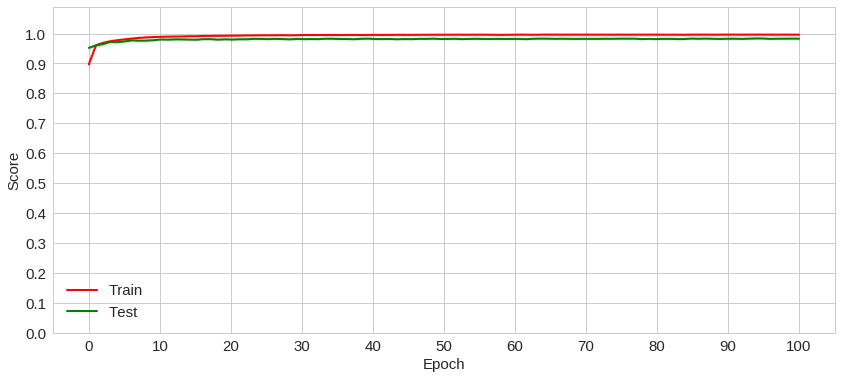

In [38]:
plot_mean_acc(tophist)

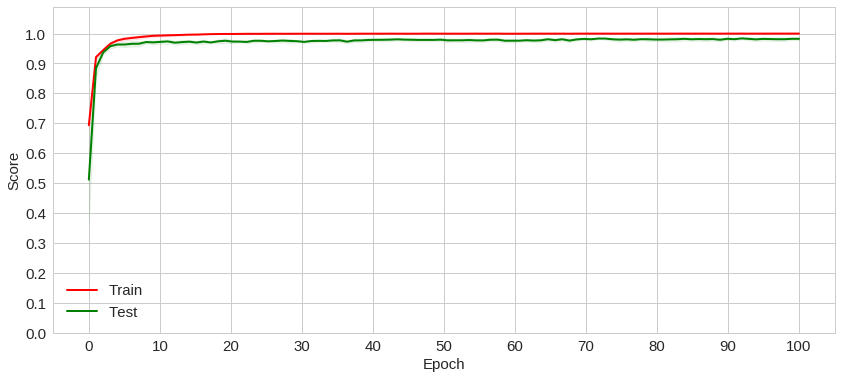

In [39]:
plot_mean_acc(hist)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

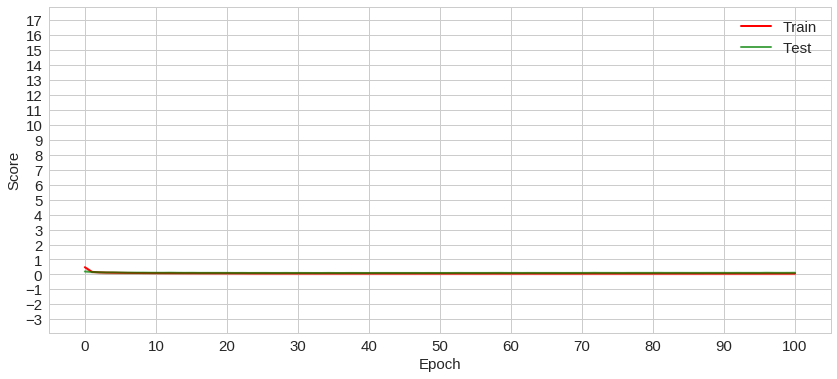

In [41]:
plot_mean_loss(tophist)

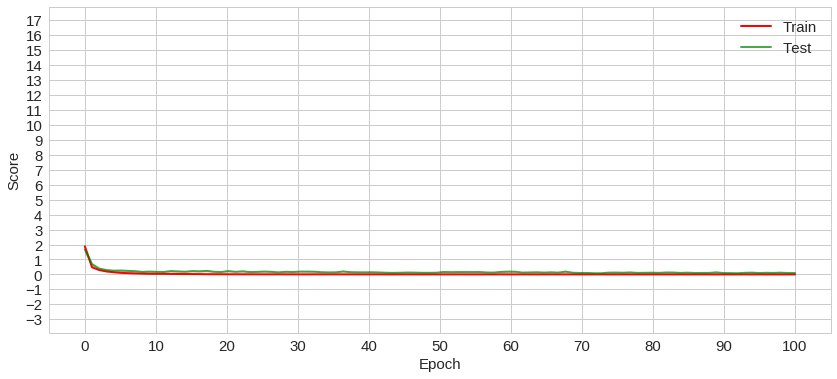

In [42]:
plot_mean_loss(hist)